In [1]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions
from collections import namedtuple
from itertools import count

device = "cuda:0"
floattype = torch.float

batchsize = 512
nsamples = 8
npoints = 5
emsize = 512


class Graph_Transformer(nn.Module):
    def __init__(self, emsize = 64, nhead = 8, nhid = 1024, nlayers = 4, ndecoderlayers = 2, dropout = 0):
        super().__init__()
        self.emsize = emsize
        from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
        encoder_layers = TransformerEncoderLayer(emsize, nhead, nhid, dropout = dropout)
        decoder_layers = TransformerDecoderLayer(emsize, nhead, nhid, dropout = dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.transformer_decoder = TransformerDecoder(decoder_layers, ndecoderlayers)
        self.encoder = nn.Linear(2, emsize)
        self.outputattention_query = nn.Linear(emsize, emsize, bias = False)
        self.outputattention_key = nn.Linear(emsize, emsize, bias = False)
        self.start_token = nn.Parameter(torch.randn([emsize], device = device))
    
    def generate_subsequent_mask(self, sz): #last dimension will be softmaxed over when adding to attention logits, if boolean the ones turn into -inf
        mask = (torch.triu(torch.ones(sz, sz, device = device)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        
        #mask = torch.triu(torch.ones([sz, sz], dtype = torch.bool, device = device), diagonal = 1)
        return mask
    
    def encode(self, src): #src must be [batchsize * nsamples, npoints, 3]
        src = self.encoder(src).transpose(0, 1)
        output = self.transformer_encoder(src)
        return output #[npoints, batchsize * nsamples, emsize]
    
    def decode_next(self, memory, tgt, route_mask): #route mask is [batchsize * nsamples, npoints], both memory and tgt must have batchsize and nsamples in same dimension (the 1th one)
        npoints = memory.size(0)
        batchsize = tgt.size(1)
        """if I really wanted this to be efficient I'd only recompute the decoder for the last tgt, and just remebering what the others looked like from before (won't change due to mask)"""
        """have the option to freeze the autograd on all but the last part of tgt, although at the moment this is a very natural way to say: initial choices matter more"""
        tgt_mask = self.generate_subsequent_mask(tgt.size(0))
        output = self.transformer_decoder(tgt, memory, tgt_mask) #[tgt, batchsize * nsamples, emsize]
        output_query = self.outputattention_query(memory).transpose(0, 1) #[batchsize * nsamples, npoints, emsize]
        output_key = self.outputattention_key(output[-1]) #[batchsize * nsamples, emsize]
        output_attention = torch.matmul(output_query * self.emsize ** -0.5, output_key.unsqueeze(-1)).squeeze(-1) #[batchsize * nsamples, npoints], technically don't need to scale attention as we divide by variance next anyway
        output_attention_tanh = output_attention.tanh() #[batchsize * nsamples, npoints]
        
        #we clone the route_mask incase we want to backprop using it (else it was modified by inplace opporations)
        output_attention = output_attention.masked_fill(route_mask.clone(), float('-inf')) #[batchsize * nsamples, npoints]
        output_attention_tanh = output_attention_tanh.masked_fill(route_mask.clone(), float('-inf')) #[batchsize * nsamples, npoints]
        
        return output_attention_tanh, output_attention #[batchsize * nsamples, npoints]
    
    def calculate_logprob(self, memory, routes): #memory is [npoints, batchsize * nsamples, emsize], routes is [batchsize * nsamples, npoints - 4], rather than backproping the entire loop, this saves vram (and computation)
        npoints = memory.size(0)
        ninternalpoints = routes.size(1)
        bigbatchsize = memory.size(1)
        memory_ = memory.gather(0, routes.transpose(0, 1).unsqueeze(2).expand(-1, -1, self.emsize)) #[npoints - 4, batchsize * nsamples, emsize] reorder memory into order of routes
        tgt = torch.cat([self.start_token.unsqueeze(0).unsqueeze(1).expand(1, bigbatchsize, -1), memory_[:-1]]) #[npoints - 4, batchsize * nroutes, emsize], want to go from memory to tgt
        tgt_mask = self.generate_subsequent_mask(ninternalpoints)
        output = self.transformer_decoder(tgt, memory, tgt_mask) #[npoints - 4, batchsize * nsamples, emsize]
        """want probability of going from key to query, but first need to normalise (softmax with mask)"""
        output_query = self.outputattention_query(memory_).transpose(0, 1) #[batchsize * nsamples, npoints - 4, emsize]
        output_key = self.outputattention_key(output).transpose(0, 1) #[batchsize * nsamples, npoints - 4, emsize]
        attention_mask = torch.full([ninternalpoints, ninternalpoints], True, device = device).triu(1) #[npoints - 4, npoints - 4], True for i < j
        output_attention = torch.matmul(output_query * self.emsize ** -0.5, output_key.transpose(-1, -2))
        """quick fix to stop divergence"""
        output_attention_tanh = output_attention.tanh()
        
        output_attention_tanh = output_attention_tanh.masked_fill(attention_mask, float('-inf'))
        output_attention_tanh = output_attention_tanh - output_attention_tanh.logsumexp(-2, keepdim = True) #[batchsize * nsamples, npoints - 4, npoints - 4]
        
        output_attention = output_attention.masked_fill(attention_mask, float('-inf'))
        output_attention = output_attention - output_attention.logsumexp(-2, keepdim = True) #[batchsize * nsamples, npoints - 4, npoints - 4]
        
        """infact I'm almost tempted to not mask choosing a previous point, so it's forced to learn it and somehow incorporate it into its computation, but without much impact on reinforcing good examples"""
        logprob_tanh = output_attention_tanh.diagonal(dim1 = -1, dim2 = -2).sum(-1) #[batchsize * nsamples]
        logprob = output_attention.diagonal(dim1 = -1, dim2 = -2).sum(-1) #[batchsize * nsamples]
        return logprob_tanh, logprob #[batchsize * nsamples]

NN = Graph_Transformer().to(device)
optimizer = optim.Adam(NN.parameters(), lr = 0.0001)


class environment:    
    def reset(self, npoints, batchsize, nsamples=1):
        self.batchsize = (
            batchsize * nsamples
        )  # so that I don't have to rewrite all this code, we store these two dimensions together
        self.nsamples = nsamples
        self.npoints = npoints
        self.points = (
            torch.rand([batchsize, npoints, 2], dtype = floattype, device=device)
            .unsqueeze(1)
            .expand(-1, nsamples, -1, -1)
            .reshape(self.batchsize, npoints, 2)
        )
        
        self.distance_matrix = (self.points.unsqueeze(1) - self.points.unsqueeze(2)).square().sum(-1).sqrt() # [batchsize * nsamples, npoints, npoints]
        
        self.previous_point = None
        
        self.points_mask = torch.zeros(
                    [self.batchsize, npoints], dtype=torch.bool, device=device
                )
        self.points_sequence = torch.empty(
            [self.batchsize, 0], dtype=torch.long, device=device
        )
        
        self.cost = torch.zeros([self.batchsize], dtype = floattype, device=device)

        self.logprob = torch.zeros([self.batchsize], dtype = floattype, device=device, requires_grad=True)

    def update(self, point_index):  # point_index is [batchsize]
        
        assert list(point_index.size()) == [self.batchsize]
        assert str(point_index.device) == device
        assert self.points_mask.gather(1, point_index.unsqueeze(1)).sum() == 0
        
        if self.previous_point != None:
            self.cost += self.distance_matrix.gather(2, self.previous_point.unsqueeze(1).unsqueeze(2).expand(-1, self.npoints, 1)).squeeze(2).gather(1, point_index.unsqueeze(1)).squeeze(1)
        
        self.previous_point = point_index
        self.points_mask.scatter_(1, point_index.unsqueeze(1), True)
        self.points_sequence = torch.cat([self.points_sequence, point_index.unsqueeze(1)], dim = 1)
        
        return
    
    def sample_point(self, logits): #logits must be [batchsize * nsamples, npoints]
        probs = torch.distributions.categorical.Categorical(logits = logits)
        next_point = probs.sample() #size is [batchsize * nsamples]
        self.update(next_point)
        self.logprob = self.logprob + probs.log_prob(next_point)
        return next_point #[batchsize * nsamples]
    
    def sampleandgreedy_point(self, logits): #logits must be [batchsize * nsamples, npoints], last sample will be the greedy choice (but we still need to keep track of its logits)
        logits_sample = logits.view(-1, self.nsamples, self.npoints)[:, :-1, :]
        probs = torch.distributions.categorical.Categorical(logits = logits_sample)
        
        sample_point = probs.sample() #[batchsize, (nsamples - 1)]
        greedy_point = logits.view(-1, self.nsamples, self.npoints)[:, -1, :].max(-1, keepdim = True)[1] #[batchsize, 1]
        next_point = torch.cat([sample_point, greedy_point], dim = 1).view(-1)
        self.update(next_point)
        self.logprob = self.logprob + torch.cat([probs.log_prob(sample_point), torch.zeros([sample_point.size(0), 1], device = device)], dim = 1).view(-1)
        return next_point
    
    def laststep(self):
        
        assert self.points_sequence.size(1) == self.npoints
        
        self.cost += self.distance_matrix.gather(2, self.points_sequence[:, 0].unsqueeze(1).unsqueeze(2).expand(-1, self.npoints, 1)).squeeze(2).gather(1, self.points_sequence[:, -1].unsqueeze(1)).squeeze(1)
    

env = environment()


def train(epochs = 30000, npoints = 10, batchsize = 100, nsamples = 8, negative_cutoff = 1):
    NN.train()
    for i in range(epochs):
        env.reset(npoints, batchsize, nsamples)
        """include the boundary points, kinda makes sense that they should contribute (atm only in the encoder, difficult to see how in the decoder)"""
        memory = NN.encode(env.points) #[npoints, batchsize * nsamples, emsize]
        #### #### #### remember to include tgt.detach() when reinstate with torch.no_grad()
        tgt = NN.start_token.unsqueeze(0).unsqueeze(1).expand(1, batchsize * nsamples, -1).detach() #[1, batchsize * nsamples, emsize]
        #with torch.no_grad(): #to speed up computation, selecting routes is done without gradient
        with torch.no_grad():
            for j in range(0, npoints):
                #### #### #### remember to include memory.detach() when reinstate with torch.no_grad()
                _, logits = NN.decode_next(memory.detach(), tgt, env.points_mask)
                next_point = env.sampleandgreedy_point(logits)
                """
                for inputing the previous embedding into decoder
                """
                tgt = torch.cat([tgt, memory.gather(0, next_point.unsqueeze(0).unsqueeze(2).expand(1, -1, memory.size(2)))]) #[nsofar, batchsize * nsamples, emsize]
                """
                for inputing the previous decoder output into the decoder (allows for an evolving strategy, but doesn't allow for fast training
                """
                ############

        env.laststep()
        
        NN.eval()
        _, logprob = NN.calculate_logprob(memory, env.points_sequence) #[batchsize * nsamples]
        NN.train()
        """
        clip logprob so doesn't reinforce things it already knows
        TBH WANT SOMETHING DIFFERENT ... want to massively increase training if find something unexpected and otherwise not
        """
        greedy_prob = logprob.view(batchsize, nsamples)[:, -1].detach() #[batchsize]
        greedy_baseline = env.cost.view(batchsize, nsamples)[:, -1] #[batchsize], greedy sample
        fixed_baseline = 0.5 * torch.ones([1], device = device)
        min_baseline = env.cost.view(batchsize, nsamples)[:, :-1].min(-1)[0] #[batchsize], minimum cost
        baseline = greedy_baseline
        positive_reinforcement = - F.relu( - (env.cost.view(batchsize, nsamples)[:, :-1] - baseline.unsqueeze(1))) #don't scale positive reinforcement
        negative_reinforcement = F.relu(env.cost.view(batchsize, nsamples)[:, :-1] - baseline.unsqueeze(1))
        positive_reinforcement_binary = env.cost.view(batchsize, nsamples)[:, :-1] - baseline.unsqueeze(1) <= -0.05
        negative_reinforcement_binary = env.cost.view(batchsize, nsamples)[:, :-1] - baseline.unsqueeze(1) > negative_cutoff
        """
        binary positive reinforcement
        """
        #loss = - ((logprob.view(batchsize, nsamples)[:, :-1] < -0.2) * logprob.view(batchsize, nsamples)[:, :-1] * positive_reinforcement_binary).mean() #+ (logprob.view(batchsize, nsamples)[:, :-1] > -1) * logprob.view(batchsize, nsamples)[:, :-1] * negative_reinforcement_binary
        """
        clipped binary reinforcement
        """
        #loss = ( 
        #        - logprob.view(batchsize, nsamples)[:, :-1] 
        #        #* (logprob.view(batchsize, nsamples)[:, :-1] < 0) 
        #        * positive_reinforcement_binary 
        #        + logprob.view(batchsize, nsamples)[:, :-1] 
        #        * (logprob.view(batchsize, nsamples)[:, :-1] > greedy_prob.unsqueeze(1) - 80) 
        #        * negative_reinforcement_binary 
        #).mean()
        """
        clipped binary postive, clipped weighted negative
        """
        #loss = ( - logprob.view(batchsize, nsamples)[:, :-1] * (logprob.view(batchsize, nsamples)[:, :-1] < -0.2) * positive_reinforcement_binary + logprob.view(batchsize, nsamples)[:, :-1] * (logprob.view(batchsize, nsamples)[:, :-1] > -2) * negative_reinforcement ).mean()
        """
        clipped reinforcement without rescaling
        """
        #loss = ((logprob.view(batchsize, nsamples)[:, :-1] < -0.7) * logprob.view(batchsize, nsamples)[:, :-1] * positive_reinforcement + (logprob.view(batchsize, nsamples)[:, :-1] > -5) * logprob.view(batchsize, nsamples)[:, :-1] * negative_reinforcement).mean()
        """
        clipped reinforcement
        """
        #loss = (logprob.view(batchsize, nsamples)[:, :-1] * positive_reinforcement / (positive_reinforcement.var() + 0.001).sqrt() + (logprob.view(batchsize, nsamples)[:, :-1] > -3) * logprob.view(batchsize, nsamples)[:, :-1] * negative_reinforcement / (negative_reinforcement.var() + 0.001).sqrt()).mean()
        """
        balanced reinforcement
        """
        #loss = (logprob.view(batchsize, nsamples)[:, :-1] * (positive_reinforcement / (positive_reinforcement.var() + 0.001).sqrt() + negative_reinforcement / (negative_reinforcement.var() + 0.001).sqrt())).mean()
        """
        regular loss
        """
        loss = (logprob.view(batchsize, nsamples)[:, :-1] * (positive_reinforcement + negative_reinforcement)).mean()
        optimizer.zero_grad()
        loss.backward()
        #print(NN.encoder.weight.grad)
        optimizer.step()
        #print(greedy_baseline.mean().item())
        print(greedy_baseline.mean().item(), logprob.view(batchsize, nsamples)[:, -1].mean().item(), logprob.view(batchsize, nsamples)[:, :-1].mean().item(), logprob[batchsize - 1].item(), logprob[0].item(), env.logprob[0].item())
        
def evaluate(epochs = 1, npoints = 1000, batchsize = 1, nsamples = 2, negative_cutoff = 1):
    NN.eval()
    for i in range(epochs):
        env.reset(npoints, batchsize, nsamples)
        """include the boundary points, kinda makes sense that they should contribute (atm only in the encoder, difficult to see how in the decoder)"""
        memory = NN.encode(env.points) #[npoints, batchsize * nsamples, emsize]
        #### #### #### remember to include tgt.detach() when reinstate with torch.no_grad()
        tgt = NN.start_token.unsqueeze(0).unsqueeze(1).expand(1, batchsize * nsamples, -1).detach() #[1, batchsize * nsamples, emsize]
        #with torch.no_grad(): #to speed up computation, selecting routes is done without gradient
        with torch.no_grad():
            for j in range(0, npoints):
                #### #### #### remember to include memory.detach() when reinstate with torch.no_grad()
                _, logits = NN.decode_next(memory.detach(), tgt, env.points_mask)
                next_point = env.sampleandgreedy_point(logits)
                """
                for inputing the previous embedding into decoder
                """
                tgt = torch.cat([tgt, memory.gather(0, next_point.unsqueeze(0).unsqueeze(2).expand(1, -1, memory.size(2)))]) #[nsofar, batchsize * nsamples, emsize]
                """
                for inputing the previous decoder output into the decoder (allows for an evolving strategy, but doesn't allow for fast training
                """
                ############

        env.laststep()
        
        
        _, logprob = NN.calculate_logprob(memory, env.points_sequence) #[batchsize * nsamples]
        
        """
        clip logprob so doesn't reinforce things it already knows
        TBH WANT SOMETHING DIFFERENT ... want to massively increase training if find something unexpected and otherwise not
        """
        greedy_prob = logprob.view(batchsize, nsamples)[:, -1].detach() #[batchsize]
        greedy_baseline = env.cost.view(batchsize, nsamples)[:, -1] #[batchsize], greedy sample
        
        print(greedy_baseline.mean().item(), logprob.view(batchsize, nsamples)[:, -1].mean().item(), logprob.view(batchsize, nsamples)[:, :-1].mean().item(), logprob[batchsize - 1].item(), logprob[0].item(), env.logprob[0].item())
   

In [2]:
NN.load_state_dict(torch.load('TSP_50points_untrained'))
train(300000, 50, 400, 8)

14.162066459655762 -145.4246368408203 -148.37380981445312 -145.1979217529297 -147.44686889648438 -147.44683837890625
13.767304420471191 -140.23143005371094 -147.62255859375 -140.69741821289062 -148.22036743164062 -148.2203826904297
14.600021362304688 -128.86558532714844 -143.34207153320312 -130.5353546142578 -142.5356903076172 -142.53570556640625
14.20198917388916 -105.32838439941406 -126.43193817138672 -103.46892547607422 -122.43162536621094 -122.4316177368164
11.944461822509766 -90.87957000732422 -113.75719451904297 -93.39191436767578 -106.09380340576172 -106.09381103515625
10.771122932434082 -82.21159362792969 -106.2369384765625 -81.63482666015625 -105.520751953125 -105.52073669433594
8.29434585571289 -83.6611099243164 -109.00015258789062 -85.43611907958984 -109.56817626953125 -109.56818389892578
8.20797061920166 -73.10462951660156 -98.49163055419922 -72.69026184082031 -96.81000518798828 -96.80998992919922
8.666574478149414 -68.1287612915039 -93.61217498779297 -75.06120300292969 -90

6.61053991317749 -13.2441987991333 -24.687490463256836 -12.098559379577637 -27.345630645751953 -27.34561538696289
6.598101615905762 -12.936498641967773 -24.093280792236328 -11.740489959716797 -24.91765022277832 -24.91765594482422
6.657532691955566 -12.917194366455078 -24.058216094970703 -10.999567031860352 -28.482179641723633 -28.482177734375
6.692577362060547 -12.452763557434082 -23.59272575378418 -9.100610733032227 -18.37289047241211 -18.37287139892578
6.674992084503174 -12.559699058532715 -23.671701431274414 -17.283618927001953 -17.785842895507812 -17.78583526611328
6.575878143310547 -12.308022499084473 -23.46440315246582 -10.12636947631836 -39.34051513671875 -39.34051513671875
6.592752933502197 -12.382847785949707 -23.273189544677734 -9.367147445678711 -23.54143524169922 -23.541418075561523
6.616950035095215 -12.329157829284668 -23.350984573364258 -16.26639747619629 -25.56722640991211 -25.567214965820312
6.680257320404053 -12.247318267822266 -23.194808959960938 -9.8228759765625 -14

6.475283622741699 -8.837970733642578 -17.03338623046875 -8.034746170043945 -12.806675910949707 -12.80670166015625
6.434107303619385 -8.86801815032959 -16.9942626953125 -7.6551408767700195 -16.57052230834961 -16.570497512817383
6.46751594543457 -8.818254470825195 -17.021041870117188 -10.105337142944336 -16.28264617919922 -16.28264045715332
6.448117733001709 -8.838064193725586 -17.140710830688477 -10.12823486328125 -20.711261749267578 -20.711259841918945
6.4358110427856445 -8.598512649536133 -16.790315628051758 -6.735067367553711 -9.611146926879883 -9.611143112182617
6.425099849700928 -8.568843841552734 -16.51580047607422 -7.572751998901367 -18.712100982666016 -18.71210479736328
6.490060806274414 -8.526117324829102 -16.21261215209961 -6.952413558959961 -28.489688873291016 -28.489696502685547
6.471917152404785 -8.470205307006836 -16.23443031311035 -6.8347296714782715 -24.05362319946289 -24.05364418029785
6.430866718292236 -8.437093734741211 -16.233409881591797 -8.918899536132812 -18.17328

6.447152137756348 -7.152154445648193 -14.097936630249023 -6.6216936111450195 -9.96210765838623 -9.96212387084961
6.387218952178955 -7.023041725158691 -13.771905899047852 -3.615813732147217 -15.016551971435547 -15.016546249389648
6.359903812408447 -7.052945613861084 -13.891562461853027 -5.970405578613281 -11.717129707336426 -11.717124938964844
6.3819193840026855 -7.151431560516357 -14.008702278137207 -5.768280029296875 -9.602088928222656 -9.602106094360352
6.381998062133789 -7.245269775390625 -13.93643856048584 -4.939067363739014 -12.121333122253418 -12.121319770812988
6.350246906280518 -7.065454006195068 -13.925705909729004 -5.2688889503479 -15.017000198364258 -15.017021179199219
6.357763767242432 -7.213041305541992 -14.029614448547363 -10.111152648925781 -6.228887557983398 -6.2288923263549805
6.406876087188721 -7.151508808135986 -13.873309135437012 -7.912744522094727 -12.453766822814941 -12.453767776489258
6.355679988861084 -7.057265281677246 -13.688202857971191 -8.445979118347168 -8.

6.20844841003418 -6.13396692276001 -12.308903694152832 -5.10168981552124 -11.089409828186035 -11.089400291442871
6.256983280181885 -6.426660060882568 -12.614384651184082 -6.651464462280273 -12.38201904296875 -12.382003784179688
6.265161037445068 -6.576502323150635 -12.86800765991211 -6.9986677169799805 -14.870004653930664 -14.869989395141602
6.191125392913818 -6.631443977355957 -13.031726837158203 -8.673734664916992 -15.021821975708008 -15.02180290222168
6.241921901702881 -6.670593738555908 -13.048192977905273 -5.1644792556762695 -23.481727600097656 -23.481727600097656
6.231637954711914 -6.647639751434326 -12.83147144317627 -4.913893699645996 -8.85651683807373 -8.856510162353516
6.268533706665039 -6.569793701171875 -12.897706031799316 -8.305059432983398 -11.819622993469238 -11.819642066955566
6.190855026245117 -6.514631271362305 -12.843493461608887 -5.014660835266113 -12.596036911010742 -12.596059799194336
6.220115661621094 -6.395109176635742 -12.533055305480957 -4.205160140991211 -15.

6.313016414642334 -5.678933143615723 -11.129396438598633 -5.361727714538574 -7.626461505889893 -7.626484394073486
6.256487846374512 -5.693567276000977 -11.168274879455566 -8.540416717529297 -7.387725830078125 -7.3876953125
6.245841026306152 -5.679293155670166 -11.199454307556152 -4.066254615783691 -5.898372650146484 -5.89836311340332
6.212484836578369 -5.638627052307129 -10.991766929626465 -4.973936080932617 -6.334562301635742 -6.334562301635742
6.231947898864746 -5.661937713623047 -11.112430572509766 -5.769570350646973 -17.672225952148438 -17.67218780517578
6.279684543609619 -5.468552112579346 -10.844451904296875 -6.433784484863281 -7.197105407714844 -7.197120666503906
6.243154048919678 -5.356601238250732 -10.454273223876953 -6.393495559692383 -9.717884063720703 -9.717853546142578
6.230130672454834 -5.505671977996826 -10.803325653076172 -3.5660171508789062 -7.4447174072265625 -7.444725036621094
6.23187780380249 -5.402381420135498 -10.56029224395752 -6.359609603881836 -10.9836034774780

6.163277626037598 -4.869192600250244 -9.783591270446777 -5.201729774475098 -10.788980484008789 -10.788990020751953
6.182472229003906 -4.81174373626709 -9.429727554321289 -6.036991119384766 -6.130870819091797 -6.130859375
6.174650192260742 -4.753936767578125 -9.51202392578125 -3.8773365020751953 -8.546819686889648 -8.546812057495117
6.202223777770996 -4.772254467010498 -9.413578033447266 -4.058845520019531 -7.762168884277344 -7.762125015258789
6.204573631286621 -4.802437782287598 -9.52152156829834 -7.166373252868652 -8.770546913146973 -8.77055835723877
6.179529190063477 -4.812099456787109 -9.632465362548828 -7.441762924194336 -21.389728546142578 -21.389728546142578
6.173613548278809 -4.7912116050720215 -9.469878196716309 -5.407615661621094 -11.054300308227539 -11.054330825805664
6.175891399383545 -5.187518119812012 -10.131858825683594 -6.653212070465088 -10.085372924804688 -10.08536148071289
6.149591445922852 -5.125866413116455 -10.185895919799805 -3.303211212158203 -12.318296432495117 

6.233237266540527 -4.764542579650879 -9.48186206817627 -3.366072177886963 -11.545153617858887 -11.545180320739746
6.166759014129639 -4.626349925994873 -8.975163459777832 -2.0151047706604004 -4.963799953460693 -4.963803291320801
6.221456050872803 -4.467133045196533 -8.989897727966309 -3.848233699798584 -5.596897125244141 -5.596872329711914
6.182573318481445 -4.50145149230957 -8.831720352172852 -3.0619077682495117 -5.810800552368164 -5.810815811157227
6.192929744720459 -4.56410551071167 -8.958107948303223 -4.499166488647461 -14.18855094909668 -14.188565254211426
6.169631004333496 -4.552422523498535 -8.926475524902344 -3.084988594055176 -10.534061431884766 -10.534061431884766
6.160174369812012 -4.629937648773193 -9.018953323364258 -5.335239410400391 -13.27226448059082 -13.272260665893555
6.180483341217041 -4.733442306518555 -9.084200859069824 -5.949527740478516 -8.95799446105957 -8.957956314086914
6.155445575714111 -4.583798408508301 -9.022443771362305 -3.8772010803222656 -12.121347427368

6.132246017456055 -4.053614616394043 -8.021955490112305 -3.8228988647460938 -6.260663032531738 -6.260623931884766
6.147064208984375 -4.150750637054443 -8.221446990966797 -3.481670379638672 -11.58248519897461 -11.582538604736328
6.180506229400635 -4.085631847381592 -8.0526762008667 -2.2762222290039062 -13.256743431091309 -13.256743431091309
6.140157222747803 -4.148746490478516 -8.124216079711914 -2.207775115966797 -6.558005332946777 -6.557967185974121
6.167185306549072 -4.097078323364258 -7.981060028076172 -5.256153106689453 -9.646585464477539 -9.646570205688477
6.13177490234375 -4.183530330657959 -8.148964881896973 -4.294380187988281 -6.7984466552734375 -6.798439025878906
6.142167091369629 -4.219592571258545 -8.32126522064209 -2.5079431533813477 -6.311803817749023 -6.31181526184082
6.14167594909668 -4.258753776550293 -8.295114517211914 -4.228267669677734 -9.39897346496582 -9.398981094360352
6.112828254699707 -4.074101448059082 -8.086875915527344 -2.9777603149414062 -3.830402374267578 -

KeyboardInterrupt: 

129.13131713867188 -5846.537109375 -5910.1796875 -5910.1796875 -5910.1796875 -5910.1796875


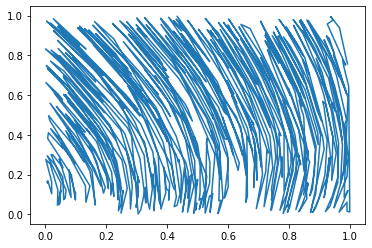

In [2]:
torch.save(NN.state_dict(), 'TSP_50points_untrained')
evaluate(1, 1000, 1, 2)
import matplotlib.pyplot as plt
points = env.points[1].to("cpu").numpy() #[npoints, 2]
order = env.points_sequence[1].to("cpu").numpy() #[npoints]
plt.plot(points[order, 0], points[order, 1])
plt.savefig('1000points_untrained.png')

36.39710235595703 -818.1583251953125 -1315.6932373046875 -1315.6932373046875 -1315.6932373046875 -1315.695068359375


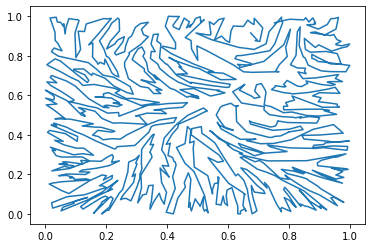

In [3]:
torch.save(NN.state_dict(), 'TSP_50points_30mins')
evaluate(1, 1000, 1, 2)
import matplotlib.pyplot as plt
points = env.points[1].to("cpu").numpy() #[npoints, 2]
order = env.points_sequence[1].to("cpu").numpy() #[npoints]
plt.plot(points[order, 0], points[order, 1])
plt.savefig('1000points_30mins.png')

In [2]:
NN.load_state_dict(torch.load('TSP_50points_30mins'))
train(300000, 50, 400, 8)

6.14451789855957 -4.090236663818359 -7.977935791015625 -3.9730472564697266 -7.160930633544922 -7.160907745361328
6.177001953125 -3.851534366607666 -7.6637420654296875 -6.3396196365356445 -5.5211896896362305 -5.5212202072143555
6.175221920013428 -3.8638505935668945 -7.558821201324463 -4.7216596603393555 -7.4492645263671875 -7.449226379394531
6.111404895782471 -3.8797338008880615 -7.612930774688721 -3.1699066162109375 -8.989078521728516 -8.98910140991211
6.102571964263916 -3.821805715560913 -7.633534908294678 -3.8952293395996094 -8.747638702392578 -8.747596740722656
6.081028461456299 -3.8842995166778564 -7.687559127807617 -2.3509044647216797 -3.6303138732910156 -3.63031005859375
6.117626190185547 -3.953343391418457 -7.807974338531494 -5.158084869384766 -8.089792251586914 -8.089822769165039
6.127466201782227 -3.964747190475464 -7.7933454513549805 -3.109844207763672 -10.485883712768555 -10.485872268676758
6.151655197143555 -3.963571786880493 -7.966750144958496 -3.7803173065185547 -17.39709

6.058189392089844 -3.4839324951171875 -6.954337120056152 -3.045085906982422 -7.508986949920654 -7.509009838104248
6.107372283935547 -3.599929094314575 -7.176290512084961 -4.9834136962890625 -7.45318603515625 -7.4531707763671875
6.087698936462402 -3.6037611961364746 -7.206701755523682 -3.9026947021484375 -4.907064437866211 -4.907075881958008
6.071282863616943 -3.7741384506225586 -7.386631965637207 -3.1061410903930664 -4.855503559112549 -4.855530738830566
6.07064151763916 -3.6384551525115967 -7.31730318069458 -2.646800994873047 -5.121555328369141 -5.121555328369141
6.062747478485107 -3.7796969413757324 -7.48262882232666 -3.4143781661987305 -7.347738265991211 -7.34779167175293
6.09470796585083 -3.9555740356445312 -7.783294200897217 -3.6845946311950684 -5.916988372802734 -5.916988372802734
6.057610511779785 -4.013916969299316 -7.968797206878662 -2.800900459289551 -11.139586448669434 -11.139544486999512
6.082286357879639 -3.969731092453003 -7.919956207275391 -2.6383752822875977 -5.814807891

6.080298900604248 -3.507399797439575 -6.9120659828186035 -1.7423133850097656 -2.0016345977783203 -2.0016422271728516
6.084374904632568 -3.449396848678589 -6.836208820343018 -2.9598770141601562 -11.772895812988281 -11.772907257080078
6.072499752044678 -3.470447301864624 -6.77659797668457 -2.6078033447265625 -6.5265960693359375 -6.526618957519531
6.092490196228027 -3.4270317554473877 -6.828525543212891 -2.4504013061523438 -1.024576187133789 -1.0245647430419922
6.07131290435791 -3.5328314304351807 -6.968883991241455 -3.9126415252685547 -4.02569580078125 -4.025672912597656
6.058273792266846 -3.5812695026397705 -7.1604437828063965 -4.683582305908203 -10.188356399536133 -10.188371658325195
6.060428142547607 -3.6270275115966797 -7.226212024688721 -1.376467227935791 -11.368656158447266 -11.368658065795898
6.094936370849609 -3.6532881259918213 -7.098736763000488 -4.337009429931641 -9.291509628295898 -9.291509628295898
6.057615756988525 -3.567969799041748 -7.114302158355713 -5.0639448165893555 -

6.06282901763916 -3.3919289112091064 -6.667123794555664 -2.2725753784179688 -6.332370758056641 -6.332370758056641
6.090588092803955 -3.348762035369873 -6.621981620788574 -2.036121368408203 -11.616832733154297 -11.616825103759766
6.050838470458984 -3.3891704082489014 -6.707070350646973 -3.1475143432617188 -7.870210647583008 -7.870233535766602
6.063208103179932 -3.4398155212402344 -6.722227096557617 -3.8964033126831055 -4.32954216003418 -4.329557418823242
6.045979022979736 -3.503660202026367 -6.944822788238525 -3.151426315307617 -4.060710906982422 -4.060749053955078
6.088387489318848 -3.4946835041046143 -6.8662428855896 -3.1769943237304688 -8.215248107910156 -8.215202331542969
6.050854206085205 -3.5268430709838867 -6.852555751800537 -6.405083179473877 -5.1255340576171875 -5.125518798828125
6.027778625488281 -3.3862736225128174 -6.665475845336914 -2.6626815795898438 -5.736888885498047 -5.736850738525391
6.054419994354248 -3.331235647201538 -6.673346519470215 -4.116325378417969 -15.0819091

6.040260314941406 -3.2162492275238037 -6.36839485168457 -3.4784679412841797 -6.5420989990234375 -6.542106628417969
6.044399261474609 -3.256788492202759 -6.450746536254883 -3.2175941467285156 -10.314962387084961 -10.315023422241211
6.065678119659424 -3.2752881050109863 -6.388865947723389 -2.4518604278564453 -2.805084228515625 -2.8050994873046875
6.027463436126709 -3.3205742835998535 -6.50377082824707 -3.4496688842773438 -8.570487976074219 -8.570503234863281
6.083247661590576 -3.301755666732788 -6.511758327484131 -3.533384323120117 -4.219478607177734 -4.219486236572266
6.036038875579834 -3.1579015254974365 -6.275331974029541 -2.5578689575195312 -7.126265525817871 -7.126238822937012
6.028461933135986 -3.2198326587677 -6.408599376678467 -4.001152038574219 -6.501697540283203 -6.50164794921875
6.040863990783691 -3.312168598175049 -6.555187702178955 -4.704854488372803 -5.436298370361328 -5.436302185058594
6.045900344848633 -3.2176756858825684 -6.414822578430176 -2.42767333984375 -12.714321136

KeyboardInterrupt: 

37.537498474121094 -642.8604736328125 -1115.4844970703125 -1115.4844970703125 -1115.4844970703125 -1115.484375


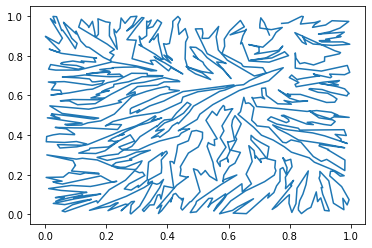

In [3]:
torch.save(NN.state_dict(), 'TSP_50points_45mins')
evaluate(1, 1000, 1, 2)
import matplotlib.pyplot as plt
points = env.points[1].to("cpu").numpy() #[npoints, 2]
order = env.points_sequence[1].to("cpu").numpy() #[npoints]
plt.plot(points[order, 0], points[order, 1])
plt.savefig('1000points_45mins.png')

In [2]:
NN.load_state_dict(torch.load('TSP_50points_45mins'))
train(300000, 50, 400, 8)

6.032081604003906 -3.2393407821655273 -6.5620436668396 -3.4081153869628906 -6.760623931884766 -6.760601043701172
6.056543827056885 -3.202587127685547 -6.407085418701172 -2.1716270446777344 -6.019472122192383 -6.019372940063477
6.04717493057251 -3.240424156188965 -6.420056343078613 -2.3431854248046875 -6.843841552734375 -6.843841552734375
6.011171817779541 -3.3894808292388916 -6.6350417137146 -3.4779014587402344 -5.710348129272461 -5.710363388061523
6.0419206619262695 -3.2228846549987793 -6.294002532958984 -3.458608627319336 -9.404617309570312 -9.404609680175781
6.04141092300415 -3.224918842315674 -6.320923328399658 -2.146688461303711 -4.441659927368164 -4.441652774810791
6.019567966461182 -3.1625561714172363 -6.340145111083984 -2.4993019104003906 -7.982292175292969 -7.9822845458984375
6.040072917938232 -3.0866682529449463 -6.196194171905518 -2.2979440689086914 -4.942232131958008 -4.942232131958008
5.999195575714111 -3.1002166271209717 -6.151569366455078 -2.70428466796875 -3.45775604248

6.055627346038818 -3.1198980808258057 -6.231672763824463 -0.9418494701385498 -13.811843872070312 -13.811912536621094
6.047626972198486 -3.078721284866333 -6.098486423492432 -3.092174530029297 -4.096693992614746 -4.096739768981934
6.002871513366699 -3.1475727558135986 -6.1061601638793945 -3.6240882873535156 -11.734649658203125 -11.734611511230469
6.021633148193359 -3.094029426574707 -6.114832401275635 -2.48138427734375 -3.645069122314453 -3.645069122314453
6.033865928649902 -3.0785140991210938 -6.150885105133057 -5.976108551025391 -5.380279541015625 -5.380271911621094
6.006775856018066 -3.010510206222534 -6.073240756988525 -4.800095558166504 -4.888675689697266 -4.888690948486328
6.0426225662231445 -3.1314709186553955 -6.116652965545654 -3.3607864379882812 -6.081233978271484 -6.081207275390625
6.04636812210083 -3.030421733856201 -6.089714050292969 -2.0365352630615234 -11.610690116882324 -11.610617637634277
6.029001235961914 -3.054852247238159 -6.0272040367126465 -2.643868923187256 -9.863

6.039202690124512 -3.0627567768096924 -6.110408782958984 -3.712505340576172 -3.081066131591797 -3.081073760986328
6.021437644958496 -3.0696468353271484 -5.904181003570557 -3.1582870483398438 -5.965439796447754 -5.965470314025879
6.0141777992248535 -3.0771703720092773 -6.064878463745117 -2.993556499481201 -5.125760555267334 -5.125691890716553
6.032830715179443 -3.042809009552002 -6.078543663024902 -1.5237846374511719 -8.46291732788086 -8.462875366210938
6.015693187713623 -2.996128559112549 -5.9603118896484375 -1.4227972030639648 -4.815166473388672 -4.815166473388672
6.013645648956299 -3.035881519317627 -6.107316017150879 -2.2558164596557617 -10.833819389343262 -10.833754539489746
5.9885478019714355 -3.127824306488037 -6.174417972564697 -4.18775749206543 -9.612871170043945 -9.612886428833008
6.001712322235107 -3.113776683807373 -6.194845199584961 -3.9123992919921875 -7.5446977615356445 -7.544720649719238
6.032654762268066 -3.1392338275909424 -6.254759788513184 -3.9751663208007812 -9.8133

6.019897937774658 -3.093761920928955 -6.231805324554443 -1.3316879272460938 -4.776166915893555 -4.776189804077148
5.99494743347168 -3.0637216567993164 -6.18724250793457 -2.5468826293945312 -7.678598403930664 -7.67852783203125
6.02030086517334 -3.162543296813965 -6.209277153015137 -4.443460464477539 -3.4454116821289062 -3.445404052734375
6.009144306182861 -3.116414785385132 -6.094348430633545 -3.9102439880371094 -3.0963330268859863 -3.09635591506958
5.993371486663818 -3.0886614322662354 -6.025105953216553 -3.0247802734375 -6.339437484741211 -6.33936882019043
6.0067009925842285 -3.016796827316284 -5.944061279296875 -4.024251937866211 -3.1853084564208984 -3.185300827026367
6.005180358886719 -3.01282000541687 -5.97268533706665 -4.343052864074707 -5.701216220855713 -5.701204776763916
5.999658584594727 -2.948255777359009 -5.731858253479004 -3.416091203689575 -10.813058853149414 -10.81300163269043
6.0029168128967285 -2.951660633087158 -5.96180534362793 -2.6196937561035156 -7.245414733886719 -

6.021737098693848 -3.0257115364074707 -6.0442728996276855 -3.3923115730285645 -3.4992220401763916 -3.4992239475250244
6.041231632232666 -3.078644275665283 -6.144345760345459 -3.3406829833984375 -3.779979705810547 -3.7800025939941406
6.013051509857178 -3.0768916606903076 -6.031935691833496 -3.394467353820801 -6.572124481201172 -6.572111129760742
6.022284984588623 -3.1027684211730957 -6.045888423919678 -2.2504358291625977 -5.691188812255859 -5.691184997558594
5.995884895324707 -3.0473015308380127 -6.057693958282471 -2.101917266845703 -4.7872233390808105 -4.787208080291748
5.983747482299805 -2.99454402923584 -5.870625019073486 -3.3642940521240234 -1.9712944030761719 -1.9712867736816406
5.996809959411621 -2.9495742321014404 -5.950867652893066 -2.1741409301757812 -4.6160888671875 -4.616081237792969
6.009920597076416 -2.9126007556915283 -5.923460960388184 -2.816960334777832 -3.7274322509765625 -3.727447509765625
5.996541500091553 -2.979734420776367 -5.848055362701416 -2.12982177734375 -3.880

KeyboardInterrupt: 

37.6982536315918 -613.8074951171875 -1077.2572021484375 -1077.2572021484375 -1077.2572021484375 -1077.2572021484375


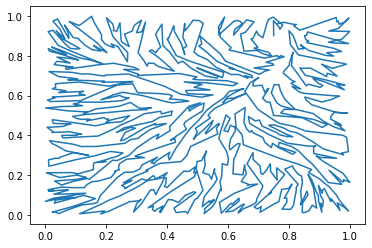

In [3]:
torch.save(NN.state_dict(), 'TSP_50points_60mins')
evaluate(1, 1000, 1, 2)
import matplotlib.pyplot as plt
points = env.points[1].to("cpu").numpy() #[npoints, 2]
order = env.points_sequence[1].to("cpu").numpy() #[npoints]
plt.plot(points[order, 0], points[order, 1])
plt.savefig('1000points_60mins.png')

In [2]:
NN.load_state_dict(torch.load('TSP_50points_60mins'))
train(300000, 50, 400, 8)

6.002200603485107 -2.92370867729187 -5.865228652954102 -2.49151611328125 -12.586662292480469 -12.586700439453125
6.017482757568359 -2.909700870513916 -5.847559928894043 -1.9336395263671875 -8.67966079711914 -8.679607391357422
5.994576454162598 -2.865853786468506 -5.8090057373046875 -2.4296340942382812 -2.7218265533447266 -2.7218189239501953
6.011482238769531 -2.944493055343628 -5.768571376800537 -4.066444396972656 -11.895416259765625 -11.895408630371094
6.028395652770996 -3.0324151515960693 -5.849428176879883 -4.324516296386719 -9.801910400390625 -9.801841735839844
5.978835105895996 -2.837717294692993 -5.705995559692383 -4.208580017089844 -8.219311714172363 -8.219319343566895
5.980225563049316 -3.027543783187866 -5.889387607574463 -2.1778793334960938 -6.200767517089844 -6.200782775878906
5.983242034912109 -2.8638827800750732 -5.805531978607178 -2.0117721557617188 -1.8352622985839844 -1.8352775573730469
5.981146335601807 -2.9300224781036377 -5.832869052886963 -2.540233612060547 -6.00359

5.9830002784729 -2.961106538772583 -5.818667411804199 -2.6401290893554688 -6.390026092529297 -6.390018463134766
5.999714374542236 -2.8935670852661133 -5.781982898712158 -3.577484130859375 -3.86651611328125 -3.8665313720703125
6.011003494262695 -2.8990306854248047 -5.859135627746582 -1.9484467506408691 -6.089691162109375 -6.0897064208984375
5.973609924316406 -2.901559591293335 -5.71877384185791 -3.133026123046875 -3.248462677001953 -3.2484779357910156
5.989277362823486 -2.889704465866089 -5.775372505187988 -3.6850738525390625 -7.0490827560424805 -7.049105644226074
6.004594802856445 -2.9200243949890137 -5.778466701507568 -2.419811248779297 -3.4693832397460938 -3.4693984985351562
6.016351699829102 -2.955369234085083 -5.832130432128906 -2.8356361389160156 -4.598785400390625 -4.59881591796875
6.00617790222168 -2.8736729621887207 -5.690597057342529 -2.538677215576172 -6.345287322998047 -6.345310211181641
6.029472351074219 -2.9579720497131348 -5.9038872718811035 -1.6433525085449219 -4.6320552

6.005524635314941 -2.8972911834716797 -5.7806243896484375 -2.833146333694458 -6.905384063720703 -6.905353546142578
5.999814510345459 -2.9556736946105957 -5.789924621582031 -3.7008628845214844 -6.077152252197266 -6.077152252197266
6.028368949890137 -2.9085772037506104 -5.810567855834961 -2.400747299194336 -10.986236572265625 -10.986160278320312
6.00092887878418 -2.940230369567871 -5.838916778564453 -3.5227813720703125 -2.9813003540039062 -2.9812698364257812
6.005044460296631 -2.925480604171753 -5.859273910522461 -4.076305389404297 -5.393016815185547 -5.393043518066406
6.004593372344971 -2.8300225734710693 -5.616004943847656 -1.7930593490600586 -12.055960655212402 -12.055983543395996
6.005918025970459 -2.9399359226226807 -5.808990955352783 -3.3041305541992188 -3.573375940322876 -3.5733606815338135
6.005887508392334 -2.8414218425750732 -5.580056190490723 -1.8591079711914062 -4.5620880126953125 -4.5621337890625
5.991218566894531 -2.9076788425445557 -5.748410701751709 -5.692815780639648 -4.

6.003777980804443 -2.8569695949554443 -5.624501705169678 -3.159961700439453 -7.539024353027344 -7.539012908935547
5.997466087341309 -2.8235275745391846 -5.652375221252441 -4.652473449707031 -4.479705810546875 -4.479713439941406
5.985413551330566 -2.834944725036621 -5.616482257843018 -1.4878463745117188 -5.2320709228515625 -5.2320709228515625
5.979869365692139 -2.8116137981414795 -5.548098087310791 -2.8314132690429688 -11.615127563476562 -11.615116119384766
5.986092567443848 -2.849855899810791 -5.602005958557129 -2.8198719024658203 -2.1219635009765625 -2.1219711303710938
5.970966815948486 -2.821842908859253 -5.649082183837891 -1.7160453796386719 -3.630870819091797 -3.630870819091797
5.985053539276123 -2.894718647003174 -5.749870777130127 -4.267402648925781 -3.2922325134277344 -3.2922630310058594
5.990246295928955 -2.859172821044922 -5.66065788269043 -2.195209503173828 -8.97006607055664 -8.97006607055664
5.999429702758789 -2.854414224624634 -5.578316688537598 -3.8803834915161133 -1.68220

5.99687385559082 -2.999054431915283 -5.788623809814453 -1.8609161376953125 -6.643797874450684 -6.643755912780762
6.015919208526611 -2.996100902557373 -5.931711196899414 -1.181640625 -7.744131088256836 -7.74412727355957
5.999094009399414 -2.9038000106811523 -5.811987400054932 -2.122992992401123 -5.906414031982422 -5.9063873291015625
6.010817050933838 -2.8844804763793945 -5.623200416564941 -2.974363088607788 -7.152107238769531 -7.152069091796875
5.985189914703369 -2.829939126968384 -5.717737197875977 -4.035953521728516 -1.457143783569336 -1.457113265991211
5.9704155921936035 -2.8918848037719727 -5.824001789093018 -3.707115888595581 -3.142862319946289 -3.1428775787353516
5.969524383544922 -2.843095064163208 -5.624276638031006 -3.2244110107421875 -4.032224655151367 -4.0322113037109375
5.999255657196045 -2.8591554164886475 -5.731415748596191 -2.3460254669189453 -3.1873018741607666 -3.1873133182525635
6.013121604919434 -2.913374662399292 -5.763153076171875 -1.6571760177612305 -7.490875244140

6.013286113739014 -2.8911638259887695 -5.731452465057373 -3.4803199768066406 -2.30841064453125 -2.3084182739257812
5.993095397949219 -2.9136509895324707 -5.827866077423096 -2.679767608642578 -12.450429916381836 -12.450376510620117
5.998410701751709 -2.9076790809631348 -5.78312873840332 -2.229462146759033 -5.220458507537842 -5.220405101776123
5.999804496765137 -2.9296905994415283 -5.7991485595703125 -3.080526351928711 -4.544079780578613 -4.5441179275512695
5.97697114944458 -2.813424587249756 -5.684597015380859 -1.9147974252700806 -6.796600341796875 -6.796592712402344
6.004187107086182 -2.9477789402008057 -5.835758686065674 -3.2927169799804688 -6.537322998046875 -6.537312984466553
5.996926307678223 -2.892972946166992 -5.8084211349487305 -2.2753639221191406 -5.8524169921875 -5.852363586425781
5.970215797424316 -2.8191375732421875 -5.601883411407471 -3.2637293338775635 -1.1488800048828125 -1.148895263671875
5.965949058532715 -2.864356517791748 -5.80141544342041 -5.96578311920166 -5.2360424

5.988557815551758 -2.8590915203094482 -5.707228183746338 -4.399121284484863 -3.5444412231445312 -3.5444564819335938
5.981301307678223 -2.8650245666503906 -5.622189998626709 -3.8223724365234375 -8.603225708007812 -8.603233337402344
5.993009090423584 -2.796868324279785 -5.5686445236206055 -3.957366943359375 -1.1756210327148438 -1.1756668090820312
5.985569953918457 -2.7631165981292725 -5.600785255432129 -4.589088439941406 -10.952667236328125 -10.952774047851562
6.015444278717041 -2.809269905090332 -5.543427467346191 -2.5543346405029297 -3.6477813720703125 -3.64776611328125
6.011279582977295 -2.8056371212005615 -5.750166893005371 -2.249713897705078 -4.279079437255859 -4.279102325439453
6.019939422607422 -2.8997111320495605 -5.6709885597229 -5.173957824707031 -6.629692077636719 -6.629631042480469
6.00187873840332 -2.760903835296631 -5.6262359619140625 -1.8490924835205078 -6.827943801879883 -6.82798957824707
6.017966270446777 -2.8285324573516846 -5.648617267608643 -3.3966331481933594 -7.2402

KeyboardInterrupt: 

37.210811614990234 -557.5096435546875 -971.29345703125 -971.29345703125 -971.29345703125 -971.293212890625


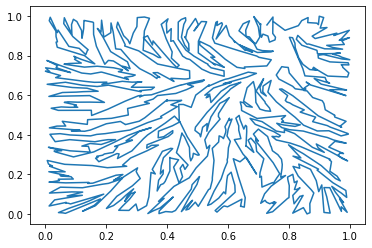

In [3]:
torch.save(NN.state_dict(), 'TSP_50points_90mins')
evaluate(1, 1000, 1, 2)
import matplotlib.pyplot as plt
points = env.points[1].to("cpu").numpy() #[npoints, 2]
order = env.points_sequence[1].to("cpu").numpy() #[npoints]
plt.plot(points[order, 0], points[order, 1])
plt.savefig('1000points_90mins.png')

In [2]:
NN.load_state_dict(torch.load('temp_net'))
train(300000, 50, 400, 8)

5.964839935302734 -2.660510301589966 -5.245273590087891 -1.4627022743225098 -7.371234893798828 -7.371318817138672
6.025508403778076 -2.6095123291015625 -5.2371649742126465 -3.8978099822998047 -4.516839981079102 -4.516839981079102
6.013828754425049 -2.767542600631714 -5.512689590454102 -1.9416580200195312 -5.402053356170654 -5.402038097381592
5.9853129386901855 -2.780775308609009 -5.50568962097168 -2.272049903869629 -2.6080398559570312 -2.6080398559570312
6.002325534820557 -2.696741819381714 -5.278947830200195 -3.4949378967285156 -2.020275115966797 -2.020244598388672
5.969033718109131 -2.7452657222747803 -5.463874816894531 -1.7054214477539062 -3.2923011779785156 -3.2923240661621094
6.002710819244385 -2.7434141635894775 -5.427656173706055 -1.9940147399902344 -10.548032760620117 -10.547964096069336
6.027598857879639 -2.7282211780548096 -5.38634729385376 -2.689067840576172 -5.460104942321777 -5.460101127624512
5.961520671844482 -2.61930513381958 -5.23532772064209 -2.4332075119018555 -4.828

5.9894700050354 -2.716853618621826 -5.333080768585205 -4.3711090087890625 -13.061485290527344 -13.061492919921875
5.998384475708008 -2.7434213161468506 -5.45132303237915 -3.963869094848633 -5.392494201660156 -5.392509460449219
6.000391483306885 -2.6733522415161133 -5.3032121658325195 -2.128612518310547 -7.567050933837891 -7.567035675048828
6.007137775421143 -2.647404193878174 -5.31894588470459 -1.624267578125 -6.124305725097656 -6.1243133544921875
6.008779048919678 -2.8044557571411133 -5.604490280151367 -2.714183807373047 -11.440013885498047 -11.44003677368164
6.0047831535339355 -2.732297420501709 -5.461136817932129 -1.5415287017822266 -2.562187671661377 -2.5621533393859863
5.980172157287598 -2.7128241062164307 -5.482560634613037 -3.063079833984375 -9.164148330688477 -9.16415023803711
6.00455904006958 -2.6988024711608887 -5.352977275848389 -4.017250061035156 -2.920635223388672 -2.9206600189208984
5.997342586517334 -2.687208890914917 -5.4269022941589355 -3.4760055541992188 -2.4545593261

5.971955299377441 -2.5011861324310303 -5.031159400939941 -3.287342071533203 -2.1874775886535645 -2.1874775886535645
6.005236625671387 -2.617563486099243 -5.180158615112305 -3.41400146484375 -3.8796310424804688 -3.8796234130859375
5.976648807525635 -2.5761985778808594 -5.196496486663818 -3.7263107299804688 -2.8074092864990234 -2.807497024536133
5.964447021484375 -2.7248568534851074 -5.332711219787598 -3.0848655700683594 -1.680511474609375 -1.6804733276367188
5.991892337799072 -2.7012484073638916 -5.352985382080078 -3.4603919982910156 -5.135974884033203 -5.135963439941406
5.997817039489746 -2.6085643768310547 -5.136150360107422 -0.9560298919677734 -2.837615966796875 -2.8376007080078125
6.002333641052246 -2.572988271713257 -5.219339847564697 -4.258832931518555 -3.6748390197753906 -3.674846649169922
5.969509124755859 -2.594156503677368 -5.177567005157471 -3.352294921875 -12.667037963867188 -12.667007446289062
6.004180908203125 -2.6667797565460205 -5.30022668838501 -2.811676025390625 -11.06

6.000892162322998 -2.653568744659424 -5.320296287536621 -2.9676895141601562 -4.197502136230469 -4.197441101074219
6.00627326965332 -2.696913719177246 -5.347072124481201 -1.3144989013671875 -2.4951400756835938 -2.4951019287109375
5.974030494689941 -2.6427910327911377 -5.2204270362854 -3.739349365234375 -3.2293548583984375 -3.2293624877929688
5.969521522521973 -2.659514904022217 -5.26848030090332 -3.8611068725585938 -4.189426422119141 -4.189456939697266
6.009838581085205 -2.636162042617798 -5.216204643249512 -2.5140380859375 -3.16945743560791 -3.169461250305176
5.968265056610107 -2.6962761878967285 -5.305639743804932 -1.861384391784668 -1.0519371032714844 -1.0519065856933594
5.987059116363525 -2.6165356636047363 -5.265351295471191 -2.844348907470703 -10.305862426757812 -10.305801391601562
6.000101089477539 -2.725254535675049 -5.485719680786133 -2.7652339935302734 -6.31800651550293 -6.317983627319336
5.97302770614624 -2.736773729324341 -5.42227840423584 -3.4331188201904297 -2.779605865478

6.025417327880859 -2.511378049850464 -5.073278427124023 -3.5463032722473145 -5.952252388000488 -5.952267646789551
5.994479179382324 -2.537292003631592 -5.078740119934082 -2.822490692138672 -1.7479991912841797 -1.7479915618896484
6.00303316116333 -2.5478830337524414 -4.961167335510254 -2.2604522705078125 -3.2493247985839844 -3.2493247985839844
5.981226444244385 -2.513166666030884 -4.9406418800354 -3.639894485473633 -5.775453090667725 -5.775441646575928
5.992260456085205 -2.5653316974639893 -5.047250747680664 -4.8920817375183105 -2.329568862915039 -2.3295536041259766
5.987255573272705 -2.5012521743774414 -4.988868713378906 -0.890106201171875 -7.000797271728516 -7.000804901123047
5.985382556915283 -2.486280679702759 -5.0324387550354 -2.0621414184570312 -8.603904724121094 -8.603981018066406
5.960227012634277 -2.5157692432403564 -4.9579267501831055 -0.7531709671020508 -4.698978424072266 -4.698955535888672
5.963141441345215 -2.6003124713897705 -5.089894771575928 -1.3407096862792969 -4.495079

5.991714954376221 -2.5551321506500244 -5.176125526428223 -1.9169235229492188 -5.382801055908203 -5.382801055908203
5.991106033325195 -2.647264003753662 -5.1291584968566895 -1.22369384765625 -5.3109893798828125 -5.311088562011719
5.984296798706055 -2.5994491577148438 -5.125952243804932 -3.8485498428344727 -4.762705326080322 -4.76275110244751
5.978486061096191 -2.5384998321533203 -5.110312461853027 -3.149505615234375 -4.4361724853515625 -4.436149597167969
5.970130443572998 -2.5232787132263184 -5.051945209503174 -2.7014284133911133 -3.812408447265625 -3.8123703002929688
6.005109786987305 -2.560994863510132 -5.0136566162109375 -2.605121612548828 -5.407299041748047 -5.407329559326172
5.969196796417236 -2.562809467315674 -5.075385093688965 -1.9521560668945312 -1.5719528198242188 -1.5719757080078125
5.978157043457031 -2.591660976409912 -5.126206874847412 -2.069146156311035 -0.4023876190185547 -0.40239524841308594
5.9652838706970215 -2.561723470687866 -5.114889144897461 -2.6930580139160156 -5.

5.99262809753418 -2.6211953163146973 -5.190659046173096 -2.8909988403320312 -5.320642471313477 -5.320650100708008
5.977671146392822 -2.5971641540527344 -5.166633129119873 -1.5828232765197754 -9.492973327636719 -9.492996215820312
5.997813701629639 -2.5078752040863037 -4.994222640991211 -2.6257400512695312 -6.26898193359375 -6.2689971923828125
5.969415664672852 -2.5874276161193848 -5.135719299316406 -1.79376220703125 -2.4631404876708984 -2.4631175994873047
5.983487606048584 -2.6853575706481934 -5.2748260498046875 -2.2555885314941406 -1.8401250839233398 -1.8401556015014648
5.974738597869873 -2.5264647006988525 -5.054818153381348 -3.0325746536254883 -4.376237869262695 -4.376199722290039
5.996338367462158 -2.536189317703247 -5.071930885314941 -2.0380325317382812 -9.515205383300781 -9.515243530273438
5.958298206329346 -2.4399898052215576 -4.963799953460693 -3.2057228088378906 -7.243434906005859 -7.243442535400391
5.976138591766357 -2.492523670196533 -4.907687664031982 -1.663693904876709 -3.8

5.976848602294922 -2.510765790939331 -5.030947685241699 -2.76446533203125 -2.144235610961914 -2.1442508697509766
5.994991779327393 -2.521225690841675 -5.089938640594482 -2.19732666015625 -8.702917098999023 -8.702863693237305
6.013131141662598 -2.424015522003174 -4.878950119018555 -3.0201187133789062 -1.480428695678711 -1.480398178100586
5.9639573097229 -2.4569296836853027 -4.883031368255615 -1.354949951171875 -4.881531715393066 -4.881539344787598
5.971917629241943 -2.468441963195801 -4.874831199645996 -1.4040412902832031 -9.974678039550781 -9.974693298339844
5.942006587982178 -2.429067373275757 -4.813140869140625 -1.41253662109375 -5.26031494140625 -5.260307312011719
5.967830657958984 -2.442063808441162 -4.839141368865967 -1.7349929809570312 -2.9690799713134766 -2.9690418243408203
5.994665622711182 -2.5056750774383545 -4.985904693603516 -1.5728302001953125 -3.4247779846191406 -3.424793243408203
5.968217849731445 -2.477224588394165 -4.935978889465332 -1.603271484375 -3.4572715759277344 

5.984975337982178 -2.4573814868927 -4.939817905426025 -3.1215286254882812 -2.3441200256347656 -2.344127655029297
5.982288837432861 -2.3786869049072266 -4.704444885253906 -0.7759418487548828 -0.6110115051269531 -0.6110267639160156
6.000982761383057 -2.5265698432922363 -4.91562557220459 -0.9247322082519531 -7.396110534667969 -7.396171569824219
5.987688064575195 -2.4738168716430664 -4.856973171234131 -3.256256103515625 -3.398312568664551 -3.3983888626098633
5.99049186706543 -2.495028257369995 -5.004238128662109 -2.9013099670410156 -0.2580451965332031 -0.2580451965332031
5.996434211730957 -2.4209465980529785 -4.842369556427002 -2.120075225830078 -2.98455810546875 -2.9845504760742188
5.962029933929443 -2.5243000984191895 -4.832855701446533 -2.1731643676757812 -6.6389570236206055 -6.638949394226074
5.993471622467041 -2.5763957500457764 -5.034177303314209 -1.2104644775390625 -2.8853302001953125 -2.88531494140625
5.9861626625061035 -2.419748544692993 -4.735342025756836 -1.1440048217773438 -9.5

6.008188724517822 -2.4619193077087402 -4.915268421173096 -1.863668441772461 -3.894319534301758 -3.8943042755126953
5.97456169128418 -2.396148681640625 -4.756210803985596 -1.6877994537353516 -5.054379463195801 -5.054378509521484
5.981624603271484 -2.411100149154663 -4.885874271392822 -3.0829620361328125 -8.293163299560547 -8.293109893798828
5.951150894165039 -2.4522969722747803 -4.904678821563721 -1.1539993286132812 -5.073271751403809 -5.073317050933838
5.959390640258789 -2.4827656745910645 -4.865274906158447 -2.9276199340820312 -2.3803224563598633 -2.3803911209106445
5.974823474884033 -2.468022108078003 -4.975025177001953 -1.8659934997558594 -4.042086601257324 -4.0420637130737305
5.966372966766357 -2.4603264331817627 -4.91603422164917 -2.4692163467407227 -4.35142707824707 -4.351388931274414
6.019464492797852 -2.5124964714050293 -4.928905010223389 -1.9766426086425781 -3.2178573608398438 -3.2178573608398438
5.978675365447998 -2.4816689491271973 -4.916676044464111 -1.9748786687850952 -8.8

5.992653846740723 -2.3932559490203857 -4.8140130043029785 -2.9022693634033203 -9.821344375610352 -9.821346282958984
5.9793314933776855 -2.422459363937378 -4.77156925201416 -1.722808837890625 -5.982048034667969 -5.9820709228515625
5.984354019165039 -2.391766309738159 -4.816721439361572 -3.0136871337890625 -1.9081363677978516 -1.9081287384033203
5.998269081115723 -2.356532335281372 -4.775853633880615 -1.595733642578125 -5.658775329589844 -5.658782958984375
5.963194370269775 -2.355994462966919 -4.708372116088867 -3.661855936050415 -10.000381469726562 -10.000320434570312
5.974078178405762 -2.4324657917022705 -4.781545162200928 -1.49334716796875 -3.3392715454101562 -3.3392868041992188
5.974057674407959 -2.4030275344848633 -4.766883373260498 -1.0419731140136719 -6.286338806152344 -6.286323547363281
5.984886169433594 -2.4885096549987793 -4.8459553718566895 -2.457061767578125 -4.813194274902344 -4.813209533691406
5.9783501625061035 -2.336428165435791 -4.6374430656433105 -2.3651561737060547 -9.

5.992552280426025 -2.4895968437194824 -4.962645530700684 -3.3464813232421875 -7.137668609619141 -7.137676239013672
6.000730037689209 -2.470911979675293 -4.906155586242676 -1.78155517578125 -9.766746520996094 -9.766788482666016
5.979195594787598 -2.4979448318481445 -4.904853343963623 -1.9279708862304688 -3.38140869140625 -3.3813095092773438
5.954470157623291 -2.4737181663513184 -4.782898426055908 -0.7391929626464844 -4.489429473876953 -4.489416122436523
6.007026195526123 -2.3664612770080566 -4.667740821838379 -1.2855453491210938 -4.339731216430664 -4.33970832824707
5.988917827606201 -2.350816488265991 -4.758028507232666 -1.34942626953125 -7.451023101806641 -7.450984954833984
5.99744176864624 -2.3789966106414795 -4.740189552307129 -2.2851624488830566 -7.437568664550781 -7.437553405761719
5.985097408294678 -2.332090377807617 -4.659168243408203 -2.9257562160491943 -5.122123718261719 -5.1220855712890625
6.004662990570068 -2.2468643188476562 -4.547896862030029 -2.6292190551757812 -4.10154914

5.961790561676025 -2.4362337589263916 -4.822083473205566 -2.8158226013183594 -1.1448135375976562 -1.1448135375976562
5.977156639099121 -2.5324833393096924 -5.050814151763916 -1.4388866424560547 -8.055530548095703 -8.05551528930664
5.940247535705566 -2.518871784210205 -4.942707538604736 -2.121522903442383 -6.848217964172363 -6.8482866287231445
5.970900535583496 -2.4338083267211914 -4.8386335372924805 -2.999755859375 -7.101661682128906 -7.101707458496094
6.0135722160339355 -2.4657881259918213 -4.831505298614502 -1.8322010040283203 -5.5289154052734375 -5.5288543701171875
5.971517086029053 -2.4808545112609863 -4.9473490715026855 -1.3079071044921875 -7.016727447509766 -7.016651153564453
5.97033166885376 -2.3767924308776855 -4.6841254234313965 -2.146200180053711 -10.466392517089844 -10.466331481933594
5.97139835357666 -2.4120445251464844 -4.756190776824951 -2.0806808471679688 -2.2647705078125 -2.264812469482422
5.987505912780762 -2.4386510848999023 -4.7750725746154785 -2.2633285522460938 -6.

5.983765125274658 -2.3729405403137207 -4.715015888214111 -4.141323089599609 -5.033088684082031 -5.033103942871094
5.950836658477783 -2.417224884033203 -4.791103839874268 -3.5551605224609375 -7.657358169555664 -7.657381057739258
5.978425025939941 -2.462038516998291 -4.807882308959961 -2.2528076171875 -7.832061767578125 -7.83209228515625
5.989448070526123 -2.385789632797241 -4.755910396575928 -0.6724691390991211 -2.821441650390625 -2.8213577270507812
6.005091190338135 -2.333540201187134 -4.714671611785889 -2.3321495056152344 -10.432647705078125 -10.432640075683594
5.993823528289795 -2.4007632732391357 -4.712982654571533 -3.673304557800293 -3.784942626953125 -3.7849349975585938
5.997053623199463 -2.33811092376709 -4.665607929229736 -3.442012310028076 -8.061012268066406 -8.061027526855469
5.977734088897705 -2.184021472930908 -4.4690728187561035 -2.5579769611358643 -2.7476015090942383 -2.747624397277832
6.004366397857666 -2.2822275161743164 -4.483100414276123 -2.1527938842773438 -2.56358337

5.963614463806152 -2.3874635696411133 -4.821333885192871 -2.132577896118164 -5.744728088378906 -5.74468994140625
5.988685131072998 -2.4605355262756348 -4.868223190307617 -3.5469179153442383 -3.2400741577148438 -3.2401351928710938
5.971497535705566 -2.4492623805999756 -4.847899436950684 -3.2484512329101562 -6.2521209716796875 -6.252166748046875
5.993102073669434 -2.4202115535736084 -4.832197666168213 -1.6422476768493652 -6.902248382568359 -6.902317047119141
5.981463432312012 -2.3982789516448975 -4.811229228973389 -2.547882080078125 -2.7931060791015625 -2.7931060791015625
5.965851783752441 -2.3499953746795654 -4.694615840911865 -1.7057609558105469 -3.336231231689453 -3.3362159729003906
5.95109748840332 -2.3009495735168457 -4.658609867095947 -1.9302029609680176 -0.8249454498291016 -0.8249454498291016
5.980255126953125 -2.3861002922058105 -4.6758713722229 -2.6570334434509277 -5.069313049316406 -5.069374084472656
5.9644975662231445 -2.3485162258148193 -4.689751625061035 -2.3856029510498047 

5.948396682739258 -2.3053030967712402 -4.58089542388916 -2.6305313110351562 -1.8412952423095703 -1.8413105010986328
5.949049949645996 -2.2858521938323975 -4.608841419219971 -3.8555245399475098 -3.540896415710449 -3.540947914123535
5.977924823760986 -2.2482728958129883 -4.381145477294922 -0.5083847045898438 -3.2744522094726562 -3.2744598388671875
5.949857234954834 -2.2832586765289307 -4.551075458526611 -2.6547164916992188 -4.16607666015625 -4.1660919189453125
5.9859619140625 -2.253758430480957 -4.44718599319458 -1.1709880828857422 -1.2156410217285156 -1.2156257629394531
5.989046573638916 -2.2938647270202637 -4.648979187011719 -2.1549072265625 -5.128962516784668 -5.128878593444824
5.947658538818359 -2.4060654640197754 -4.716531753540039 -3.72967267036438 -2.0918216705322266 -2.091867446899414
5.977614402770996 -2.2745134830474854 -4.5437397956848145 -2.5124969482421875 -8.679079055786133 -8.679130554199219
5.981868743896484 -2.3286094665527344 -4.597500801086426 -2.7543601989746094 -3.38

5.95445442199707 -2.3391401767730713 -4.682215213775635 -1.6844711303710938 -8.878772735595703 -8.878704071044922
5.972954750061035 -2.3803765773773193 -4.778142929077148 -1.5710601806640625 -7.242637634277344 -7.2425537109375
5.931441307067871 -2.328540563583374 -4.631985664367676 -1.8765907287597656 -4.8956522941589355 -4.8956217765808105
5.956138610839844 -2.3930981159210205 -4.726329326629639 -3.0394821166992188 -6.14715576171875 -6.147224426269531
5.977606773376465 -2.314401626586914 -4.510133266448975 -2.543079376220703 -9.35906982421875 -9.359001159667969
5.92858362197876 -2.4023430347442627 -4.699082851409912 -3.6110591888427734 -2.4693260192871094 -2.469310760498047
5.982255935668945 -2.336366891860962 -4.622239112854004 -2.3759918212890625 -2.321798324584961 -2.3218135833740234
5.950828552246094 -2.3796932697296143 -4.72791862487793 -2.4008026123046875 -4.205175399780273 -4.205137252807617
5.955399036407471 -2.3692398071289062 -4.728741645812988 -1.7208824157714844 -7.0506019

5.976593971252441 -2.3267478942871094 -4.738663673400879 -2.058002471923828 -3.3129615783691406 -3.3129653930664062
5.972531795501709 -2.3272476196289062 -4.6592841148376465 -2.1455307006835938 -1.7718124389648438 -1.7718353271484375
5.963721752166748 -2.3371238708496094 -4.64350700378418 -3.1668739318847656 -7.490903854370117 -7.49094295501709
5.976083755493164 -2.340014696121216 -4.553782939910889 -1.5506515502929688 -1.7113494873046875 -1.711334228515625
5.977793216705322 -2.331094741821289 -4.600530624389648 -3.6093063354492188 -3.8377389907836914 -3.83773136138916
5.99124002456665 -2.3049957752227783 -4.656917572021484 -2.409679889678955 -1.5904045104980469 -1.5904045104980469
5.973042011260986 -2.2882418632507324 -4.519270420074463 -1.8386077880859375 -4.840950012207031 -4.840965270996094
5.992404460906982 -2.2897098064422607 -4.595607280731201 -2.0999603271484375 -2.2432327270507812 -2.24322509765625
5.954911231994629 -2.2649219036102295 -4.534929275512695 -2.414684295654297 -5.

5.987274169921875 -2.2908196449279785 -4.541411399841309 -2.5102615356445312 -0.29988908767700195 -0.29988908767700195
6.013550758361816 -2.234269142150879 -4.449278831481934 -1.2691192626953125 -11.2210693359375 -11.221023559570312
5.939207077026367 -2.3387937545776367 -4.662360668182373 -2.0026016235351562 -2.5955810546875 -2.5955734252929688
5.992578506469727 -2.250763416290283 -4.5342116355896 -1.0036449432373047 -5.022712707519531 -5.022735595703125
5.973799705505371 -2.1846487522125244 -4.435991287231445 -2.6012420654296875 -2.3597145080566406 -2.359668731689453
5.977108001708984 -2.282262086868286 -4.491076469421387 -1.8289375305175781 -3.407345771789551 -3.407341957092285
5.9758124351501465 -2.2778639793395996 -4.576595306396484 -2.8691577911376953 -5.662881851196289 -5.662866592407227
5.982265472412109 -2.3388772010803223 -4.560850143432617 -2.5030364990234375 -4.7287702560424805 -4.7288007736206055
5.957386493682861 -2.2727813720703125 -4.604259967803955 -0.7669525146484375 -

5.971924781799316 -2.2533795833587646 -4.4351372718811035 -1.7044754028320312 -0.43927574157714844 -0.43927574157714844
5.959898471832275 -2.210099458694458 -4.558829307556152 -2.2802886962890625 -2.8140907287597656 -2.814105987548828
5.978548526763916 -2.2328522205352783 -4.396172046661377 -1.0137252807617188 -3.8212203979492188 -3.8212356567382812
5.96888542175293 -2.164682149887085 -4.345677852630615 -0.9513931274414062 -5.277042388916016 -5.277016639709473
5.970331192016602 -2.188311815261841 -4.391469478607178 -2.988079071044922 -4.8448333740234375 -4.844810485839844
5.964615821838379 -2.1432206630706787 -4.352194786071777 -3.56296443939209 -4.421058654785156 -4.42108154296875
5.955928802490234 -2.1291568279266357 -4.221339225769043 -3.1216201782226562 -2.8198928833007812 -2.8198623657226562
5.963678359985352 -2.2159483432769775 -4.358399868011475 -1.4376260042190552 -3.915435791015625 -3.915435791015625
5.977814674377441 -2.2230026721954346 -4.454531669616699 -3.5837464332580566 

5.968506813049316 -2.2582874298095703 -4.4746880531311035 -1.0421676635742188 -0.9941616058349609 -0.9941473007202148
5.96250581741333 -2.1704750061035156 -4.436985969543457 -2.1631126403808594 -9.315956115722656 -9.315895080566406
5.983734607696533 -2.2679529190063477 -4.497987270355225 -2.7902679443359375 -5.5679779052734375 -5.56805419921875
5.973782062530518 -2.248853921890259 -4.481363773345947 -2.343017578125 -6.083081245422363 -6.083134651184082
5.985718727111816 -2.169015407562256 -4.42987585067749 -2.465869903564453 -6.207283020019531 -6.207252502441406
5.969563007354736 -2.2104110717773438 -4.443019390106201 -1.4083023071289062 -2.9060325622558594 -2.9060630798339844
5.994410991668701 -2.2153220176696777 -4.455350875854492 -3.1622440814971924 -1.6545791625976562 -1.6545867919921875
5.957277774810791 -2.111422300338745 -4.307703495025635 -2.4577484130859375 -10.902732849121094 -10.902656555175781
5.955898284912109 -2.2103798389434814 -4.393518924713135 -1.5006866455078125 -7.0

5.979395389556885 -2.25380539894104 -4.4710307121276855 -1.4012203216552734 -3.5940322875976562 -3.5940017700195312
5.966442584991455 -2.1438493728637695 -4.364601135253906 -1.69659423828125 -7.183612823486328 -7.183559417724609
5.938762187957764 -2.3708620071411133 -4.669487476348877 -2.1513671875 -3.4316940307617188 -3.4317092895507812
5.95624303817749 -2.2571797370910645 -4.600822925567627 -2.37750244140625 -8.402236938476562 -8.4022216796875
5.98015022277832 -2.3091838359832764 -4.5176262855529785 -3.5030956268310547 -4.020698547363281 -4.0207672119140625
5.974836349487305 -2.2468390464782715 -4.461935520172119 -2.5983214378356934 -2.4358386993408203 -2.435792922973633
5.958319664001465 -2.2019903659820557 -4.3516926765441895 -3.058351993560791 -1.1198854446411133 -1.1198854446411133
5.955540180206299 -2.1722609996795654 -4.430329322814941 -2.5897674560546875 -6.773399353027344 -6.773353576660156
5.960565567016602 -2.278064012527466 -4.524500846862793 -2.1215057373046875 -2.2053828

5.957052707672119 -2.2404115200042725 -4.41700553894043 -3.9021453857421875 -2.7680511474609375 -2.7680816650390625
5.950753211975098 -2.1798324584960938 -4.341190814971924 -2.1883468627929688 -1.6114978790283203 -1.6114826202392578
5.958489894866943 -2.1676411628723145 -4.345326900482178 -1.9128952026367188 -12.792566299438477 -12.792566299438477
5.973326683044434 -2.1904308795928955 -4.394347667694092 -3.297269821166992 -4.884574890136719 -4.8845977783203125
5.967851638793945 -2.240227699279785 -4.349194526672363 -2.643634796142578 -3.252751588821411 -3.2526981830596924
5.948697566986084 -2.16628360748291 -4.309732913970947 -2.3837890625 -1.3824596405029297 -1.3824634552001953
5.96168327331543 -2.1789491176605225 -4.3075408935546875 -3.60552978515625 -7.764745712280273 -7.764730453491211
5.984763145446777 -2.2478127479553223 -4.438544750213623 -1.1801564693450928 -1.399383544921875 -1.3993453979492188
5.980424880981445 -2.2034554481506348 -4.386485576629639 -2.3549156188964844 -1.739

5.945920467376709 -2.267028570175171 -4.480034351348877 -1.5208282470703125 -3.2030563354492188 -3.203022003173828
5.943134784698486 -2.2805287837982178 -4.529781818389893 -1.4580230712890625 -4.941555023193359 -4.941524505615234
5.952547550201416 -2.1799418926239014 -4.4171223640441895 -3.1421051025390625 -3.2760448455810547 -3.276073455810547
5.956839561462402 -2.202434539794922 -4.345337390899658 -1.2772750854492188 -1.3486747741699219 -1.3486671447753906
5.945703983306885 -2.1757214069366455 -4.3393144607543945 -1.7385942935943604 -1.584625244140625 -1.5846328735351562
5.957353591918945 -2.252974271774292 -4.549066066741943 -2.2413902282714844 -5.328025817871094 -5.328010559082031
5.97779655456543 -2.1947484016418457 -4.37882137298584 -2.3706741333007812 -5.771690368652344 -5.771659851074219
5.962315559387207 -2.2101311683654785 -4.462996006011963 -1.690765380859375 -1.264068603515625 -1.2640838623046875
5.970925807952881 -2.1943440437316895 -4.355389595031738 -3.7399749755859375 -

5.977574348449707 -2.2102010250091553 -4.396566867828369 -2.8401718139648438 -3.6226806640625 -3.6227035522460938
5.962593078613281 -2.1736044883728027 -4.38909387588501 -1.1299114227294922 -2.3459768295288086 -2.345992088317871
5.980974197387695 -2.2070765495300293 -4.413668155670166 -4.5781402587890625 -5.8837127685546875 -5.883697509765625
5.962706089019775 -2.1680586338043213 -4.315202713012695 -2.92236328125 -3.2896728515625 -3.2896881103515625
5.958322525024414 -2.231658935546875 -4.36397647857666 -2.2204856872558594 -4.724761962890625 -4.7247314453125
5.948055267333984 -2.1523451805114746 -4.348734378814697 -0.7945556640625 -3.6023788452148438 -3.6023712158203125
5.966365814208984 -2.2841126918792725 -4.563553333282471 -1.8922767639160156 -1.1479887962341309 -1.147989273071289
5.974063396453857 -2.225933313369751 -4.338510036468506 -1.9408656358718872 -3.089885711669922 -3.0898704528808594
5.982779026031494 -2.0715370178222656 -4.188699245452881 -2.5265426635742188 -1.6255607604

5.9551825523376465 -2.161180019378662 -4.310823917388916 -3.398223876953125 -5.197242736816406 -5.197235107421875
5.963154315948486 -2.1806392669677734 -4.332789897918701 -2.5369338989257812 -3.359076499938965 -3.35904598236084
5.986057758331299 -2.0875532627105713 -4.240977764129639 -1.6305465698242188 -4.110309600830078 -4.110332489013672
5.956193923950195 -2.13131046295166 -4.300702095031738 -0.7292671203613281 -4.052679061889648 -4.052724838256836
5.986351013183594 -2.0983903408050537 -4.171513557434082 -2.3932952880859375 -3.350139617919922 -3.3501548767089844
5.918100833892822 -2.1392507553100586 -4.169638633728027 -1.8906784057617188 -5.785697937011719 -5.7856597900390625
5.962642669677734 -2.1817126274108887 -4.349202632904053 -2.386599540710449 -4.166603088378906 -4.166572570800781
5.971968650817871 -2.186258554458618 -4.244854927062988 -3.2442474365234375 -2.440779447555542 -2.4407336711883545
5.974531650543213 -2.194796323776245 -4.335643768310547 -2.9584197998046875 -6.1492

5.963629245758057 -2.0915868282318115 -4.213443756103516 -2.255126953125 -1.8078079223632812 -1.8078079223632812
5.986954689025879 -2.1406311988830566 -4.180630683898926 -3.0881175994873047 -8.470643043518066 -8.470688819885254
5.975535869598389 -2.0603652000427246 -4.025252342224121 -1.1202507019042969 -1.470304012298584 -1.470334529876709
5.947401523590088 -2.0660972595214844 -4.050088882446289 -2.226238250732422 -5.916328430175781 -5.916343688964844
5.96159029006958 -2.0787651538848877 -4.0111236572265625 -2.8498735427856445 -3.0194549560546875 -3.01947021484375
5.958956241607666 -1.9891360998153687 -3.988774299621582 -1.6467514038085938 -3.154264450073242 -3.154165267944336
5.959386348724365 -2.0445101261138916 -4.004247188568115 -1.9990177154541016 -11.610885620117188 -11.610855102539062
5.967780590057373 -2.03253173828125 -4.1240153312683105 -1.7380685806274414 -1.8853950500488281 -1.8854103088378906
5.970065593719482 -2.0540573596954346 -4.127564430236816 -2.0566864013671875 -5.

5.94045352935791 -2.0951669216156006 -4.196937084197998 -1.2893409729003906 -8.083187103271484 -8.083232879638672
5.976025104522705 -2.1368556022644043 -4.324952125549316 -1.912200927734375 -0.8071174621582031 -0.8071136474609375
5.969851016998291 -2.1399080753326416 -4.195590972900391 -2.433929443359375 -6.020606994628906 -6.020637512207031
5.957537651062012 -2.2228074073791504 -4.361207485198975 -2.5661392211914062 -4.574990272521973 -4.575005531311035
5.957773685455322 -2.1334211826324463 -4.257580757141113 -0.5139446258544922 -3.549628257751465 -3.549647331237793
5.959499359130859 -2.139526605606079 -4.276782035827637 -3.430389404296875 -8.389572143554688 -8.389575958251953
5.947481632232666 -2.1681337356567383 -4.3217034339904785 -0.7211532592773438 -5.095348358154297 -5.095363616943359
5.949097633361816 -2.114168643951416 -4.1269755363464355 -2.509593963623047 -4.864280700683594 -4.864288330078125
5.955207347869873 -2.002835988998413 -3.940798282623291 -2.1688613891601562 -9.3260

5.971047401428223 -2.135474443435669 -4.2354960441589355 -2.7259597778320312 -1.8546295166015625 -1.8546218872070312
5.965224266052246 -2.163600206375122 -4.376482963562012 -1.4301528930664062 -4.184487819671631 -4.184488296508789
5.942821502685547 -2.1181371212005615 -4.334446907043457 -1.9389572143554688 -2.93023681640625 -2.9302520751953125
5.9977922439575195 -2.1844210624694824 -4.266233921051025 -4.833253860473633 -3.7936630249023438 -3.7936439514160156
5.965848445892334 -2.1609692573547363 -4.308594226837158 -2.8062820434570312 -6.707099914550781 -6.707115173339844
5.982602596282959 -2.175990581512451 -4.337563991546631 -1.0230064392089844 -2.8294143676757812 -2.8294143676757812
5.966790676116943 -2.1079800128936768 -4.236843109130859 -3.3524208068847656 -2.6925957202911377 -2.6925954818725586
5.982324123382568 -2.0882527828216553 -4.185345649719238 -1.6340866088867188 -3.0439529418945312 -3.043914794921875
5.949119567871094 -2.0703141689300537 -4.189198017120361 -1.8653469085693

5.962033748626709 -2.1395108699798584 -4.172847270965576 -2.0756607055664062 -2.6189041137695312 -2.6189498901367188
5.957438945770264 -2.1538290977478027 -4.266005039215088 -1.611907958984375 -3.0571975708007812 -3.0571975708007812
5.974385738372803 -2.1779539585113525 -4.292938709259033 -1.1750411987304688 -3.0950088500976562 -3.0949935913085938
5.975217342376709 -2.1323485374450684 -4.270313739776611 -2.95672607421875 -3.6270828247070312 -3.627044677734375
5.959497928619385 -2.2603306770324707 -4.446805000305176 -3.3402462005615234 -3.0477447509765625 -3.0477218627929688
5.972786903381348 -2.202075719833374 -4.38883638381958 -1.8227272033691406 -2.996452569961548 -2.996471643447876
5.963578224182129 -2.1596357822418213 -4.264621257781982 -4.299766540527344 -4.048974990844727 -4.048990249633789
5.946222305297852 -2.0776166915893555 -4.116237640380859 -3.301375389099121 -10.79153823852539 -10.791568756103516
5.983172416687012 -2.092135190963745 -4.223618030548096 -1.0328102111816406 -

5.982648849487305 -2.1071248054504395 -4.131738662719727 -1.9129266738891602 -7.2710280418396 -7.271119594573975
5.96135950088501 -2.0549161434173584 -4.058365821838379 -1.138218879699707 -3.8743896484375 -3.8744049072265625
5.967604637145996 -2.094007968902588 -4.129333972930908 -0.6475563049316406 -1.4650459289550781 -1.4650535583496094
5.924763202667236 -2.049487829208374 -4.150336742401123 -2.541348457336426 -2.744138717651367 -2.7440624237060547
5.973524570465088 -2.1080832481384277 -4.206505298614502 -2.3102097511291504 -0.6362571716308594 -0.6362571716308594
5.969934463500977 -2.076033353805542 -4.091228485107422 -1.0468692779541016 -5.206703186035156 -5.206718444824219
5.942514419555664 -2.061319589614868 -4.163635730743408 -2.343167304992676 -2.3068389892578125 -2.3068389892578125
5.967090129852295 -2.1257872581481934 -4.251495838165283 -3.6170654296875 -2.8751373291015625 -2.8750762939453125
5.97535514831543 -2.105487108230591 -4.2729082107543945 -2.613971710205078 -8.0352020

5.9674553871154785 -2.027087450027466 -4.066618919372559 -2.503490447998047 -5.368329048156738 -5.368283271789551
5.959197998046875 -2.073335886001587 -4.216929912567139 -1.5870156288146973 -3.6383819580078125 -3.63836669921875
5.969460964202881 -2.0880112648010254 -4.130564212799072 -2.934011459350586 -4.407577991485596 -4.407654285430908
5.943401336669922 -2.0711114406585693 -4.102246284484863 -1.7704086303710938 -1.8874130249023438 -1.8874092102050781
5.97551155090332 -1.9608535766601562 -3.9820032119750977 -2.0262069702148438 -1.5829620361328125 -1.5829925537109375
5.9537577629089355 -2.122434139251709 -4.161442279815674 -0.41597747802734375 -5.4253387451171875 -5.425361633300781
5.97442626953125 -2.0498671531677246 -4.090686321258545 -4.110008239746094 -5.7232666015625 -5.723217010498047
5.979287147521973 -2.144087076187134 -4.160444259643555 -1.5645294189453125 -4.808858871459961 -4.808868408203125
5.9859771728515625 -2.1627776622772217 -4.161136150360107 -2.6027297973632812 -1.5

5.94630241394043 -2.0546188354492188 -4.06068754196167 -2.4772987365722656 -2.5338287353515625 -2.533794403076172
5.943562030792236 -2.048657178878784 -4.104796886444092 -2.6925125122070312 -2.7468929290771484 -2.7468929290771484
5.95571756362915 -2.0443971157073975 -4.101761341094971 -2.45339298248291 -2.3203582763671875 -2.32037353515625
5.947928428649902 -2.0794246196746826 -4.156688213348389 -1.5825552940368652 -2.9559097290039062 -2.9559249877929688
5.97824764251709 -2.007594347000122 -3.979358196258545 -2.5551815032958984 -3.990793228149414 -3.990793228149414
5.98045539855957 -2.03963303565979 -4.094590187072754 -1.8492164611816406 -1.7369422912597656 -1.7369308471679688
5.9702043533325195 -1.9949265718460083 -4.033730506896973 -1.6088180541992188 -4.315399169921875 -4.315345764160156
5.976478099822998 -2.1044182777404785 -4.254909038543701 -2.504222869873047 -1.1313209533691406 -1.1313438415527344
5.928609371185303 -2.0922834873199463 -4.184164047241211 -2.8456764221191406 -4.82

5.95277214050293 -2.214191198348999 -4.3740339279174805 -1.7464408874511719 -4.525693893432617 -4.525663375854492
5.939301490783691 -2.0950939655303955 -4.159496784210205 -3.3482437133789062 -2.267881393432617 -2.2679271697998047
5.94579553604126 -2.1323037147521973 -4.209415435791016 -2.3044071197509766 -4.032550811767578 -4.032520294189453
5.985923767089844 -2.0797815322875977 -4.082602500915527 -3.0681838989257812 -3.3924522399902344 -3.392475128173828
5.959963321685791 -2.0580601692199707 -4.017064094543457 -1.9595909118652344 -4.026756286621094 -4.026802062988281
5.986860275268555 -2.1141035556793213 -4.113640785217285 -1.3266372680664062 -1.6466903686523438 -1.646636962890625
5.985973834991455 -1.9199694395065308 -3.883373975753784 -1.0733489990234375 -4.23895263671875 -4.238975524902344
5.941965579986572 -2.0497848987579346 -4.084918975830078 -2.5868334770202637 -7.133640289306641 -7.133655548095703
5.937999248504639 -2.1208996772766113 -4.149405479431152 -1.5589447021484375 -5.

5.939237117767334 -1.988191843032837 -3.9628636837005615 -2.247264862060547 -1.9198287725448608 -1.9198135137557983
5.952342510223389 -1.9947478771209717 -3.9640750885009766 -2.0504934787750244 -5.154533386230469 -5.154594421386719
5.936666965484619 -1.997426152229309 -3.9635539054870605 -0.8721609115600586 -3.300029754638672 -3.3000736236572266
5.9822235107421875 -2.0679523944854736 -4.1454548835754395 -1.4279632568359375 -3.8996105194091797 -3.899595260620117
5.953903675079346 -2.103253126144409 -4.119194984436035 -1.6855010986328125 -4.628330230712891 -4.628330230712891
5.971372604370117 -2.144315481185913 -4.334550857543945 -2.8388214111328125 -8.633561134338379 -8.633599281311035
5.957330226898193 -2.2032577991485596 -4.3377461433410645 -1.5409278869628906 -3.333526611328125 -3.333526611328125
5.978411674499512 -2.274247646331787 -4.4489216804504395 -2.249927520751953 -6.258594512939453 -6.258548736572266
5.955784797668457 -2.1785407066345215 -4.358170032501221 -2.538503646850586 

5.962347507476807 -2.0075573921203613 -4.089688301086426 -1.304464340209961 -3.3354339599609375 -3.3354721069335938
5.947276592254639 -2.000225067138672 -3.9798436164855957 -0.8207550048828125 -2.8255996704101562 -2.8256072998046875
5.954353332519531 -1.9604146480560303 -4.024815082550049 -1.9015979766845703 -3.9150047302246094 -3.915050506591797
5.954504489898682 -2.0304477214813232 -3.977836847305298 -2.2915191650390625 -4.118473052978516 -4.118503570556641
5.942160606384277 -1.9852252006530762 -3.9350321292877197 -1.6629104614257812 -3.1319351196289062 -3.1318740844726562
5.957322120666504 -1.9736933708190918 -3.9122180938720703 -3.405919075012207 -4.502292633056641 -4.502216339111328
5.966715335845947 -1.9401226043701172 -3.917992353439331 -1.3113842010498047 -4.597724914550781 -4.597686767578125
5.966481685638428 -1.961981177330017 -4.0159912109375 -3.439105987548828 -3.7726058959960938 -3.7725830078125
5.934009075164795 -1.9282493591308594 -3.89208984375 -1.5615019798278809 -2.66

5.91494083404541 -2.091845750808716 -4.236082553863525 -1.9347610473632812 -3.2501068115234375 -3.250091552734375
5.944272518157959 -2.081570625305176 -4.192929267883301 -2.556804656982422 -2.2817821502685547 -2.2817649841308594
5.984783172607422 -2.146336078643799 -4.184276580810547 -2.233917236328125 -5.79102897644043 -5.791013717651367
5.9612016677856445 -2.1329503059387207 -4.2269134521484375 -2.387624740600586 -6.971744537353516 -6.971836090087891
5.955014705657959 -2.0720059871673584 -4.065957546234131 -1.5561370849609375 -3.010467529296875 -3.01043701171875
5.93787956237793 -2.0778448581695557 -4.144510746002197 -2.0894317626953125 -3.3158798217773438 -3.31591796875
5.936623573303223 -2.0466690063476562 -4.05641508102417 -2.0045700073242188 -4.605827331542969 -4.6058197021484375
5.946500778198242 -2.049083709716797 -4.040214538574219 -0.35152435302734375 -5.860481262207031 -5.860466003417969
5.942468643188477 -2.0128135681152344 -3.9674041271209717 -4.382854461669922 -2.75459265

5.961219787597656 -2.033437490463257 -3.9918012619018555 -2.3671741485595703 -7.284668922424316 -7.284676551818848
5.971786975860596 -2.0140483379364014 -4.032492160797119 -2.531949996948242 -8.255741119384766 -8.255680084228516
5.969759464263916 -2.0209038257598877 -4.019268035888672 -3.3666458129882812 -5.647306442260742 -5.64735221862793
5.931216716766357 -2.0749590396881104 -4.095212936401367 -1.2315902709960938 -3.754505157470703 -3.754528045654297
5.963890075683594 -1.960201621055603 -3.8677024841308594 -1.5330848693847656 -5.357643127441406 -5.3577117919921875
5.9711198806762695 -1.9960840940475464 -4.0350165367126465 -2.0103683471679688 -3.4117584228515625 -3.4116973876953125
5.968295574188232 -2.010296106338501 -4.048959732055664 -1.3391189575195312 -2.1498794555664062 -2.1499099731445312
5.969184398651123 -2.0661187171936035 -3.9841678142547607 -1.6791419982910156 -4.692386627197266 -4.692371368408203
5.989725112915039 -1.9688235521316528 -3.9545931816101074 -2.50111007690429

5.927111625671387 -2.0472612380981445 -4.086126327514648 -2.2439918518066406 -1.7085952758789062 -1.7085952758789062
5.954319953918457 -2.0986340045928955 -4.048112869262695 -1.4621429443359375 -2.7638473510742188 -2.7638168334960938
5.959807395935059 -2.0587575435638428 -4.036136150360107 -1.2243804931640625 -3.6500091552734375 -3.6500167846679688
5.961001873016357 -2.002908945083618 -3.9223227500915527 -3.341205596923828 -4.81512451171875 -4.81500244140625
5.954838752746582 -2.0243043899536133 -4.0287652015686035 -0.6643180847167969 -3.596308469772339 -3.5963008403778076
5.955334186553955 -1.979018211364746 -3.8659396171569824 -2.747303009033203 -11.650344848632812 -11.650337219238281
5.941245079040527 -2.0808629989624023 -3.97255539894104 -3.6911439895629883 -2.3436450958251953 -2.3436145782470703
5.927998065948486 -1.9222337007522583 -3.895744562149048 -1.3386993408203125 -1.5149574279785156 -1.5149421691894531
5.962409496307373 -2.0169646739959717 -3.9498395919799805 -2.1325683593

5.958372116088867 -1.861060619354248 -3.7531285285949707 -1.7482566833496094 -5.290275573730469 -5.290313720703125
5.949169635772705 -1.97567880153656 -3.907961368560791 -2.4633712768554688 -2.154632568359375 -2.154632568359375
5.949573040008545 -1.9322316646575928 -3.9050302505493164 -1.0387725830078125 -4.202091217041016 -4.2021026611328125
5.954867839813232 -1.903429627418518 -3.8174116611480713 -2.11181640625 -3.951112747192383 -3.9510669708251953
5.929599285125732 -1.9063552618026733 -3.709064245223999 -1.9251899719238281 -3.4426307678222656 -3.4426422119140625
5.954422473907471 -1.922544002532959 -3.8060238361358643 -4.7595977783203125 -1.2308273315429688 -1.2308578491210938
5.919416427612305 -1.9058603048324585 -3.9518051147460938 -1.4449119567871094 -4.110952377319336 -4.110906600952148
5.943638801574707 -2.0199828147888184 -4.037142276763916 -3.0035858154296875 -4.927530288696289 -4.927591323852539
5.970301151275635 -2.062117099761963 -4.113633632659912 -3.446378707885742 -10.

5.925751686096191 -1.9678641557693481 -4.0075554847717285 -1.6634101867675781 -10.480331420898438 -10.480422973632812
5.95401668548584 -1.9556435346603394 -3.8983676433563232 -1.8591690063476562 -3.7938919067382812 -3.7939224243164062
5.944902420043945 -2.012765645980835 -4.011516571044922 -1.8207550048828125 -5.196815490722656 -5.196800231933594
5.945841312408447 -2.017685890197754 -3.9993791580200195 -0.4250755310058594 -4.883392333984375 -4.883460998535156
5.977675437927246 -2.041503667831421 -3.9891133308410645 -2.3294296264648438 -1.8319091796875 -1.8319091796875
5.941409587860107 -2.1116244792938232 -4.142788887023926 -1.5413017272949219 -4.231884002685547 -4.231830596923828
5.949653625488281 -1.990405559539795 -4.033599853515625 -2.8031768798828125 -1.849456787109375 -1.849456787109375
5.962948322296143 -1.9954454898834229 -4.0065765380859375 -2.1995086669921875 -3.4106388092041016 -3.410634994506836
5.910942077636719 -2.020472288131714 -4.057250022888184 -3.3425655364990234 -6.

5.9330668449401855 -1.9033340215682983 -3.833585023880005 -2.4993743896484375 -3.1259841918945312 -3.1259231567382812
5.957530498504639 -1.9899190664291382 -3.8293120861053467 -3.3774871826171875 -0.9315567016601562 -0.9315567016601562
5.955585956573486 -1.879046082496643 -3.812973976135254 -3.4941062927246094 -1.0843467712402344 -1.0843467712402344
5.959872722625732 -1.9385650157928467 -3.85774302482605 -3.0669631958007812 -3.8310317993164062 -3.8310317993164062
5.943769454956055 -1.939186453819275 -3.9055516719818115 -2.4064865112304688 -1.8625602722167969 -1.8625602722167969
5.954687595367432 -1.9790194034576416 -3.898517608642578 -1.23187255859375 -4.592559814453125 -4.592582702636719
5.956918239593506 -1.9929015636444092 -3.9188876152038574 -0.45726776123046875 -2.947063446044922 -2.9470558166503906
5.960831165313721 -2.0129780769348145 -4.031399726867676 -2.7697863578796387 -2.038881301879883 -2.0388965606689453
5.966712474822998 -2.002997636795044 -4.0671281814575195 -2.08113861

5.964508533477783 -1.985145092010498 -3.8738255500793457 -1.108489990234375 -4.910270690917969 -4.910240173339844
5.976651668548584 -1.8830851316452026 -3.781106948852539 -2.7904739379882812 -6.8896636962890625 -6.889621734619141
5.930237770080566 -1.9467756748199463 -3.8445112705230713 -1.7140426635742188 -4.468284606933594 -4.468315124511719
5.943874359130859 -2.0058059692382812 -3.969169855117798 -0.7239398956298828 -8.188730239868164 -8.188684463500977
5.948392868041992 -1.926707148551941 -3.8446896076202393 -1.1695117950439453 -3.834442138671875 -3.8343963623046875
5.952057838439941 -1.9005950689315796 -3.8477392196655273 -1.2966232299804688 -0.1911163330078125 -0.1911163330078125
5.9640793800354 -1.888844609260559 -3.7802066802978516 -1.8905487060546875 -2.509504795074463 -2.5094704627990723
5.9179606437683105 -1.8853263854980469 -3.7976574897766113 -3.9275684356689453 -3.711700439453125 -3.711639404296875
5.951211452484131 -1.9284061193466187 -3.849179744720459 -1.06195068359375

5.949652194976807 -1.973233938217163 -3.853245735168457 -1.61407470703125 -2.077911376953125 -2.077911376953125
5.944685459136963 -2.078660488128662 -4.149158954620361 -2.5729751586914062 -3.1927261352539062 -3.1926803588867188
5.950237274169922 -2.1127920150756836 -4.181187152862549 -1.7749254703521729 -4.015045166015625 -4.015052795410156
5.955093860626221 -2.025456428527832 -4.150147914886475 -2.5451011657714844 -4.110635280609131 -4.110612392425537
5.940876483917236 -1.9440245628356934 -3.9417333602905273 -1.588653564453125 -2.9930572509765625 -2.9930419921875
5.934593200683594 -1.9787594079971313 -3.9062304496765137 -1.679962158203125 -3.755472183227539 -3.7554244995117188
5.958620548248291 -1.8717210292816162 -3.823272228240967 -2.551217555999756 -4.086778163909912 -4.08676290512085
5.936133861541748 -1.8967770338058472 -3.8090782165527344 -2.586761474609375 -1.8718299865722656 -1.8718299865722656
5.945766448974609 -1.8764913082122803 -3.763823986053467 -0.6259727478027344 -1.233

5.927910804748535 -1.9607207775115967 -3.8606019020080566 -2.3051986694335938 -4.392576217651367 -4.39256477355957
5.955716609954834 -1.9567407369613647 -3.972017288208008 -1.7030181884765625 -1.2151870727539062 -1.2151718139648438
5.945798397064209 -1.9271001815795898 -3.8820924758911133 -2.4713516235351562 -2.4066238403320312 -2.4066238403320312
5.92114782333374 -1.8789727687835693 -3.7289013862609863 -0.46672821044921875 -2.5262794494628906 -2.526294708251953
5.954277038574219 -1.8941500186920166 -3.744541645050049 -1.698512077331543 -3.7060775756835938 -3.7060623168945312
5.941165447235107 -1.8346095085144043 -3.608819007873535 -1.3163223266601562 -2.4343643188476562 -2.4343948364257812
5.937234878540039 -1.9375977516174316 -3.845004081726074 -2.5624473094940186 -2.4584121704101562 -2.4583969116210938
5.963454246520996 -1.9351351261138916 -3.8634092807769775 -1.4397525787353516 -7.595354080200195 -7.595338821411133
5.947468280792236 -1.9276179075241089 -3.8571064472198486 -2.372598

5.933909893035889 -1.9317775964736938 -3.8648931980133057 -0.686492919921875 -5.888343811035156 -5.888313293457031
5.985774993896484 -1.8891433477401733 -3.766146659851074 -1.73675537109375 -3.7648773193359375 -3.7648086547851562
5.951239109039307 -1.9024600982666016 -3.80692458152771 -2.106027126312256 -0.3611488342285156 -0.3611640930175781
5.963680267333984 -1.8914788961410522 -3.7254586219787598 -1.7874717712402344 -3.0859508514404297 -3.0859832763671875
5.971357345581055 -1.8361724615097046 -3.671229124069214 -2.901423454284668 -2.895878314971924 -2.8958935737609863
5.988246917724609 -1.8494281768798828 -3.7168428897857666 -1.8980941772460938 -2.4795989990234375 -2.4795684814453125
5.95710563659668 -1.8674663305282593 -3.695880889892578 -0.30936431884765625 -3.3531723022460938 -3.3531265258789062
5.939470291137695 -1.8285530805587769 -3.7024152278900146 -1.9359855651855469 -7.090869903564453 -7.090839385986328
5.947588920593262 -1.8620007038116455 -3.6973583698272705 -1.0351982116

5.942105770111084 -1.8971608877182007 -3.791234016418457 -3.0616531372070312 -0.8201923370361328 -0.8201999664306641
5.964670181274414 -1.9320766925811768 -3.823885917663574 -0.4586067199707031 -9.512344360351562 -9.512313842773438
5.96769905090332 -1.931684970855713 -3.8415191173553467 -1.561753273010254 -10.846960067749023 -10.846982955932617
5.959493160247803 -1.8772082328796387 -3.7318522930145264 -0.655303955078125 -1.4069361686706543 -1.4069056510925293
5.925822734832764 -1.927544355392456 -3.9048409461975098 -1.2472457885742188 -2.8164596557617188 -2.8165054321289062
5.959181785583496 -1.9009246826171875 -3.838366985321045 -1.774226188659668 -4.996486663818359 -4.996509552001953
5.942653179168701 -1.9698281288146973 -3.8815512657165527 -1.9837226867675781 -4.951911926269531 -4.951866149902344
5.902857303619385 -1.9190353155136108 -3.8409039974212646 -1.4895095825195312 -1.0339574813842773 -1.0339422225952148
5.914742469787598 -1.86630117893219 -3.711118221282959 -1.1209907531738

5.911075115203857 -1.855366826057434 -3.655775308609009 -2.2085609436035156 -2.553277015686035 -2.5533084869384766
5.951765537261963 -1.8923110961914062 -3.807549476623535 -3.0259323120117188 -1.4520704746246338 -1.4520552158355713
5.942431449890137 -1.8932812213897705 -3.7897090911865234 -1.9714946746826172 -3.305379867553711 -3.3053646087646484
5.947902679443359 -1.8579663038253784 -3.7118825912475586 -0.8077926635742188 -4.574562072753906 -4.574516296386719
5.95242166519165 -1.9523272514343262 -3.8515303134918213 -2.568695068359375 -5.25672721862793 -5.25672721862793
5.95473051071167 -1.890857458114624 -3.758721351623535 -2.6770401000976562 -1.4011383056640625 -1.401123046875
5.927896499633789 -1.809948444366455 -3.6726632118225098 -2.6628456115722656 -1.145871639251709 -1.145841121673584
5.941565036773682 -1.8811079263687134 -3.689462423324585 -2.062774658203125 -3.0712738037109375 -3.0712814331054688
5.95781135559082 -1.9365044832229614 -3.8323814868927 -3.0683212280273438 -5.6250

5.943318843841553 -1.8987679481506348 -3.7839250564575195 -0.8324933052062988 -2.002506971359253 -2.002506971359253
5.941246032714844 -1.836616039276123 -3.6411361694335938 -1.9679031372070312 -3.2637786865234375 -3.26373291015625
5.930763244628906 -1.827562689781189 -3.6409475803375244 -1.7281341552734375 -2.9560046195983887 -2.9560046195983887
5.954036712646484 -1.913784384727478 -3.7516214847564697 -1.7040061950683594 -3.0113210678100586 -3.0113325119018555
5.959134578704834 -1.8120776414871216 -3.611271619796753 -2.4439773559570312 -1.7175636291503906 -1.7175483703613281
5.964691162109375 -1.8952748775482178 -3.755984306335449 -1.069538950920105 -3.14862060546875 -3.1486053466796875
5.939278602600098 -1.8644368648529053 -3.691359519958496 -1.9308900833129883 -3.1236495971679688 -3.1236648559570312
5.94447660446167 -1.8693218231201172 -3.6749815940856934 -1.4566612243652344 -3.0580978393554688 -3.0580673217773438
5.9486846923828125 -1.856119990348816 -3.7486777305603027 -1.068176269

5.953978061676025 -1.8996059894561768 -3.7453458309173584 -1.4993972778320312 -6.338493347167969 -6.338401794433594
5.926387310028076 -1.9477462768554688 -3.8276538848876953 -0.941680908203125 -2.2262725830078125 -2.2263031005859375
5.9365458488464355 -1.872089147567749 -3.691930055618286 -1.6566619873046875 -4.629453659057617 -4.629423141479492
5.938765525817871 -1.9100418090820312 -3.8872642517089844 -1.3593902587890625 -3.4623336791992188 -3.4623565673828125
5.932017803192139 -2.013307809829712 -3.989152431488037 -2.894460678100586 -2.900052309036255 -2.9000751972198486
5.964325428009033 -1.9552175998687744 -3.8709402084350586 -3.168621063232422 -3.0576095581054688 -3.0576248168945312
5.8862433433532715 -1.8990938663482666 -3.7392475605010986 -0.9402389526367188 -3.102203369140625 -3.1021652221679688
5.945367336273193 -1.9352413415908813 -3.8678138256073 -2.744516372680664 -8.136154174804688 -8.136184692382812
5.909605503082275 -1.8660701513290405 -3.7823939323425293 -1.976781845092

5.939451217651367 -1.8963075876235962 -3.7039260864257812 -1.3224191665649414 -3.2976760864257812 -3.29766845703125
5.961037635803223 -1.8097023963928223 -3.539489269256592 -1.7048187255859375 -5.296977996826172 -5.296970367431641
5.93833589553833 -1.876179814338684 -3.8321797847747803 -1.2360000610351562 -2.222869873046875 -2.2229156494140625
5.970738887786865 -1.8580870628356934 -3.7014153003692627 -1.484527587890625 -2.011819839477539 -2.0118274688720703
5.939939022064209 -1.8990628719329834 -3.738856792449951 -2.0519866943359375 -3.4679412841796875 -3.46795654296875
5.937408924102783 -1.965541958808899 -3.9073448181152344 -3.1072540283203125 -2.1695022583007812 -2.1694488525390625
5.964816570281982 -1.9471081495285034 -3.9315459728240967 -2.077800750732422 -6.566944599151611 -6.566899299621582
5.961796283721924 -1.9894968271255493 -3.9497034549713135 -2.2163772583007812 -7.026775360107422 -7.026760101318359
5.938621520996094 -1.9803179502487183 -3.92167592048645 -1.635040283203125 

5.957801818847656 -1.9131417274475098 -3.830880880355835 -1.0814170837402344 -2.1492958068847656 -2.1493186950683594
5.933169841766357 -1.9565211534500122 -3.865995407104492 -3.023235321044922 -3.6097793579101562 -3.6098175048828125
5.934450626373291 -1.8708648681640625 -3.7707889080047607 -3.447673797607422 -2.404386520385742 -2.4044017791748047
5.956131458282471 -1.8867799043655396 -3.7597553730010986 -2.052379608154297 -5.170448303222656 -5.170478820800781
5.9207048416137695 -1.887722373008728 -3.7054316997528076 -2.0568885803222656 -1.2728729248046875 -1.272857666015625
5.942725658416748 -1.8957815170288086 -3.7551653385162354 -2.3482742309570312 -0.5887670516967773 -0.5887670516967773
5.950980186462402 -1.826820969581604 -3.7036705017089844 -3.8276214599609375 -2.820280075073242 -2.8202953338623047
5.950619220733643 -1.866952896118164 -3.6954362392425537 -2.668095350265503 -5.514503479003906 -5.5145721435546875
5.942736625671387 -1.8544872999191284 -3.6714658737182617 -2.101333618

5.944689750671387 -1.7889022827148438 -3.5638699531555176 -2.899312973022461 -3.3253793716430664 -3.3253793716430664
5.925984859466553 -1.801208734512329 -3.5845909118652344 -1.3542900085449219 -4.551334381103516 -4.551334381103516
5.938942909240723 -1.8209633827209473 -3.6220054626464844 -1.2669677734375 -6.967923164367676 -6.967968940734863
5.944216251373291 -1.8723461627960205 -3.6868693828582764 -2.4470367431640625 -3.9520645141601562 -3.9520111083984375
5.952571868896484 -1.835781216621399 -3.6984643936157227 -2.8988704681396484 -4.2102508544921875 -4.2102813720703125
5.933460712432861 -1.78599214553833 -3.594330310821533 -0.7446279525756836 -0.584197998046875 -0.5842132568359375
5.952212810516357 -1.9018282890319824 -3.6796505451202393 -1.6417922973632812 -0.3607330322265625 -0.3607177734375
5.935104846954346 -1.8307278156280518 -3.693159580230713 -1.4220428466796875 -3.8127784729003906 -3.812847137451172
5.964906692504883 -1.86992609500885 -3.6293938159942627 -0.4600238800048828

5.960822582244873 -1.8764269351959229 -3.721364736557007 -2.36187744140625 -3.390491485595703 -3.3905296325683594
5.962230682373047 -1.9075289964675903 -3.741835594177246 -2.401435375213623 -6.91546630859375 -6.9154815673828125
5.922574520111084 -1.8409007787704468 -3.733830451965332 -1.3671503067016602 -0.4812889099121094 -0.4812583923339844
5.937138557434082 -1.8240340948104858 -3.5925090312957764 -0.435089111328125 -3.306011199951172 -3.3060264587402344
5.9277238845825195 -1.7504401206970215 -3.5002458095550537 -1.3862533569335938 -3.485767364501953 -3.4858360290527344
5.934669017791748 -1.8777499198913574 -3.6988468170166016 -0.939178466796875 -6.146263122558594 -6.146278381347656
5.944440841674805 -1.8624120950698853 -3.656632900238037 -0.9608993530273438 -2.595733642578125 -2.595722198486328
5.915562629699707 -1.8570770025253296 -3.7647812366485596 -1.3541831970214844 -0.8600921630859375 -0.860107421875
5.921236991882324 -1.8351870775222778 -3.7415130138397217 -2.177337169647217 

5.941484451293945 -1.8773220777511597 -3.6537561416625977 -1.6415252685546875 -3.2743377685546875 -3.2743453979492188
5.931766033172607 -1.8850196599960327 -3.7195632457733154 -2.7042236328125 -5.336655616760254 -5.336586952209473
5.906912803649902 -1.8957408666610718 -3.7357380390167236 -1.612060546875 -2.5404345989227295 -2.5404584407806396
5.929233074188232 -1.8401141166687012 -3.685847043991089 -0.6491622924804688 -4.2962493896484375 -4.2962493896484375
5.949487209320068 -1.8021657466888428 -3.6090939044952393 -2.1502532958984375 -4.035617828369141 -4.035678863525391
5.915796279907227 -1.802872896194458 -3.6894848346710205 -0.5799331665039062 -1.2346343994140625 -1.2346649169921875
5.968514442443848 -1.755176067352295 -3.6559252738952637 -0.8856487274169922 -9.037700653076172 -9.03780746459961
5.968804359436035 -1.8159198760986328 -3.6481759548187256 -1.6094627380371094 -2.2942161560058594 -2.294170379638672
5.946796894073486 -1.7782344818115234 -3.5791099071502686 -2.2664871215820

5.934550762176514 -1.8265037536621094 -3.713660955429077 -1.2690372467041016 -3.7562637329101562 -3.7562179565429688
5.934372901916504 -1.7782260179519653 -3.5579562187194824 -3.136016845703125 -4.714290142059326 -4.714320659637451
5.944695949554443 -1.8457614183425903 -3.7261784076690674 -2.0733766555786133 -7.5516357421875 -7.551536560058594
5.948215007781982 -1.7750009298324585 -3.5752294063568115 -1.051483154296875 -3.2680435180664062 -3.2680892944335938
5.954139232635498 -1.883520483970642 -3.743119716644287 -3.1895294189453125 -6.814338684082031 -6.814239501953125
5.949805736541748 -1.8145079612731934 -3.6597676277160645 -3.05755615234375 -6.7514519691467285 -6.75145959854126
5.910417556762695 -1.8116637468338013 -3.6636857986450195 -1.731034278869629 -9.918869018554688 -9.918930053710938
5.946435451507568 -1.9176982641220093 -3.759526252746582 -1.9978103637695312 -9.163963317871094 -9.163871765136719
5.934787273406982 -1.7827388048171997 -3.598949432373047 -2.026622772216797 -1.

5.933058738708496 -1.9208859205245972 -3.8260648250579834 -0.6456146240234375 -3.138671875 -3.138641357421875
5.927647590637207 -1.873291015625 -3.7605462074279785 -2.9079971313476562 -3.2952651977539062 -3.2953414916992188
5.935112953186035 -1.8723185062408447 -3.608638286590576 -0.5549697875976562 -1.732248306274414 -1.732248306274414
5.938302993774414 -1.803839087486267 -3.570521354675293 -1.2263336181640625 -2.1086807250976562 -2.1086502075195312
5.940220832824707 -1.8843321800231934 -3.7261102199554443 -3.49163818359375 -4.079673767089844 -4.0796356201171875
5.936512470245361 -1.8024663925170898 -3.711522102355957 -1.4776616096496582 -3.4881763458251953 -3.4881763458251953
5.923563003540039 -1.7675775289535522 -3.4798436164855957 -1.1923751831054688 -1.4729385375976562 -1.4729080200195312
5.936956882476807 -1.826793909072876 -3.6001527309417725 -2.028329849243164 -0.8401412963867188 -0.84014892578125
5.922982692718506 -1.7961913347244263 -3.4828386306762695 -2.116657257080078 -0.7

5.923912048339844 -1.8949023485183716 -3.713599920272827 -2.9675750732421875 -2.9012298583984375 -2.9012680053710938
5.929891109466553 -1.8140703439712524 -3.606975793838501 -3.116971015930176 -2.350191116333008 -2.350191116333008
5.928863525390625 -1.8302557468414307 -3.5990757942199707 -1.1854705810546875 -8.644523620605469 -8.644477844238281
5.947998046875 -1.8823531866073608 -3.6499407291412354 -1.4507484436035156 -1.153778076171875 -1.153717041015625
5.94933557510376 -1.8423198461532593 -3.6822352409362793 -0.9108829498291016 -5.333045959472656 -5.333045959472656
5.941899299621582 -1.816128134727478 -3.681720018386841 -1.7101898193359375 -4.81829833984375 -4.818328857421875
5.962767124176025 -1.8275004625320435 -3.6693427562713623 -2.1604690551757812 -1.8784761428833008 -1.8784914016723633
5.934082508087158 -1.7878704071044922 -3.544786214828491 -0.2556724548339844 -1.4246292114257812 -1.4245834350585938
5.940262317657471 -1.8468197584152222 -3.686048984527588 -3.1945571899414062 

5.909049987792969 -1.733754277229309 -3.4440062046051025 -1.0329513549804688 -0.8217239379882812 -0.8217239379882812
5.941154479980469 -1.765350580215454 -3.5368945598602295 -2.0897216796875 -1.79193115234375 -1.791900634765625
5.940532207489014 -1.7456746101379395 -3.5134220123291016 -1.9286880493164062 -6.422416687011719 -6.4224395751953125
5.935154914855957 -1.7893834114074707 -3.578082323074341 -2.286144733428955 -1.8740005493164062 -1.8740005493164062
5.934493064880371 -1.8109889030456543 -3.544731855392456 -1.1879806518554688 -3.0649070739746094 -3.064861297607422
5.953760623931885 -1.802810788154602 -3.5688042640686035 -1.9351348876953125 -3.5864486694335938 -3.5865020751953125
5.955146312713623 -1.8474814891815186 -3.716660737991333 -1.0673894882202148 -3.6383209228515625 -3.6384201049804688
5.943451881408691 -1.81454336643219 -3.583401918411255 -4.485313415527344 -1.8602676391601562 -1.8602523803710938
5.918004512786865 -1.8465991020202637 -3.61564040184021 -1.6242599487304688

5.935764789581299 -1.8622485399246216 -3.7266499996185303 -3.2022228240966797 -2.768108367919922 -2.7680931091308594
5.922951698303223 -1.8800894021987915 -3.7921695709228516 -1.333160400390625 -2.3047256469726562 -2.3047409057617188
5.896093845367432 -1.8597561120986938 -3.7010295391082764 -1.9583740234375 -1.8505630493164062 -1.8505859375
5.948505878448486 -1.8610470294952393 -3.651470422744751 -1.9529647827148438 -3.9794387817382812 -3.9794235229492188
5.959368705749512 -1.7842075824737549 -3.579577922821045 -1.1768951416015625 -1.3699798583984375 -1.3699493408203125
5.947995662689209 -1.7779009342193604 -3.50569748878479 -1.3703994750976562 -2.2627925872802734 -2.2628231048583984
5.948570251464844 -1.8991574048995972 -3.642894744873047 -1.4041856527328491 -8.382904052734375 -8.3829345703125
5.919865608215332 -1.8169420957565308 -3.594170570373535 -3.73309326171875 -10.544726371765137 -10.544772148132324
5.950887203216553 -1.8356902599334717 -3.6277852058410645 -0.42490386962890625 

5.946070194244385 -1.718644618988037 -3.455806255340576 -3.1957244873046875 -1.5214080810546875 -1.5214004516601562
5.945297718048096 -1.757800817489624 -3.4721643924713135 -0.9102325439453125 -4.603538513183594 -4.603477478027344
5.943752288818359 -1.7266336679458618 -3.4689362049102783 -1.4452362060546875 -2.6481704711914062 -2.648193359375
5.93280553817749 -1.7147959470748901 -3.4527499675750732 -0.6882133483886719 -4.085079193115234 -4.085018157958984
5.918213844299316 -1.8157354593276978 -3.639235496520996 -0.9061355590820312 -3.9434127807617188 -3.9433670043945312
5.924663066864014 -1.7914413213729858 -3.603564739227295 -1.8624238967895508 -3.344972610473633 -3.3449573516845703
5.932244777679443 -1.7412915229797363 -3.575117588043213 -2.0093421936035156 -4.151359558105469 -4.151390075683594
5.9273905754089355 -1.8878854513168335 -3.7046539783477783 -1.7179546356201172 -5.020824432373047 -5.020854949951172
5.93423318862915 -1.8353331089019775 -3.649812698364258 -1.77569580078125 -

5.929849147796631 -1.878211498260498 -3.6646833419799805 -2.1365280151367188 -1.1888694763183594 -1.1888694763183594
5.921979904174805 -1.7864301204681396 -3.570222854614258 -1.4256591796875 -5.23834228515625 -5.238372802734375
5.952855110168457 -1.8809658288955688 -3.681514263153076 -1.4268417358398438 -5.5038604736328125 -5.5038604736328125
5.912418842315674 -1.803898572921753 -3.5800418853759766 -1.8769760131835938 -6.049686431884766 -6.049694061279297
5.936453342437744 -1.826765537261963 -3.6772618293762207 -1.430816650390625 -1.5321197509765625 -1.5321741104125977
5.941849231719971 -1.843735933303833 -3.5999717712402344 -1.8926148414611816 -4.199785232543945 -4.199739456176758
5.912211894989014 -1.7754557132720947 -3.545408010482788 -0.7388577461242676 -2.0617218017578125 -2.0617446899414062
5.919192790985107 -1.8017239570617676 -3.6142940521240234 -1.3710689544677734 -0.4833984375 -0.483428955078125
5.950119495391846 -1.8177345991134644 -3.6135916709899902 -2.9795379638671875 -3.

5.914432048797607 -1.7951847314834595 -3.5716426372528076 -4.6850433349609375 -2.2806167602539062 -2.2806625366210938
5.92205810546875 -1.8589866161346436 -3.6432533264160156 -1.4913368225097656 -1.8277664184570312 -1.8277969360351562
5.947977066040039 -1.8204625844955444 -3.681546449661255 -0.9273123741149902 -6.560703277587891 -6.560672760009766
5.947455883026123 -1.7479517459869385 -3.513906478881836 -1.7809982299804688 -4.040506362915039 -4.040506362915039
5.927682876586914 -1.7706496715545654 -3.420654296875 -0.8715629577636719 -4.4046478271484375 -4.404655456542969
5.962222099304199 -1.740114688873291 -3.5140931606292725 -2.7319412231445312 -0.9638824462890625 -0.9639129638671875
5.942701816558838 -1.7503314018249512 -3.4593255519866943 -1.912454605102539 -2.4176368713378906 -2.417613983154297
5.921862602233887 -1.7676751613616943 -3.4667110443115234 -0.8968939781188965 -6.542192459106445 -6.542184829711914
5.921382904052734 -1.6839574575424194 -3.4391934871673584 -1.499778747558

5.925118446350098 -1.7038955688476562 -3.419771194458008 -1.6491203308105469 -3.4674854278564453 -3.4674854278564453
5.920115947723389 -1.7895753383636475 -3.3797640800476074 -0.838470458984375 -2.2725753784179688 -2.2725982666015625
5.952874183654785 -1.8075575828552246 -3.5389602184295654 -2.0514907836914062 -2.1902217864990234 -2.190214157104492
5.935553073883057 -1.7607909440994263 -3.5591824054718018 -1.2352180480957031 -2.5214710235595703 -2.5214290618896484
5.923654556274414 -1.7493114471435547 -3.488010883331299 -1.0102005004882812 -6.421287536621094 -6.421257019042969
5.952584266662598 -1.8062679767608643 -3.611359119415283 -1.968576431274414 -2.3248062133789062 -2.3248138427734375
5.950435638427734 -1.801912546157837 -3.674855947494507 -2.0685272216796875 -8.112762451171875 -8.112777709960938
5.930823802947998 -1.8319841623306274 -3.6480298042297363 -3.5113754272460938 -2.2816390991210938 -2.2816238403320312
5.945164680480957 -1.738960862159729 -3.445708990097046 -1.750106811

5.9316086769104 -1.7856820821762085 -3.5426719188690186 -1.2812576293945312 -1.242837905883789 -1.2428417205810547
5.922529220581055 -1.7668758630752563 -3.6244962215423584 -1.3737831115722656 -4.387208938598633 -4.387239456176758
5.930317401885986 -1.7717257738113403 -3.613776922225952 -1.2513351440429688 -2.0914764404296875 -2.0914764404296875
5.93374490737915 -1.8348124027252197 -3.6882777214050293 -1.8851394653320312 -4.303749084472656 -4.303764343261719
5.950812339782715 -1.8325753211975098 -3.6264355182647705 -1.84527587890625 -4.413788795471191 -4.413819313049316
5.962130546569824 -1.8559993505477905 -3.688727617263794 -1.1225318908691406 -0.23018646240234375 -0.23018646240234375
5.942409038543701 -1.7978973388671875 -3.6016502380371094 -1.0514907836914062 -3.7593612670898438 -3.7593307495117188
5.953431129455566 -1.739229440689087 -3.4583816528320312 -2.0924224853515625 -5.333770751953125 -5.333744049072266
5.928995132446289 -1.726372480392456 -3.513650894165039 -1.384922027587

5.937363147735596 -1.810939908027649 -3.5693042278289795 -1.1680707931518555 -5.477294921875 -5.477294921875
5.926568508148193 -1.8592568635940552 -3.6773366928100586 -1.7999839782714844 -2.0195846557617188 -2.0195846557617188
5.919302940368652 -1.8258275985717773 -3.711756467819214 -3.1232500076293945 -5.001708984375 -5.0016326904296875
5.920515537261963 -1.8263146877288818 -3.6658244132995605 -2.1012802124023438 -2.506603240966797 -2.5066490173339844
5.956075191497803 -1.774045705795288 -3.5588536262512207 -2.0621185302734375 -5.008399963378906 -5.008384704589844
5.926928997039795 -1.8159693479537964 -3.680974006652832 -0.60003662109375 -1.3199539184570312 -1.3199386596679688
5.928315162658691 -1.7995187044143677 -3.6146981716156006 -1.8681106567382812 -7.2396697998046875 -7.2396240234375
5.937245845794678 -1.7693755626678467 -3.6000161170959473 -1.5676803588867188 -2.4332103729248047 -2.4332103729248047
5.931604862213135 -1.74604332447052 -3.440319776535034 -2.880168914794922 -2.255

5.947235107421875 -1.776062250137329 -3.5123918056488037 -1.511932373046875 -1.0319938659667969 -1.0319862365722656
5.910245418548584 -1.8111094236373901 -3.6874332427978516 -3.0725479125976562 -4.076904296875 -4.07689094543457
5.943489074707031 -1.7801287174224854 -3.509476900100708 -1.1820945739746094 -3.728912353515625 -3.7288665771484375
5.947649002075195 -1.7916969060897827 -3.532848358154297 -0.8340682983398438 -1.541534423828125 -1.5414886474609375
5.935842037200928 -1.7902170419692993 -3.5345232486724854 -2.7904739379882812 -0.7705726623535156 -0.7705574035644531
5.939150333404541 -1.8596569299697876 -3.6348485946655273 -1.5890655517578125 -8.457435607910156 -8.457511901855469
5.934186935424805 -1.7682081460952759 -3.4849517345428467 -1.511016845703125 -4.598564147949219 -4.598548889160156
5.942831993103027 -1.734663486480713 -3.4963183403015137 -1.5403976440429688 -6.346218109130859 -6.346157073974609
5.94861364364624 -1.764220118522644 -3.508380174636841 -1.742532730102539 -4

5.940724849700928 -1.7989590167999268 -3.4844722747802734 -0.6318569183349609 -3.6771697998046875 -3.6771316528320312
5.91145658493042 -1.878269910812378 -3.63289475440979 -2.0385589599609375 -3.525287628173828 -3.5253334045410156
5.929635524749756 -1.7490754127502441 -3.5262339115142822 -3.3101806640625 -1.52117919921875 -1.521148681640625
5.932623863220215 -1.7856172323226929 -3.523106813430786 -1.035888671875 -5.9658966064453125 -5.96588134765625
5.9174957275390625 -1.7602190971374512 -3.437364339828491 -0.8658676147460938 -2.02252197265625 -2.02252197265625
5.939077854156494 -1.6875962018966675 -3.3754079341888428 -1.2282581329345703 -2.403564453125 -2.403564453125
5.928839206695557 -1.6862730979919434 -3.3616316318511963 -1.0283050537109375 -8.52960205078125 -8.529685974121094
5.944515705108643 -1.7278807163238525 -3.4396448135375977 -2.1472244262695312 -9.227813720703125 -9.2276611328125
5.919024467468262 -1.6663721799850464 -3.3001911640167236 -1.4110298156738281 -1.671459197998

5.940677165985107 -1.7878199815750122 -3.534298896789551 -2.116272449493408 -5.5432891845703125 -5.543403625488281
5.9353928565979 -1.7193154096603394 -3.3664662837982178 -2.772533416748047 -3.4279251098632812 -3.4279098510742188
5.921828269958496 -1.7179522514343262 -3.501208543777466 -1.6418609619140625 -0.07860565185546875 -0.07859039306640625
5.910685062408447 -1.7023767232894897 -3.466402769088745 -1.0019197463989258 -4.179862976074219 -4.17987060546875
5.933680057525635 -1.6789114475250244 -3.4371895790100098 -0.8982582092285156 -1.9362297058105469 -1.9362449645996094
5.920754432678223 -1.7253189086914062 -3.420639991760254 -1.7478256225585938 -0.5956878662109375 -0.5956878662109375
5.937076091766357 -1.6991424560546875 -3.462233781814575 -1.9679412841796875 -3.135009765625 -3.1349945068359375
5.940262317657471 -1.7367522716522217 -3.4850082397460938 -0.845855712890625 -4.514347076416016 -4.514350891113281
5.938956260681152 -1.7413692474365234 -3.511646270751953 -1.29768371582031

5.941644191741943 -1.7847100496292114 -3.605013847351074 -2.2885208129882812 -2.5246057510375977 -2.524590492248535
5.903708457946777 -1.7255358695983887 -3.4548933506011963 -1.8014144897460938 -5.4553375244140625 -5.455322265625
5.952054500579834 -1.8336577415466309 -3.6142165660858154 -1.5357894897460938 -3.9174346923828125 -3.917449951171875
5.912198543548584 -1.7855803966522217 -3.5254902839660645 -1.2746200561523438 -7.078719139099121 -7.078703880310059
5.933304309844971 -1.805180311203003 -3.570056438446045 -2.2376785278320312 -2.3615570068359375 -2.361572265625
5.91950798034668 -1.7458481788635254 -3.5051422119140625 -1.8480663299560547 -3.8849639892578125 -3.885040283203125
5.918046951293945 -1.7117962837219238 -3.421736478805542 -1.657907485961914 -0.54656982421875 -0.54656982421875
5.925850868225098 -1.6146492958068848 -3.21964430809021 -1.5032119750976562 -1.125762939453125 -1.1257476806640625
5.943047523498535 -1.6817330121994019 -3.397463798522949 -2.229167938232422 -7.464

5.933483123779297 -1.6500273942947388 -3.2735016345977783 -1.4279251098632812 -2.32452392578125 -2.32452392578125
5.961343765258789 -1.6214083433151245 -3.232739210128784 -1.2163658142089844 -5.716133117675781 -5.716102600097656
5.952700138092041 -1.7101116180419922 -3.4438204765319824 -2.1507415771484375 -1.7537498474121094 -1.7537651062011719
5.943428993225098 -1.629636526107788 -3.3003036975860596 -2.053147554397583 -3.9088449478149414 -3.908829689025879
5.928826808929443 -1.6229004859924316 -3.296262264251709 -2.6433944702148438 -2.7399520874023438 -2.7399215698242188
5.909750938415527 -1.6493407487869263 -3.310992479324341 -0.7566719055175781 -6.067840576171875 -6.0678558349609375
5.935553550720215 -1.752927541732788 -3.439340114593506 -1.91693115234375 -2.7804927825927734 -2.780458450317383
5.924678802490234 -1.780874490737915 -3.5195534229278564 -1.1804885864257812 -5.399810791015625 -5.399782180786133
5.926755428314209 -1.8135793209075928 -3.550520420074463 -1.1035470962524414 

5.924748420715332 -1.7440731525421143 -3.4045915603637695 -2.0815277099609375 -2.0695953369140625 -2.0695037841796875
5.906620979309082 -1.7372750043869019 -3.4725303649902344 -1.1013298034667969 -4.405666351318359 -4.405618667602539
5.919741153717041 -1.667574167251587 -3.3603734970092773 -1.4978713989257812 -3.448763847351074 -3.4488096237182617
5.935141563415527 -1.6982537508010864 -3.3907148838043213 -3.1660079956054688 -4.315357208251953 -4.315265655517578
5.953917026519775 -1.6838936805725098 -3.340806007385254 -0.9493942260742188 -4.2024383544921875 -4.2024383544921875
5.939722537994385 -1.7260128259658813 -3.3925139904022217 -1.2417984008789062 -2.6018524169921875 -2.601898193359375
5.921498775482178 -1.6605284214019775 -3.312588930130005 -2.0685386657714844 -4.74232292175293 -4.742372512817383
5.939009189605713 -1.703568935394287 -3.411867380142212 -2.9883651733398438 -2.1849365234375 -2.18499755859375
5.938147068023682 -1.769184947013855 -3.485226631164551 -1.30092191696167 -

5.929330348968506 -1.7143230438232422 -3.4216413497924805 -1.5495491027832031 -0.6902999877929688 -0.6902847290039062
5.941629409790039 -1.7151648998260498 -3.441706418991089 -2.5541458129882812 -0.2032928466796875 -0.2032928466796875
5.9517822265625 -1.728569746017456 -3.4809415340423584 -1.9219446182250977 -5.165916442871094 -5.165855407714844
5.912548542022705 -1.7418935298919678 -3.4284701347351074 -1.6345100402832031 -4.211908340454102 -4.211946487426758
5.975683689117432 -1.7574236392974854 -3.5423967838287354 -2.476715087890625 -8.800018310546875 -8.800125122070312
5.935078144073486 -1.6774446964263916 -3.3510847091674805 -1.5899829864501953 -1.453357219696045 -1.453357219696045
5.936136245727539 -1.7540273666381836 -3.5098137855529785 -2.275390625 -3.3525772094726562 -3.3525619506835938
5.926474571228027 -1.676841139793396 -3.3902602195739746 -1.2685108184814453 -6.93450927734375 -6.9345245361328125
5.930907249450684 -1.73833167552948 -3.516732692718506 -0.6873245239257812 -3.3

5.904425144195557 -1.7229760885238647 -3.3566572666168213 -1.0547561645507812 -5.354835510253906 -5.354820251464844
5.9321746826171875 -1.6270300149917603 -3.2400805950164795 -0.7400984764099121 -3.584461212158203 -3.58447265625
5.923994064331055 -1.672287106513977 -3.3199172019958496 -1.7975085973739624 -3.072159767150879 -3.07216739654541
5.950374603271484 -1.669402003288269 -3.329775810241699 -1.579376220703125 -3.9754104614257812 -3.9754257202148438
5.914587497711182 -1.72648286819458 -3.5020217895507812 -1.91717529296875 -10.119640350341797 -10.119701385498047
5.931397438049316 -1.721585988998413 -3.430638313293457 -2.0429534912109375 -3.528392791748047 -3.528392791748047
5.932757377624512 -1.7594949007034302 -3.4739646911621094 -1.5320587158203125 -7.03363037109375 -7.03363037109375
5.923580169677734 -1.7530046701431274 -3.393911361694336 -1.651336669921875 -5.243614196777344 -5.243614196777344
5.913895130157471 -1.7616890668869019 -3.4811792373657227 -1.5794906616210938 -2.45995

5.938104152679443 -1.673887014389038 -3.3574113845825195 -0.43878936767578125 -2.5186080932617188 -2.5185546875
5.916684627532959 -1.698444128036499 -3.354471206665039 -1.0641489028930664 -4.033447265625 -4.033477783203125
5.926415920257568 -1.7004199028015137 -3.3967792987823486 -1.5050621032714844 -2.07961368560791 -2.07961368560791
5.932370662689209 -1.7165281772613525 -3.3782219886779785 -2.8778419494628906 -1.1472749710083008 -1.1472749710083008
5.909488201141357 -1.6805654764175415 -3.411135673522949 -0.5958633422851562 -6.237554550170898 -6.237424850463867
5.931983470916748 -1.6600065231323242 -3.261981248855591 -1.527008056640625 -1.3127822875976562 -1.3127822875976562
5.952958106994629 -1.6760629415512085 -3.326056718826294 -2.8683509826660156 -3.95611572265625 -3.95611572265625
5.907536506652832 -1.6967525482177734 -3.3591384887695312 -1.473907470703125 -0.515960693359375 -0.5159454345703125
5.925640106201172 -1.687929630279541 -3.401547908782959 -1.47039794921875 -4.60821533

5.930766582489014 -1.6500765085220337 -3.334730386734009 -1.5815272331237793 -3.0676040649414062 -3.0675582885742188
5.916515827178955 -1.6656240224838257 -3.2967734336853027 -1.542992353439331 -6.320037841796875 -6.3199310302734375
5.927204608917236 -1.7810322046279907 -3.575248956680298 -2.95574951171875 -1.324554443359375 -1.324554443359375
5.929886341094971 -1.674033522605896 -3.369259834289551 -0.8558883666992188 -5.14714241027832 -5.147180557250977
5.928224563598633 -1.8014757633209229 -3.4701764583587646 -1.8283576965332031 -3.6010513305664062 -3.6010971069335938
5.911144256591797 -1.711019515991211 -3.481257677078247 -0.905059814453125 -1.812936782836914 -1.812936782836914
5.912885665893555 -1.7175649404525757 -3.4039955139160156 -1.8055551052093506 -6.7344512939453125 -6.734466552734375
5.90498161315918 -1.691529393196106 -3.348558187484741 -1.1213912963867188 -2.5897350311279297 -2.589750289916992
5.917261600494385 -1.6409597396850586 -3.3888120651245117 -1.712310791015625 -3

5.912646293640137 -1.6828374862670898 -3.3680083751678467 -2.375988483428955 -4.909324645996094 -4.909324645996094
5.933881759643555 -1.6942040920257568 -3.389331340789795 -2.071735382080078 -5.359647750854492 -5.35969352722168
5.936958312988281 -1.6861318349838257 -3.357447385787964 -3.1192398071289062 -6.716583251953125 -6.7165679931640625
5.910094261169434 -1.7150644063949585 -3.362962484359741 -1.8706283569335938 -1.4262371063232422 -1.4262237548828125
5.932480335235596 -1.7119271755218506 -3.4006776809692383 -4.743385314941406 -10.145263671875 -10.145248413085938
5.937556743621826 -1.7657735347747803 -3.5384740829467773 -0.47020721435546875 -2.6265182495117188 -2.6265640258789062
5.902354717254639 -1.6864794492721558 -3.4025986194610596 -2.7537803649902344 -0.8011589050292969 -0.8011436462402344
5.927492141723633 -1.7026666402816772 -3.3587889671325684 -3.211885452270508 -3.4044761657714844 -3.404521942138672
5.915596008300781 -1.6744412183761597 -3.325834274291992 -1.096340179443

5.92357063293457 -1.5689843893051147 -3.134396553039551 -0.8320999145507812 -0.9235343933105469 -0.9235191345214844
5.892542362213135 -1.59718656539917 -3.2400429248809814 -2.136882781982422 -1.9822731018066406 -1.9823188781738281
5.9240875244140625 -1.6548510789871216 -3.2310142517089844 -1.6355438232421875 -6.792980194091797 -6.793056488037109
5.923389911651611 -1.7640467882156372 -3.530001401901245 -2.2512741088867188 -2.5340805053710938 -2.5340652465820312
5.913547039031982 -1.575847864151001 -3.187758445739746 -0.9371414184570312 -1.2045516967773438 -1.2045516967773438
5.921046733856201 -1.669255018234253 -3.335803985595703 -2.0121231079101562 -1.3654098510742188 -1.365386962890625
5.9175639152526855 -1.6518625020980835 -3.298752784729004 -0.7142868041992188 -1.2829666137695312 -1.2829360961914062
5.928249835968018 -1.674926996231079 -3.287536859512329 -0.724090576171875 -0.7051849365234375 -0.7052154541015625
5.935351371765137 -1.7195998430252075 -3.4081761837005615 -0.4122467041

5.931170463562012 -1.7327117919921875 -3.527009963989258 -1.6357879638671875 -1.3236923217773438 -1.3236770629882812
5.938547134399414 -1.7649281024932861 -3.5079212188720703 -1.2810134887695312 -3.0229873657226562 -3.0230178833007812
5.941132545471191 -1.801906704902649 -3.4973666667938232 -1.6448135375976562 -4.95794677734375 -4.957977294921875
5.949005126953125 -1.6851732730865479 -3.4060943126678467 -2.3535938262939453 -0.6813430786132812 -0.6813430786132812
5.928099155426025 -1.7119054794311523 -3.4070262908935547 -1.4211273193359375 -1.5020065307617188 -1.5019607543945312
5.92743444442749 -1.6685723066329956 -3.371309995651245 -1.395050048828125 -1.8516807556152344 -1.8516654968261719
5.937429904937744 -1.665986180305481 -3.3690218925476074 -1.8581123352050781 -6.794129371643066 -6.794069290161133
5.957500457763672 -1.6777514219284058 -3.36503267288208 -3.65325927734375 -2.8539295196533203 -2.8539438247680664
5.960490703582764 -1.632747769355774 -3.2596006393432617 -2.96596097946

5.920011520385742 -1.7190526723861694 -3.4008188247680664 -1.1111278533935547 -4.3562774658203125 -4.356269836425781
5.94548225402832 -1.6829590797424316 -3.3104710578918457 -2.5271835327148438 -3.8493385314941406 -3.8493690490722656
5.908388614654541 -1.7034950256347656 -3.3726820945739746 -0.6184463500976562 -1.8692817687988281 -1.8693275451660156
5.926146030426025 -1.6564229726791382 -3.3074162006378174 -2.0136795043945312 -2.7106781005859375 -2.71063232421875
5.933206558227539 -1.655935287475586 -3.2844629287719727 -1.5495529174804688 -2.715129852294922 -2.715068817138672
5.902857303619385 -1.6109246015548706 -3.295130729675293 -2.0152511596679688 -10.999137878417969 -10.999153137207031
5.93535041809082 -1.6836493015289307 -3.292689800262451 -1.2936530113220215 -2.8925323486328125 -2.8925018310546875
5.934902191162109 -1.6756564378738403 -3.2671616077423096 -1.2659473419189453 -1.6395454406738281 -1.6395759582519531
5.93406867980957 -1.7369836568832397 -3.4324395656585693 -2.010894

5.940384387969971 -1.659618854522705 -3.4305968284606934 -1.0796051025390625 -7.900909423828125 -7.9008941650390625
5.924637317657471 -1.6414169073104858 -3.288975954055786 -2.928619384765625 -2.0846662521362305 -2.084681510925293
5.941197395324707 -1.6482244729995728 -3.2572977542877197 -1.8541841506958008 -9.694610595703125 -9.694503784179688
5.90710973739624 -1.6836849451065063 -3.27020263671875 -0.7208724021911621 -1.2408161163330078 -1.2408313751220703
5.92774772644043 -1.626851201057434 -3.2025041580200195 -1.8091354370117188 -8.351280212402344 -8.351234436035156
5.917172908782959 -1.6262916326522827 -3.253791093826294 -2.8254623413085938 -3.9220428466796875 -3.922027587890625
5.933509349822998 -1.619669795036316 -3.262432336807251 -3.3161888122558594 -5.178745269775391 -5.178760528564453
5.893886089324951 -1.5956192016601562 -3.249136447906494 -0.9422683715820312 -1.7830810546875 -1.7830810546875
5.911317825317383 -1.6936196088790894 -3.2810239791870117 -1.8596248626708984 -4.27

5.929602146148682 -1.6556477546691895 -3.3073842525482178 -0.66534423828125 -2.9169235229492188 -2.9169235229492188
5.917055130004883 -1.6748019456863403 -3.264911413192749 -2.8212356567382812 -2.170818328857422 -2.1708335876464844
5.912516117095947 -1.5968475341796875 -3.2087719440460205 -0.6191082000732422 -3.3120901584625244 -3.312135696411133
5.938448429107666 -1.6724233627319336 -3.3663203716278076 -1.9689655303955078 -2.0306472778320312 -2.0306625366210938
5.9129838943481445 -1.6960192918777466 -3.3068079948425293 -1.7499847412109375 -7.965559005737305 -7.96556282043457
5.945410251617432 -1.670159101486206 -3.3356173038482666 -1.3327817916870117 -0.8883895874023438 -0.8884048461914062
5.939505577087402 -1.7334372997283936 -3.39780330657959 -1.447540283203125 -2.287921905517578 -2.2879714965820312
5.926563739776611 -1.6872429847717285 -3.315235137939453 -0.9802322387695312 -1.9563751220703125 -1.956329345703125
5.918336868286133 -1.5933080911636353 -3.2578179836273193 -0.953201293

5.901177883148193 -1.7024749517440796 -3.3080055713653564 -2.0977935791015625 -2.6328506469726562 -2.6328353881835938
5.925479412078857 -1.6013586521148682 -3.280449867248535 -1.8816680908203125 -2.0936737060546875 -2.093658447265625
5.940723896026611 -1.6868534088134766 -3.301332712173462 -0.9639511108398438 -0.2325439453125 -0.2325439453125
5.917788982391357 -1.6640069484710693 -3.29364013671875 -1.728407859802246 -2.989879608154297 -2.9898338317871094
5.933093070983887 -1.6777714490890503 -3.3092153072357178 -1.129692554473877 -4.1452484130859375 -4.145233154296875
5.946033954620361 -1.6438961029052734 -3.313711643218994 -0.8377456665039062 -2.9172515869140625 -2.9172515869140625
5.911126613616943 -1.6657706499099731 -3.340634822845459 -2.2999343872070312 -6.292671203613281 -6.292701721191406
5.929636001586914 -1.6248888969421387 -3.3347251415252686 -1.008209228515625 -7.435432434082031 -7.435523986816406
5.900795936584473 -1.6463533639907837 -3.259293794631958 -1.3976669311523438 -

5.914499282836914 -1.6562756299972534 -3.2895026206970215 -0.7505941390991211 -1.8987083435058594 -1.8986625671386719
5.931455135345459 -1.6247056722640991 -3.2314839363098145 -0.4082489013671875 -3.6207456588745117 -3.6208295822143555
5.92021369934082 -1.6098341941833496 -3.2464349269866943 -1.6152114868164062 -2.5764236450195312 -2.5764083862304688
5.941468238830566 -1.6080825328826904 -3.216123104095459 -0.8390817642211914 -1.0502376556396484 -1.050252914428711
5.929707050323486 -1.6949477195739746 -3.253096103668213 -3.0029525756835938 -1.7797775268554688 -1.7797622680664062
5.934919834136963 -1.650263786315918 -3.30252742767334 -1.7803878784179688 -2.10906982421875 -2.1089935302734375
5.925158977508545 -1.542525291442871 -3.1662814617156982 -1.47564697265625 -7.2268218994140625 -7.2268218994140625
5.926328182220459 -1.5858535766601562 -3.154486656188965 -1.3504037857055664 -1.0370025634765625 -1.0369873046875
5.930068016052246 -1.5844486951828003 -3.195406913757324 -1.522789001464

5.885602951049805 -1.6794555187225342 -3.3684520721435547 -2.7991867065429688 -1.4410576820373535 -1.441072940826416
5.9243669509887695 -1.743031620979309 -3.368745803833008 -0.9867706298828125 -7.008514404296875 -7.0085906982421875
5.911631107330322 -1.6376136541366577 -3.2758700847625732 -1.5260894298553467 -8.108428955078125 -8.108528137207031
5.92081880569458 -1.7358248233795166 -3.362161636352539 -0.8713531494140625 -1.9726104736328125 -1.9725494384765625
5.9342827796936035 -1.695935606956482 -3.3292410373687744 -2.363605499267578 -0.33078765869140625 -0.33078765869140625
5.91428804397583 -1.638126015663147 -3.3704960346221924 -0.4601631164550781 -2.690317153930664 -2.6903018951416016
5.936348915100098 -1.6544348001480103 -3.325591564178467 -0.9932098388671875 -2.0795745849609375 -2.0795745849609375
5.924820423126221 -1.6575450897216797 -3.2872042655944824 -3.3748321533203125 -1.8142213821411133 -1.8142366409301758
5.930967330932617 -1.644240379333496 -3.259115219116211 -1.1554250

5.92603063583374 -1.6556897163391113 -3.372856855392456 -2.245635986328125 -2.1370925903320312 -2.1371383666992188
5.934189796447754 -1.6403675079345703 -3.3460001945495605 -1.4783401489257812 -1.9361724853515625 -1.9362335205078125
5.958864688873291 -1.595524549484253 -3.2002646923065186 -0.7146377563476562 -2.3713150024414062 -2.3713455200195312
5.90797758102417 -1.6386688947677612 -3.2245256900787354 -0.7148513793945312 -4.462516784667969 -4.462516784667969
5.915065288543701 -1.5930503606796265 -3.185981035232544 -1.552093505859375 -2.2156600952148438 -2.2156524658203125
5.9136834144592285 -1.6243849992752075 -3.1839964389801025 -1.0459442138671875 -2.9001541137695312 -2.9001846313476562
5.940582275390625 -1.6283469200134277 -3.2703309059143066 -2.911447525024414 -3.1306304931640625 -3.130615234375
5.911293029785156 -1.6963475942611694 -3.2901275157928467 -0.49472808837890625 -11.070716857910156 -11.070686340332031
5.925222873687744 -1.5648778676986694 -3.218926191329956 -2.10043334

5.918191432952881 -1.6849433183670044 -3.300577163696289 -1.0198211669921875 -3.9323959350585938 -3.9324722290039062
5.924185752868652 -1.6781185865402222 -3.3341217041015625 -2.7985057830810547 -3.210451126098633 -3.210481643676758
5.940786838531494 -1.6547658443450928 -3.2300655841827393 -2.842376708984375 -7.46807861328125 -7.4680328369140625
5.916647911071777 -1.706040620803833 -3.3965749740600586 -0.6051807403564453 -2.9468536376953125 -2.9468536376953125
5.913737773895264 -1.6439757347106934 -3.23148512840271 -1.0628166198730469 -2.8016586303710938 -2.8016128540039062
5.927951335906982 -1.68318772315979 -3.3613457679748535 -2.2328338623046875 -3.2047576904296875 -3.2047576904296875
5.914947509765625 -1.6394731998443604 -3.3687870502471924 -2.1316871643066406 -3.67242431640625 -3.6724624633789062
5.919965744018555 -1.658103346824646 -3.2584471702575684 -2.001567840576172 -3.026092529296875 -3.02606201171875
5.913914203643799 -1.614699363708496 -3.245129346847534 -1.950210571289062

5.946862697601318 -1.643735647201538 -3.2902510166168213 -1.5298538208007812 -3.1749954223632812 -3.1750106811523438
5.9365129470825195 -1.711873173713684 -3.3317410945892334 -1.9767913818359375 -2.969451904296875 -2.969390869140625
5.930335998535156 -1.6529892683029175 -3.2607247829437256 -1.8403396606445312 -2.8994407653808594 -2.899433135986328
5.886828899383545 -1.5880045890808105 -3.225947141647339 -2.754696846008301 -4.59063720703125 -4.59063720703125
5.905798435211182 -1.6626900434494019 -3.309602737426758 -1.2876033782958984 -1.6850051879882812 -1.6850357055664062
5.939804553985596 -1.6747655868530273 -3.319312810897827 -2.944061279296875 -0.3303680419921875 -0.33038330078125
5.906301021575928 -1.5664403438568115 -3.118403911590576 -2.9050216674804688 -1.3877639770507812 -1.3877944946289062
5.918837547302246 -1.6357100009918213 -3.2340917587280273 -0.8004989624023438 -1.0569839477539062 -1.0569686889648438
5.920262813568115 -1.7009416818618774 -3.351835250854492 -2.599683761596

5.947990417480469 -1.5931121110916138 -3.190375328063965 -1.7166824340820312 -5.1049957275390625 -5.1049652099609375
5.898205280303955 -1.598677635192871 -3.1580891609191895 -0.9711647033691406 -3.70538330078125 -3.7053375244140625
5.9117350578308105 -1.6778028011322021 -3.305885076522827 -2.329986572265625 -5.168060302734375 -5.16802978515625
5.902262210845947 -1.6035455465316772 -3.2241482734680176 -2.686178207397461 -8.389968872070312 -8.389984130859375
5.900434970855713 -1.6605720520019531 -3.196831703186035 -1.9235916137695312 -2.770111083984375 -2.7700958251953125
5.910628318786621 -1.5638177394866943 -3.161832332611084 -2.5439605712890625 -0.7085189819335938 -0.7085037231445312
5.933981418609619 -1.615497350692749 -3.2076938152313232 -0.3771228790283203 -2.1123580932617188 -2.1124191284179688
5.922293186187744 -1.6236464977264404 -3.211878538131714 -2.4243011474609375 -2.1299285888671875 -2.129913330078125
5.906518936157227 -1.5892679691314697 -3.179649829864502 -0.6602478027343

5.920304298400879 -1.6156210899353027 -3.155656099319458 -2.038025379180908 -2.618499755859375 -2.6185302734375
5.888460636138916 -1.5532130002975464 -3.0811917781829834 -1.6945648193359375 -1.0986709594726562 -1.0986480712890625
5.9232683181762695 -1.6471680402755737 -3.221514940261841 -2.8505630493164062 -4.420753479003906 -4.420806884765625
5.93292236328125 -1.5650808811187744 -3.191253423690796 -1.2955474853515625 -1.0249290466308594 -1.0249137878417969
5.900291442871094 -1.6471444368362427 -3.3048901557922363 -3.08306884765625 -1.5228691101074219 -1.5228233337402344
5.904866695404053 -1.6246213912963867 -3.2938826084136963 -2.3700714111328125 -1.7760086059570312 -1.7759780883789062
5.940766334533691 -1.646065354347229 -3.274994134902954 -0.7504119873046875 -1.1389312744140625 -1.138946533203125
5.920931339263916 -1.7046475410461426 -3.3649566173553467 -1.807607650756836 -1.6414718627929688 -1.6414871215820312
5.926708698272705 -1.7068957090377808 -3.336895227432251 -1.016129493713

5.936439514160156 -1.5651377439498901 -3.145242691040039 -0.951416015625 -4.2959136962890625 -4.2959442138671875
5.92339563369751 -1.5954774618148804 -3.2428340911865234 -2.8435516357421875 -2.3776321411132812 -2.3776512145996094
5.934452533721924 -1.6627813577651978 -3.279780864715576 -3.4810638427734375 -1.1595458984375 -1.159576416015625
5.934878349304199 -1.5330883264541626 -3.140629768371582 -1.8491363525390625 -1.0304412841796875 -1.03045654296875
5.952299118041992 -1.6542621850967407 -3.295703887939453 -0.97796630859375 -4.648895263671875 -4.6488494873046875
5.927188396453857 -1.6303266286849976 -3.2790606021881104 -3.4959278106689453 -1.1665210723876953 -1.1665515899658203
5.939759254455566 -1.5836220979690552 -3.17972731590271 -1.088531494140625 -1.0979156494140625 -1.097930908203125
5.91889762878418 -1.5876070261001587 -3.1804544925689697 -1.3926544189453125 -0.9105966091156006 -0.9106271266937256
5.904744625091553 -1.5943964719772339 -3.1573598384857178 -1.4122695922851562 -

5.930154800415039 -1.5970957279205322 -3.1614322662353516 -2.33831787109375 -2.431224822998047 -2.4312095642089844
5.9025702476501465 -1.6012346744537354 -3.1584599018096924 -2.4087905883789062 -1.4715805053710938 -1.4715614318847656
5.906895637512207 -1.65615713596344 -3.312804698944092 -1.68017578125 -4.18048095703125 -4.1804962158203125
5.894834041595459 -1.6214790344238281 -3.276771306991577 -2.0882720947265625 -2.6472930908203125 -2.6472930908203125
5.892073631286621 -1.6247247457504272 -3.2277276515960693 -1.1426823139190674 -6.388707637786865 -6.38867712020874
5.918097496032715 -1.586869478225708 -3.157987594604492 -3.717987060546875 -5.148567199707031 -5.148597717285156
5.920583248138428 -1.6155033111572266 -3.250591516494751 -0.7669830322265625 -1.5706558227539062 -1.5707015991210938
5.905925273895264 -1.5732554197311401 -3.133044719696045 -0.00293731689453125 -0.742706298828125 -0.7427215576171875
5.927333831787109 -1.5829919576644897 -3.097730875015259 -1.3310699462890625 -0

5.941321849822998 -1.594257116317749 -3.171884775161743 -1.445821762084961 -1.0760955810546875 -1.076080322265625
5.927170276641846 -1.5793311595916748 -3.154082775115967 -1.619415283203125 -9.418720245361328 -9.418766021728516
5.920686721801758 -1.563429832458496 -3.1492507457733154 -1.8183231353759766 -0.5787887573242188 -0.5787734985351562
5.927475452423096 -1.445481538772583 -2.9428694248199463 -1.9798736572265625 -1.9717140197753906 -1.9717292785644531
5.94407320022583 -1.5141023397445679 -3.04179310798645 -1.95220947265625 -4.37615966796875 -4.37615966796875
5.948189735412598 -1.475178599357605 -2.9701552391052246 -0.9070930480957031 -3.4263696670532227 -3.426384925842285
5.927728652954102 -1.5662072896957397 -3.068896532058716 -1.7277755737304688 -2.8233642578125 -2.823333740234375
5.9217529296875 -1.46977698802948 -2.9269349575042725 -2.21942138671875 -13.148353576660156 -13.14837646484375
5.950165748596191 -1.5019234418869019 -3.04599666595459 -2.6240158081054688 -1.0035095214

5.902326583862305 -1.6316834688186646 -3.2578542232513428 -1.5868721008300781 -1.4788856506347656 -1.4789085388183594
5.909107685089111 -1.5733283758163452 -3.1440560817718506 -1.404815673828125 -4.94305419921875 -4.9430389404296875
5.904323577880859 -1.5544476509094238 -3.1329150199890137 -2.7393951416015625 -0.854217529296875 -0.854248046875
5.915996074676514 -1.5789414644241333 -3.2198989391326904 -1.4119186401367188 -1.1682939529418945 -1.1682939529418945
5.914153099060059 -1.5284513235092163 -3.1428945064544678 -1.6129989624023438 -4.618278503417969 -4.618309020996094
5.962358474731445 -1.571968674659729 -3.0889062881469727 -0.4213409423828125 -6.475818634033203 -6.475910186767578
5.916759967803955 -1.53037691116333 -3.014615535736084 -1.82232666015625 -1.6715087890625 -1.6714935302734375
5.921518325805664 -1.5863960981369019 -3.1868045330047607 -1.1070556640625 -1.779541015625 -1.779510498046875
5.923462867736816 -1.5733718872070312 -3.0999252796173096 -2.9639968872070312 -2.2286

5.933403015136719 -1.6103975772857666 -3.1280674934387207 -1.9181747436523438 -3.195209503173828 -3.1951799392700195
5.910727500915527 -1.6087689399719238 -3.1668522357940674 -1.9812994003295898 -5.7713470458984375 -5.7714080810546875
5.920591831207275 -1.5763415098190308 -3.207261323928833 -2.3531112670898438 -5.806793212890625 -5.8067474365234375
5.9197516441345215 -1.589117407798767 -3.1201090812683105 -1.5538749694824219 -1.1355514526367188 -1.1355514526367188
5.90226411819458 -1.5955899953842163 -3.19718599319458 -1.31227445602417 -0.9451065063476562 -0.9451217651367188
5.921057224273682 -1.5638577938079834 -3.0906121730804443 -1.7960395812988281 -1.2266998291015625 -1.2266693115234375
5.92094087600708 -1.5812841653823853 -3.1089940071105957 -0.8397369384765625 -6.6119232177734375 -6.61187744140625
5.914499759674072 -1.5518349409103394 -3.0983774662017822 -1.554595947265625 -1.31329345703125 -1.3133010864257812
5.917511463165283 -1.5128740072250366 -2.982941150665283 -0.2036132812

5.923952579498291 -1.5683157444000244 -3.1105942726135254 -0.8825922012329102 -2.0116958618164062 -2.0117416381835938
5.942416667938232 -1.4340918064117432 -2.9344801902770996 -1.540191650390625 -2.2342395782470703 -2.2342529296875
5.945868968963623 -1.5178598165512085 -3.0003225803375244 -0.7313499450683594 -1.60906982421875 -1.6090545654296875
5.917924880981445 -1.5779818296432495 -3.1360890865325928 -2.586026191711426 -2.5894927978515625 -2.5894851684570312
5.94219970703125 -1.5450785160064697 -3.040416717529297 -0.7939453125 -4.629829406738281 -4.629814147949219
5.918613910675049 -1.5477226972579956 -3.0143349170684814 -2.3908004760742188 -2.5983428955078125 -2.5983505249023438
5.911313533782959 -1.5551811456680298 -3.1595096588134766 -1.66497802734375 -5.923017501831055 -5.922992706298828
5.948175430297852 -1.6056066751480103 -3.1994495391845703 -1.06890869140625 -1.4653968811035156 -1.4653968811035156
5.923939228057861 -1.5756893157958984 -3.1666643619537354 -1.9377822875976562 -

5.920316219329834 -1.544647455215454 -3.056515693664551 -2.1785736083984375 -1.0680923461914062 -1.0681228637695312
5.917163372039795 -1.523019790649414 -3.074125289916992 -1.1400527954101562 -3.0883326530456543 -3.0883326530456543
5.9391961097717285 -1.5195337533950806 -2.991262435913086 -1.840972900390625 -5.452564239501953 -5.452594757080078
5.911998271942139 -1.5571662187576294 -3.0499863624572754 -1.4579086303710938 -0.9651622772216797 -0.9651622772216797
5.914103984832764 -1.6368043422698975 -3.197603464126587 -1.7048873901367188 -1.58001708984375 -1.5799713134765625
5.918648719787598 -1.611088514328003 -3.2212421894073486 -0.7134323120117188 -3.2855682373046875 -3.2855377197265625
5.904720306396484 -1.5900249481201172 -3.1915876865386963 -2.4118499755859375 -5.20892333984375 -5.208992004394531
5.938443660736084 -1.7101399898529053 -3.356290340423584 -1.0160369873046875 -9.411956787109375 -9.41192626953125
5.925329685211182 -1.5552451610565186 -3.1222941875457764 -0.918212890625 

5.910699367523193 -1.5121076107025146 -3.0518741607666016 -1.5100555419921875 -3.6740684509277344 -3.674114227294922
5.895814895629883 -1.5825467109680176 -3.1900672912597656 -1.0240020751953125 -3.5257492065429688 -3.5257492065429688
5.928001403808594 -1.5268118381500244 -3.100525140762329 -1.2365264892578125 -2.9987545013427734 -2.998800277709961
5.935591697692871 -1.5889426469802856 -3.1992766857147217 -1.9898834228515625 -4.859596252441406 -4.859535217285156
5.913400173187256 -1.6247668266296387 -3.2533156871795654 -3.5135841369628906 -0.812103271484375 -0.8120880126953125
5.9232988357543945 -1.6728565692901611 -3.3125598430633545 -3.017292022705078 -1.2387046813964844 -1.2387046813964844
5.914030075073242 -1.5397480726242065 -3.160386800765991 -1.0796051025390625 -5.0990753173828125 -5.099098205566406
5.883232116699219 -1.644595742225647 -3.30031418800354 -1.5842132568359375 -1.194671630859375 -1.1946563720703125
5.938635349273682 -1.5930320024490356 -3.218435764312744 -0.80878067

5.92429780960083 -1.647178053855896 -3.2362890243530273 -1.5709915161132812 -2.2837982177734375 -2.28375244140625
5.909038066864014 -1.5807948112487793 -3.164064645767212 -1.1377410888671875 -2.3638916015625 -2.363922119140625
5.945493221282959 -1.569029688835144 -3.15126633644104 -0.93310546875 -8.198905944824219 -8.198928833007812
5.927091121673584 -1.5007225275039673 -2.9919307231903076 -1.8845574855804443 -3.173553466796875 -3.17352294921875
5.9148454666137695 -1.5857717990875244 -3.13226318359375 -1.560699462890625 -6.310791015625 -6.3107757568359375
5.916048526763916 -1.547971487045288 -3.061683416366577 -0.7733860015869141 -3.5489540100097656 -3.548992156982422
5.917078018188477 -1.5742034912109375 -3.1579651832580566 -3.4500484466552734 -2.0555930137634277 -2.0556540489196777
5.931851863861084 -1.6123358011245728 -3.2554073333740234 -2.543609619140625 -3.9981536865234375 -3.998138427734375
5.90382719039917 -1.622473120689392 -3.2044427394866943 -0.9153366088867188 -2.4341125488

5.943139553070068 -1.658284068107605 -3.3316597938537598 -1.8393173217773438 -3.9440460205078125 -3.9440765380859375
5.918925762176514 -1.646477222442627 -3.2323660850524902 -0.45245361328125 -3.446399688720703 -3.4464454650878906
5.923041820526123 -1.5876754522323608 -3.177196979522705 -1.9901924133300781 -6.807441711425781 -6.807472229003906
5.900557518005371 -1.5778542757034302 -3.1769890785217285 -2.1613235473632812 -7.0008544921875 -7.0009002685546875
5.921586990356445 -1.5842007398605347 -3.178007125854492 -2.1808738708496094 -6.281990051269531 -6.282020568847656
5.900191307067871 -1.5939621925354004 -3.176013469696045 -2.2458419799804688 -2.8323516845703125 -2.832366943359375
5.902491092681885 -1.5808253288269043 -3.116420269012451 -0.75421142578125 -3.7583160400390625 -3.7582855224609375
5.908425331115723 -1.6456807851791382 -3.239992618560791 -2.398195266723633 -4.5621795654296875 -4.562225341796875
5.919122695922852 -1.6396726369857788 -3.286956310272217 -0.8429794311523438 -

5.909644603729248 -1.5728955268859863 -3.1992013454437256 -1.9824981689453125 -4.4666900634765625 -4.466705322265625
5.894638538360596 -1.4978829622268677 -3.0227489471435547 -1.7574462890625 -4.066444396972656 -4.066505432128906
5.924632549285889 -1.5285574197769165 -3.104071617126465 -2.6036605834960938 -3.7243576049804688 -3.7243270874023438
5.94443416595459 -1.5125389099121094 -2.9583182334899902 -1.0541839599609375 -3.0776138305664062 -3.0775985717773438
5.893996238708496 -1.557965636253357 -3.0614850521087646 -1.6549949645996094 -7.662330627441406 -7.662391662597656
5.917626857757568 -1.5194625854492188 -2.9924302101135254 -1.3221511840820312 -3.466339111328125 -3.4663543701171875
5.908918857574463 -1.5522496700286865 -3.0949723720550537 -1.0270767211914062 -3.0907211303710938 -3.0906906127929688
5.928084373474121 -1.542391300201416 -3.0999672412872314 -1.2806320190429688 -5.7465362548828125 -5.746490478515625
5.933008193969727 -1.6370476484298706 -3.186652421951294 -1.4998178482

5.904628753662109 -1.4917948246002197 -3.0536305904388428 -1.8696861267089844 -2.4587478637695312 -2.4587478637695312
5.928706645965576 -1.532997727394104 -3.0786056518554688 -0.6932535171508789 -5.7365875244140625 -5.736541748046875
5.934523582458496 -1.5170646905899048 -3.0514376163482666 -1.0590534210205078 -2.4166259765625 -2.4165802001953125
5.901212692260742 -1.5075510740280151 -3.057985544204712 -1.2383499145507812 -2.826631546020508 -2.826601028442383
5.9188995361328125 -1.4722158908843994 -3.028920888900757 -0.3485107421875 -5.204010009765625 -5.20404052734375
5.902470588684082 -1.4971814155578613 -3.0048928260803223 -1.9999771118164062 -4.384922027587891 -4.384952545166016
5.898322105407715 -1.51163649559021 -3.0285847187042236 -1.3041839599609375 -3.2748775482177734 -3.2747554779052734
5.897725582122803 -1.5384716987609863 -3.0840566158294678 -2.4806060791015625 -3.6795806884765625 -3.6796112060546875
5.916985988616943 -1.5683501958847046 -3.1149609088897705 -1.3719272613525

5.931433200836182 -1.5716707706451416 -3.1748645305633545 -1.4171981811523438 -0.8052749633789062 -0.8052749633789062
5.904844760894775 -1.5165830850601196 -3.019662380218506 -1.1674118041992188 -2.5333023071289062 -2.5333175659179688
5.901169300079346 -1.5343254804611206 -3.0322906970977783 -1.277099609375 -1.9948043823242188 -1.9948043823242188
5.927589416503906 -1.5479012727737427 -3.024139165878296 -0.18872833251953125 -3.49252986907959 -3.4924840927124023
5.885817527770996 -1.511357069015503 -2.993126392364502 -1.5100250244140625 -1.6955642700195312 -1.6955184936523438
5.91245698928833 -1.422385334968567 -2.919455051422119 -1.7167015075683594 -1.3521766662597656 -1.3521919250488281
5.927425861358643 -1.421327829360962 -2.788886785507202 -2.541837692260742 -2.2590560913085938 -2.2590103149414062
5.9047112464904785 -1.446598768234253 -2.9023401737213135 -2.5703277587890625 -2.0253448486328125 -2.0253677368164062
5.925517559051514 -1.4254429340362549 -2.9449310302734375 -1.1338386535

5.913870811462402 -1.641672968864441 -3.205071210861206 -1.7147138118743896 -5.631264686584473 -5.63124942779541
5.894918918609619 -1.6170599460601807 -3.23801326751709 -1.378875732421875 -1.2380828857421875 -1.2380599975585938
5.892556667327881 -1.6238905191421509 -3.251706838607788 -1.1837773323059082 -2.20794677734375 -2.2079620361328125
5.917890548706055 -1.4759293794631958 -2.9933018684387207 -2.1342544555664062 -8.06808853149414 -8.06802749633789
5.907874584197998 -1.5352904796600342 -3.018423557281494 -0.48041820526123047 -1.2017669677734375 -1.20172119140625
5.9238433837890625 -1.5161815881729126 -3.0162107944488525 -1.8399848937988281 -0.9940872192382812 -0.9940872192382812
5.916921138763428 -1.5807424783706665 -3.1022536754608154 -3.4443483352661133 -0.8853759765625 -0.8853759765625
5.90734338760376 -1.4947696924209595 -2.9709279537200928 -1.7425060272216797 -1.2260208129882812 -1.2260208129882812
5.91677713394165 -1.5455377101898193 -3.072821855545044 -1.5920219421386719 -5.

5.8893046379089355 -1.4765746593475342 -2.986703634262085 -1.0452499389648438 -0.9949798583984375 -0.9949798583984375
5.939154148101807 -1.4635473489761353 -2.9718499183654785 -0.9597702026367188 -0.2036895751953125 -0.2036895751953125
5.909368991851807 -1.5274993181228638 -3.091015577316284 -2.7148056030273438 -2.5313186645507812 -2.5312957763671875
5.903072834014893 -1.5131378173828125 -3.0946826934814453 -0.43062591552734375 -3.0698471069335938 -3.0697708129882812
5.896669864654541 -1.4775128364562988 -2.998074769973755 -3.5775146484375 -6.53376579284668 -6.533673286437988
5.907423973083496 -1.52596914768219 -3.013629913330078 -1.1133651733398438 -0.3616231679916382 -0.36162328720092773
5.921720027923584 -1.5683367252349854 -3.057366371154785 -0.89483642578125 -4.480194091796875 -4.4801483154296875
5.93149471282959 -1.5020709037780762 -3.01511549949646 -0.7299880981445312 -2.8516578674316406 -2.8516578674316406
5.932539939880371 -1.5034780502319336 -2.977487325668335 -2.640434026718

5.918664455413818 -1.5831552743911743 -3.189009428024292 -2.894023895263672 -5.004188537597656 -5.0041351318359375
5.920712947845459 -1.5434015989303589 -3.0675342082977295 -4.5275421142578125 -1.0004730224609375 -1.000457763671875
5.925262451171875 -1.6511099338531494 -3.255056858062744 -1.0051651000976562 -1.7575569152832031 -1.7575302124023438
5.9115519523620605 -1.5868432521820068 -3.1056969165802 -1.20782470703125 -4.88739013671875 -4.88739013671875
5.919401168823242 -1.5460907220840454 -3.0332584381103516 -2.7061309814453125 -1.7963104248046875 -1.79632568359375
5.953910827636719 -1.5229153633117676 -3.074571371078491 -1.226776123046875 -5.682355880737305 -5.682416915893555
5.906307697296143 -1.5731279850006104 -3.111093282699585 -0.89007568359375 -4.014705657958984 -4.014781951904297
5.901365756988525 -1.5118683576583862 -3.0487093925476074 -1.8951263427734375 -1.2858028411865234 -1.2858333587646484
5.928707599639893 -1.5862393379211426 -3.122187376022339 -0.51324462890625 -2.09

5.901108264923096 -1.6512497663497925 -3.2685329914093018 -2.8445587158203125 -2.575892448425293 -2.5759077072143555
5.940626621246338 -1.6503390073776245 -3.313793897628784 -2.5017967224121094 -2.655853271484375 -2.655853271484375
5.9135637283325195 -1.5073999166488647 -3.0213963985443115 -1.2265586853027344 -2.5752077102661133 -2.575254440307617
5.91141939163208 -1.5824462175369263 -3.1062817573547363 -1.3306121826171875 -0.545166015625 -0.5451889038085938
5.913295269012451 -1.4704437255859375 -3.008104085922241 -2.7143707275390625 -0.8050333857536316 -0.8050028681755066
5.915070533752441 -1.4535456895828247 -2.9649133682250977 -1.4594688415527344 -0.9788589477539062 -0.9788436889648438
5.895617485046387 -1.4784694910049438 -2.8788626194000244 -1.4209728240966797 -10.477090835571289 -10.476999282836914
5.915759563446045 -1.4643518924713135 -2.931678295135498 -1.3410797119140625 -4.499671936035156 -4.499725341796875
5.911287784576416 -1.4403661489486694 -2.9234659671783447 -1.74411010

5.933906555175781 -1.4482216835021973 -2.8062615394592285 -1.6799507141113281 -0.204437255859375 -0.204437255859375
5.93177604675293 -1.4190044403076172 -2.8771233558654785 -1.0993547439575195 -5.4892730712890625 -5.489288330078125
5.929513931274414 -1.4527496099472046 -2.8249831199645996 -1.8304901123046875 -2.266284942626953 -2.266284942626953
5.956242561340332 -1.4880791902542114 -2.9054014682769775 -1.0434036254882812 -9.242912292480469 -9.242897033691406
5.8885064125061035 -1.4657741785049438 -2.947350025177002 -1.1953582763671875 -2.0178070068359375 -2.0178680419921875
5.916534900665283 -1.5386793613433838 -3.0390820503234863 -2.262197494506836 -5.591461181640625 -5.591423034667969
5.931270599365234 -1.5889180898666382 -3.1577391624450684 -0.5015792846679688 -4.107234954833984 -4.107234954833984
5.940896987915039 -1.5084187984466553 -2.991546392440796 -0.18083953857421875 -5.085002899169922 -5.084941864013672
5.9009270668029785 -1.5320638418197632 -3.0956814289093018 -1.802649974

5.896186351776123 -1.504453420639038 -2.9197723865509033 -1.1787223815917969 -4.649265289306641 -4.649265289306641
5.911949157714844 -1.467698335647583 -2.891634941101074 -1.3770370483398438 -1.2457733154296875 -1.245758056640625
5.900120258331299 -1.4698158502578735 -2.847036838531494 -0.8784117698669434 -1.6006927490234375 -1.6007232666015625
5.919215679168701 -1.4926785230636597 -2.951570510864258 -2.5821685791015625 -3.0805740356445312 -3.0806503295898438
5.898538112640381 -1.5269831418991089 -3.021757125854492 -0.6722946166992188 -2.62408447265625 -2.6240386962890625
5.924020290374756 -1.5433316230773926 -3.0339884757995605 -1.9013442993164062 -1.4036178588867188 -1.403656005859375
5.911510944366455 -1.5318208932876587 -3.1115317344665527 -1.1908245086669922 -1.7634057998657227 -1.7633752822875977
5.900528430938721 -1.4566353559494019 -2.964895725250244 -1.3024673461914062 -1.9846229553222656 -1.9846725463867188
5.912258625030518 -1.498018741607666 -3.0025668144226074 -1.604827880

5.923506736755371 -1.4286566972732544 -2.8561201095581055 -1.3128643035888672 -2.52437686920166 -2.5243616104125977
5.921187400817871 -1.5281025171279907 -3.008493185043335 -1.1639633178710938 -5.58489990234375 -5.58489990234375
5.904600143432617 -1.47225821018219 -2.923921585083008 -0.5095748901367188 -2.0862488746643066 -2.0863404273986816
5.91572380065918 -1.43174147605896 -2.889176607131958 -1.7647476196289062 -0.1590576171875 -0.1590576171875
5.898945331573486 -1.411845326423645 -2.8898696899414062 -1.485076904296875 -8.421241760253906 -8.421226501464844
5.920399188995361 -1.4709386825561523 -2.907036542892456 -0.15668487548828125 -0.5388946533203125 -0.5388946533203125
5.901538372039795 -1.4803924560546875 -2.9830000400543213 -0.5445041656494141 -3.6312923431396484 -3.631368637084961
5.892805099487305 -1.5658843517303467 -3.196824073791504 -3.7270774841308594 -6.564977169036865 -6.564992427825928
5.912040710449219 -1.5451186895370483 -3.116938829421997 -1.9952850341796875 -1.6579

5.895979404449463 -1.450812816619873 -2.8756656646728516 -1.883331298828125 -2.5186309814453125 -2.5186920166015625
5.928996562957764 -1.5108916759490967 -2.9651665687561035 -1.31201171875 -0.6933441162109375 -0.693359375
5.92457389831543 -1.4976741075515747 -2.9608147144317627 -1.1423873901367188 -5.603023529052734 -5.602993011474609
5.921600341796875 -1.4738956689834595 -2.8744540214538574 -1.5340576171875 -1.3042068481445312 -1.3041763305664062
5.925487041473389 -1.4779093265533447 -2.930131196975708 -0.94415283203125 -0.9388504028320312 -0.9388504028320312
5.913679122924805 -1.446478247642517 -2.847792148590088 -1.2931442260742188 -2.09613037109375 -2.09613037109375
5.915924549102783 -1.4537829160690308 -2.9003913402557373 -1.8937911987304688 -8.119117736816406 -8.119148254394531
5.894000053405762 -1.538288950920105 -3.0420382022857666 -1.0902976989746094 -5.650516510009766 -5.650501251220703
5.90408182144165 -1.475871205329895 -2.95988130569458 -2.4536399841308594 -4.247802734375 

5.912242412567139 -1.479115605354309 -3.0196285247802734 -3.4683380126953125 -3.9458541870117188 -3.9458694458007812
5.8849382400512695 -1.509454607963562 -3.089648485183716 -1.862030029296875 -1.7367630004882812 -1.7368087768554688
5.915534496307373 -1.5810418128967285 -3.1239655017852783 -1.820465087890625 -3.6203956604003906 -3.6203346252441406
5.911745071411133 -1.4906847476959229 -3.026193141937256 -1.7254323959350586 -5.3686065673828125 -5.36871337890625
5.916425704956055 -1.4970728158950806 -2.9483063220977783 -0.618743896484375 -2.5905532836914062 -2.5905227661132812
5.894914627075195 -1.4752651453018188 -2.885672092437744 -1.116607666015625 -5.402299880981445 -5.402290344238281
5.922697067260742 -1.4897829294204712 -2.9403679370880127 -2.10648250579834 -1.533416748046875 -1.5334014892578125
5.9203782081604 -1.4464237689971924 -2.889101505279541 -4.075645446777344 -3.436716079711914 -3.4367008209228516
5.888330936431885 -1.4530448913574219 -2.9185025691986084 -1.118171691894531

5.905115127563477 -1.4307047128677368 -2.8142430782318115 -1.985931396484375 -1.0144643783569336 -1.0144643783569336
5.937889099121094 -1.4034723043441772 -2.79569149017334 -2.260406494140625 -2.4152069091796875 -2.4151458740234375
5.915036678314209 -1.448708415031433 -2.8519277572631836 -0.7320594787597656 -4.457241058349609 -4.457302093505859
5.916181564331055 -1.450714349746704 -2.8729262351989746 -1.7055587768554688 -2.6245498657226562 -2.62451171875
5.933664798736572 -1.441491723060608 -2.8880133628845215 -0.7671241760253906 -6.485755920410156 -6.4857635498046875
5.926673889160156 -1.4656511545181274 -2.8763041496276855 -1.9161605834960938 -0.7765579223632812 -0.7765884399414062
5.908138751983643 -1.5389779806137085 -3.0610501766204834 -1.1332473754882812 -3.7801742553710938 -3.7802658081054688
5.931065559387207 -1.5390419960021973 -3.0246524810791016 -3.0422286987304688 -2.7320404052734375 -2.73199462890625
5.922016620635986 -1.4942470788955688 -2.9472010135650635 -2.495784282684

5.911353588104248 -1.430859923362732 -2.8803749084472656 -1.554962158203125 -2.801327705383301 -2.801358222961426
5.929451942443848 -1.48605477809906 -2.9759905338287354 -1.1765632629394531 -7.937129974365234 -7.937206268310547
5.9221720695495605 -1.447803258895874 -2.904513359069824 -1.2087593078613281 -1.4836578369140625 -1.4836578369140625
5.893473148345947 -1.581795334815979 -3.074970006942749 -1.1441421508789062 -3.295351028442383 -3.295351028442383
5.877631664276123 -1.5258451700210571 -2.998032808303833 -1.3965587615966797 -2.183563232421875 -2.18353271484375
5.895238399505615 -1.5265089273452759 -3.052025556564331 -3.337554931640625 -3.696552276611328 -3.6965675354003906
5.8650126457214355 -1.5676705837249756 -3.2026729583740234 -1.5414764881134033 -1.5060882568359375 -1.506103515625
5.909156322479248 -1.5042790174484253 -2.9740607738494873 -2.1883087158203125 -1.4011344909667969 -1.4011039733886719
5.882937908172607 -1.4864675998687744 -2.9847795963287354 -0.895172119140625 -3

5.916932106018066 -1.4378725290298462 -2.9305174350738525 -1.1872787475585938 -5.2707672119140625 -5.270721435546875
5.908444881439209 -1.4632949829101562 -2.920583963394165 -1.533355712890625 -3.1202621459960938 -3.1202926635742188
5.936151027679443 -1.4002326726913452 -2.8016879558563232 -1.03961181640625 -1.3063640594482422 -1.3063488006591797
5.899251461029053 -1.439992070198059 -2.9205245971679688 -1.2579216957092285 -3.496391534805298 -3.4962992668151855
5.920242786407471 -1.4843425750732422 -2.9257826805114746 -2.573150634765625 -0.31195068359375 -0.31195068359375
5.91189432144165 -1.5403777360916138 -3.0148019790649414 -2.294099807739258 -2.611011505126953 -2.6109962463378906
5.914897918701172 -1.479795217514038 -2.9721333980560303 -0.7958221435546875 -3.665079116821289 -3.6650638580322266
5.90575647354126 -1.4909111261367798 -2.984581470489502 -0.9770069122314453 -5.228845596313477 -5.228876113891602
5.916573524475098 -1.4644838571548462 -2.9569482803344727 -0.7856292724609375

5.893237113952637 -1.4616971015930176 -2.862762212753296 -0.8411788940429688 -6.821044921875 -6.821044921875
5.923616409301758 -1.47938072681427 -2.9934141635894775 -1.7270889282226562 -1.981658935546875 -1.981689453125
5.936951637268066 -1.389032006263733 -2.8126602172851562 -1.4258232116699219 -1.5203933715820312 -1.5204696655273438
5.918067455291748 -1.454364538192749 -2.9750285148620605 -0.8404159545898438 -3.700531005859375 -3.7005767822265625
5.924113750457764 -1.4746307134628296 -2.9113802909851074 -1.8292880058288574 -0.490966796875 -0.490997314453125
5.880846977233887 -1.5021939277648926 -3.0409276485443115 -1.389617919921875 -0.6954498291015625 -0.6954498291015625
5.926132678985596 -1.4554684162139893 -2.9103610515594482 -0.9341659545898438 -0.8946533203125 -0.8946990966796875
5.891346454620361 -1.4779632091522217 -2.967075824737549 -1.8956489562988281 -0.989349365234375 -0.98931884765625
5.908992767333984 -1.5671099424362183 -3.012322187423706 -2.52239990234375 -2.6300125122

5.893752098083496 -1.5248298645019531 -2.9302077293395996 -1.4669303894042969 -1.8935437202453613 -1.8935284614562988
5.919759273529053 -1.3936971426010132 -2.846008777618408 -2.4982681274414062 -2.8734817504882812 -2.8734970092773438
5.895384788513184 -1.4406394958496094 -2.868075370788574 -3.22269868850708 -0.3744354248046875 -0.3744354248046875
5.903902530670166 -1.4095789194107056 -2.8258216381073 -2.1844024658203125 -3.4846343994140625 -3.4846954345703125
5.896130084991455 -1.3719079494476318 -2.7788901329040527 -1.6932449340820312 -0.6988754272460938 -0.6988906860351562
5.877838134765625 -1.441267490386963 -2.8485524654388428 -1.8819656372070312 -8.167083740234375 -8.167251586914062
5.887743949890137 -1.479530930519104 -2.8715620040893555 -3.5142822265625 -4.802116394042969 -4.802146911621094
5.911767482757568 -1.5294634103775024 -2.9983911514282227 -0.7471303939819336 -3.1105995178222656 -3.110492706298828
5.9048638343811035 -1.4704476594924927 -2.9427692890167236 -1.93648529052

5.918747425079346 -1.5088903903961182 -2.948071241378784 -2.8718490600585938 -4.7908172607421875 -4.7908935546875
5.869830131530762 -1.422534704208374 -2.930807113647461 -1.5274276733398438 -5.0022125244140625 -5.002189636230469
5.913916110992432 -1.4791183471679688 -2.9130477905273438 -0.999664306640625 -0.6805047988891602 -0.6805200576782227
5.896455764770508 -1.5426557064056396 -3.013242244720459 -2.5732345581054688 -5.686737060546875 -5.6867523193359375
5.893166542053223 -1.5206279754638672 -3.0004935264587402 -0.8530502319335938 -3.6521224975585938 -3.6521377563476562
5.915566444396973 -1.475341796875 -2.878359079360962 -0.7821311950683594 -2.471827507019043 -2.471858263015747
5.922115325927734 -1.5053601264953613 -2.9852328300476074 -1.5319976806640625 -5.167011260986328 -5.166954040527344
5.9254045486450195 -1.4764196872711182 -2.942829132080078 -0.3910179138183594 -3.145204544067383 -3.1452503204345703
5.91065788269043 -1.3948626518249512 -2.8756518363952637 -1.88580322265625 -

5.907104969024658 -1.4788589477539062 -2.9294931888580322 -2.521636962890625 -1.1974983215332031 -1.1975288391113281
5.887825965881348 -1.4916634559631348 -3.0095653533935547 -1.1124114990234375 -2.55047607421875 -2.5504608154296875
5.916691780090332 -1.4313433170318604 -2.9104321002960205 -2.053865432739258 -5.807945251464844 -5.808006286621094
5.897518157958984 -1.4183764457702637 -2.8379364013671875 -1.4265828132629395 -2.4795188903808594 -2.4795608520507812
5.906265735626221 -1.3796967267990112 -2.7500925064086914 -1.72528076171875 -1.4465560913085938 -1.4465713500976562
5.919157028198242 -1.4671963453292847 -2.9057304859161377 -1.149540901184082 -3.64019775390625 -3.6401824951171875
5.928900718688965 -1.4786497354507446 -2.8891422748565674 -0.6433238983154297 -1.9472579956054688 -1.9472579956054688
5.895108699798584 -1.4245455265045166 -2.772573709487915 -0.8726882934570312 -7.257865905761719 -7.257896423339844
5.922191143035889 -1.4763251543045044 -2.948578357696533 -1.9496841430

5.919273376464844 -1.52295982837677 -3.0231220722198486 -1.154205322265625 -0.651519775390625 -0.651519775390625
5.902520656585693 -1.4095325469970703 -2.8067541122436523 -0.49471282958984375 -2.2025675773620605 -2.202582836151123
5.911177635192871 -1.4813194274902344 -2.967177629470825 -1.372823715209961 -4.568450927734375 -4.5684814453125
5.913427829742432 -1.410343885421753 -2.873141288757324 -0.9462127685546875 -1.7914581298828125 -1.79150390625
5.914595603942871 -1.4758752584457397 -2.909703254699707 -2.1305999755859375 -2.725738525390625 -2.7257232666015625
5.893936634063721 -1.4451773166656494 -2.9096033573150635 -1.135915756225586 -2.1106643676757812 -2.1106948852539062
5.913236618041992 -1.4922258853912354 -3.0183913707733154 -1.8021621704101562 -1.1253433227539062 -1.1254043579101562
5.900770664215088 -1.4634214639663696 -2.9419753551483154 -1.0992431640625 -7.118949890136719 -7.118965148925781
5.91453218460083 -1.4295213222503662 -2.891571521759033 -0.609466552734375 -2.8661

5.928633689880371 -1.5058132410049438 -2.9428718090057373 -2.1166586875915527 -0.8242626190185547 -0.8242626190185547
5.926357746124268 -1.4343633651733398 -2.8914425373077393 -0.4872894287109375 -4.1192169189453125 -4.1191558837890625
5.89483642578125 -1.5151869058609009 -3.055656671524048 -2.3913192749023438 -5.157478332519531 -5.157539367675781
5.899774074554443 -1.4807783365249634 -2.9971840381622314 -1.480755090713501 -3.1957473754882812 -3.195720672607422
5.907815456390381 -1.5124717950820923 -3.054206132888794 -1.4856109619140625 -0.7655181884765625 -0.7655181884765625
5.920227527618408 -1.4321104288101196 -2.9042797088623047 -2.154623031616211 -5.6196136474609375 -5.619659423828125
5.929411888122559 -1.4509841203689575 -2.954618453979492 -2.7440929412841797 -2.7494125366210938 -2.7493820190429688
5.901387691497803 -1.4404460191726685 -2.8933255672454834 -0.16693115234375 -6.699134826660156 -6.699272155761719
5.919778823852539 -1.5345351696014404 -3.101684808731079 -3.9186859130

5.912176609039307 -1.5147297382354736 -3.0042452812194824 -1.1479873657226562 -7.659139156341553 -7.65918493270874
5.903981685638428 -1.4899338483810425 -2.955536365509033 -2.4531307220458984 -2.26324462890625 -2.26324462890625
5.9083099365234375 -1.4558162689208984 -2.966420888900757 -1.3501739501953125 -1.8618316650390625 -1.8618316650390625
5.901369571685791 -1.4547958374023438 -2.9581236839294434 -0.9002685546875 -2.8358230590820312 -2.8358535766601562
5.906959056854248 -1.4566015005111694 -2.8955600261688232 -1.6304397583007812 -1.5834406614303589 -1.5834406614303589
5.895563125610352 -1.4279335737228394 -2.897796154022217 -0.9790115356445312 -6.7627034187316895 -6.762662410736084
5.892568111419678 -1.5088253021240234 -2.9636871814727783 -1.5558092594146729 -2.6434326171875 -2.6434326171875
5.903411865234375 -1.4661691188812256 -2.916968822479248 -1.2029151916503906 -2.8242721557617188 -2.8242111206054688
5.898583889007568 -1.4539928436279297 -2.9103434085845947 -1.071559906005859

5.90403413772583 -1.3999971151351929 -2.770329236984253 -1.7735023498535156 -2.274566650390625 -2.274505615234375
5.888772010803223 -1.3393932580947876 -2.6872899532318115 -0.9912261962890625 -1.2189140319824219 -1.2188987731933594
5.884477615356445 -1.428731083869934 -2.789987802505493 -1.0466041564941406 -3.0882797241210938 -3.0882644653320312
5.898935794830322 -1.3719332218170166 -2.6754672527313232 -1.07232666015625 -1.2135553359985352 -1.2134943008422852
5.898701190948486 -1.4359797239303589 -2.8247787952423096 -0.3873443603515625 -7.9164886474609375 -7.916526794433594
5.895214080810547 -1.4349771738052368 -2.8697309494018555 -1.3473968505859375 -4.314910888671875 -4.31495475769043
5.887732982635498 -1.3404347896575928 -2.739778757095337 -0.4591217041015625 -1.1083984375 -1.1083602905273438
5.920136451721191 -1.3846714496612549 -2.863421678543091 -1.8224143981933594 -0.9642791748046875 -0.964263916015625
5.910650730133057 -1.4632023572921753 -2.9280669689178467 -0.9861106872558594

5.930609226226807 -1.3990418910980225 -2.8264057636260986 -0.6772308349609375 -0.515380859375 -0.515350341796875
5.911103248596191 -1.4124398231506348 -2.7364110946655273 -0.64801025390625 -4.098525047302246 -4.098578453063965
5.878852844238281 -1.4492754936218262 -2.911452293395996 -2.139556884765625 -3.498931884765625 -3.4989013671875
5.916586399078369 -1.4081954956054688 -2.805936574935913 -0.5409889221191406 -2.448089599609375 -2.448089599609375
5.903589725494385 -1.4389920234680176 -2.8163509368896484 -0.7826385498046875 -2.9218292236328125 -2.9217987060546875
5.9161577224731445 -1.4089449644088745 -2.858309745788574 -0.6896133422851562 -1.1229019165039062 -1.1228866577148438
5.915666580200195 -1.4989681243896484 -3.0302350521087646 -0.5856621265411377 -2.9368209838867188 -2.9369277954101562
5.894366264343262 -1.4612213373184204 -2.89408016204834 -0.7584075927734375 -1.4304962158203125 -1.430511474609375
5.909234523773193 -1.4942212104797363 -2.9572575092315674 -1.9258956909179688

5.900872707366943 -1.343086838722229 -2.719151020050049 -0.542236328125 -0.9675788879394531 -0.9675941467285156
5.918973445892334 -1.3661744594573975 -2.8118515014648438 -1.48480224609375 -0.6159591674804688 -0.615966796875
5.9167985916137695 -1.3962714672088623 -2.8020567893981934 -1.035125732421875 -2.110658645629883 -2.110689163208008
5.890631198883057 -1.3841944932937622 -2.74910569190979 -0.12303543090820312 -4.505748748779297 -4.505733489990234
5.915810585021973 -1.4171792268753052 -2.8470218181610107 -0.21886444091796875 -3.6694297790527344 -3.6694679260253906
5.911704063415527 -1.4150142669677734 -2.9023003578186035 -1.6223907470703125 -3.7675933837890625 -3.7675743103027344
5.907824516296387 -1.4488157033920288 -2.874652624130249 -3.090972900390625 -1.2832412719726562 -1.2832221984863281
5.899683475494385 -1.4298362731933594 -2.808656930923462 -1.6347274780273438 -1.2513809204101562 -1.2513809204101562
5.915815353393555 -1.501458764076233 -2.9959633350372314 -1.97119140625 -2.

5.920116901397705 -1.4589067697525024 -2.943087577819824 -0.75335693359375 -4.504756927490234 -4.504787445068359
5.894535541534424 -1.4340341091156006 -2.860563039779663 -1.0175399780273438 -2.5019664764404297 -2.5019969940185547
5.91124963760376 -1.44393789768219 -2.9237067699432373 -1.0583195686340332 -1.6964225769042969 -1.6964454650878906
5.895522117614746 -1.4476467370986938 -2.9085962772369385 -2.0835952758789062 -4.90625 -4.906280517578125
5.905158519744873 -1.4145840406417847 -2.854355812072754 -1.832061767578125 -6.511674880981445 -6.511707305908203
5.883471488952637 -1.481396198272705 -2.8619182109832764 -2.226947784423828 -2.6028366088867188 -2.6028366088867188
5.919532299041748 -1.3990817070007324 -2.814598798751831 -0.2096405029296875 -3.4824371337890625 -3.4824371337890625
5.902901649475098 -1.4783806800842285 -2.838160514831543 -1.041193962097168 -5.2766265869140625 -5.2766571044921875
5.8990478515625 -1.3894001245498657 -2.7548577785491943 -1.4211692810058594 -1.9679374

5.919166564941406 -1.3722405433654785 -2.8137216567993164 -0.7597999572753906 -0.2511749267578125 -0.2511749267578125
5.906630516052246 -1.458580493927002 -2.8153650760650635 -3.0469970703125 -2.7891845703125 -2.7891998291015625
5.928085803985596 -1.3484764099121094 -2.773021697998047 -0.3925666809082031 -3.0485153198242188 -3.0485916137695312
5.899996280670166 -1.441827416419983 -2.8277368545532227 -1.4958343505859375 -5.870323181152344 -5.870353698730469
5.9066009521484375 -1.371608853340149 -2.7869949340820312 -0.2707943916320801 -1.7999114990234375 -1.799896240234375
5.89072847366333 -1.469959020614624 -2.9189183712005615 -1.3379688262939453 -0.7695884704589844 -0.7696189880371094
5.917874813079834 -1.3896198272705078 -2.8124125003814697 -0.5626602172851562 -5.2573089599609375 -5.2572479248046875
5.926270484924316 -1.4652955532073975 -2.929215669631958 -1.4017333984375 -1.5774154663085938 -1.5774154663085938
5.896698474884033 -1.4569352865219116 -2.9242353439331055 -1.5882720947265

5.927577495574951 -1.4379431009292603 -2.9103569984436035 -1.2461204528808594 -3.7388992309570312 -3.7389450073242188
5.889710426330566 -1.3932217359542847 -2.779965877532959 -1.592620849609375 -3.355255126953125 -3.3552093505859375
5.901734352111816 -1.380682349205017 -2.7129440307617188 -1.8262290954589844 -1.2410316467285156 -1.2410469055175781
5.856540203094482 -1.4126695394515991 -2.7634832859039307 -2.2831954956054688 -5.453193664550781 -5.453224182128906
5.884476184844971 -1.409639596939087 -2.8320322036743164 -1.1120147705078125 -0.2205810546875 -0.2205810546875
5.903413772583008 -1.4081765413284302 -2.844071626663208 -2.1977386474609375 -7.629323959350586 -7.629354476928711
5.89457893371582 -1.47214937210083 -2.847886085510254 -1.0618972778320312 -3.7091598510742188 -3.709186553955078
5.900737762451172 -1.4827739000320435 -2.9908130168914795 -1.0367889404296875 -7.204367637634277 -7.204337120056152
5.922368049621582 -1.4052413702011108 -2.8843069076538086 -2.5623779296875 -1.2

5.8867340087890625 -1.3125720024108887 -2.6449267864227295 -1.4781265258789062 -1.1942062377929688 -1.1941757202148438
5.9037933349609375 -1.3218457698822021 -2.677454948425293 -1.4588508605957031 -1.67413330078125 -1.674163818359375
5.898435115814209 -1.3967715501785278 -2.7754998207092285 -1.8826408386230469 -5.2087554931640625 -5.2088470458984375
5.899972915649414 -1.37529718875885 -2.7219960689544678 -1.95703125 -9.341117858886719 -9.341182708740234
5.91046142578125 -1.4324984550476074 -2.8442773818969727 -0.5934574604034424 -2.9726943969726562 -2.9726638793945312
5.902585506439209 -1.371120572090149 -2.746286153793335 -1.187164306640625 -1.6979522705078125 -1.6979522705078125
5.884047508239746 -1.4192473888397217 -2.806396722793579 -1.5510063171386719 -3.9977359771728516 -3.997690200805664
5.871601581573486 -1.4320313930511475 -2.8406543731689453 -2.0248260498046875 -1.067901611328125 -1.06793212890625
5.940507888793945 -1.4249619245529175 -2.8719425201416016 -2.065673828125 -1.56

5.900349140167236 -1.4340800046920776 -2.840503215789795 -0.6758708953857422 -5.718711853027344 -5.718727111816406
5.923497676849365 -1.3765552043914795 -2.8511836528778076 -0.94061279296875 -0.6098785400390625 -0.60992431640625
5.891584873199463 -1.4258123636245728 -2.7759933471679688 -1.6018657684326172 -4.475139617919922 -4.475101470947266
5.9093194007873535 -1.4547007083892822 -2.9041502475738525 -1.6203536987304688 -1.5680007934570312 -1.5679931640625
5.910176753997803 -1.4383364915847778 -2.9215056896209717 -2.0888519287109375 -0.694915771484375 -0.6949310302734375
5.900147438049316 -1.3689074516296387 -2.7760543823242188 -2.6279869079589844 -0.04304349422454834 -0.04304349422454834
5.917309284210205 -1.4166496992111206 -2.848151922225952 -1.065826416015625 -6.4625091552734375 -6.4625244140625
5.910919666290283 -1.402113914489746 -2.787055253982544 -1.6549110412597656 -6.24371337890625 -6.24371337890625
5.916853904724121 -1.4165503978729248 -2.8323023319244385 -1.512716293334961 

5.883927345275879 -1.5250805616378784 -3.0855278968811035 -2.020120620727539 -3.59564208984375 -3.5955352783203125
5.924959182739258 -1.445811152458191 -2.895138740539551 -0.782623291015625 -5.423530578613281 -5.423557281494141
5.896204471588135 -1.4219261407852173 -2.7770440578460693 -2.142242431640625 -3.8728408813476562 -3.8729095458984375
5.895789623260498 -1.441552758216858 -2.8866915702819824 -1.9401893615722656 -4.3344879150390625 -4.3343505859375
5.896781921386719 -1.361777663230896 -2.760058879852295 -3.721477508544922 -6.586067199707031 -6.586082458496094
5.932161808013916 -1.327947974205017 -2.687690496444702 -1.4409751892089844 -2.6519775390625 -2.6519775390625
5.893936634063721 -1.322900652885437 -2.702099323272705 -1.5395965576171875 -1.5794219970703125 -1.579437255859375
5.909721374511719 -1.3353805541992188 -2.69155216217041 -1.5545272827148438 -0.5487518310546875 -0.5487213134765625
5.910294055938721 -1.3651373386383057 -2.710317611694336 -1.0986366271972656 -3.4304809

5.878183364868164 -1.3790920972824097 -2.6877450942993164 -0.8955535888671875 -1.0063705444335938 -1.0063858032226562
5.904332160949707 -1.413559079170227 -2.775184392929077 -1.160369873046875 -1.7275543212890625 -1.727630615234375
5.90960168838501 -1.4086554050445557 -2.7946979999542236 -1.8827438354492188 -4.082084655761719 -4.0821380615234375
5.887434005737305 -1.4262667894363403 -2.830721378326416 -1.6183152198791504 -2.332019805908203 -2.3320579528808594
5.878145694732666 -1.4429556131362915 -2.8519225120544434 -1.4622955322265625 -2.9537315368652344 -2.9537620544433594
5.901739597320557 -1.4097646474838257 -2.8184313774108887 -1.5407295227050781 -2.876117706298828 -2.876178741455078
5.882547378540039 -1.5177279710769653 -2.892477512359619 -0.9082813262939453 -0.697845458984375 -0.6978759765625
5.91755485534668 -1.4475481510162354 -2.8654916286468506 -1.6702880859375 -2.056816577911377 -2.056877613067627
5.925393104553223 -1.4413793087005615 -2.897725820541382 -2.3434219360351562 

5.916293144226074 -1.4024933576583862 -2.7517073154449463 -2.5637741088867188 -3.9705047607421875 -3.9705352783203125
5.899051189422607 -1.4427785873413086 -2.849449396133423 -1.9463958740234375 -3.83428955078125 -3.8342132568359375
5.896944522857666 -1.3738610744476318 -2.780972957611084 -2.36083984375 -3.0431747436523438 -3.0431442260742188
5.893428802490234 -1.4542324542999268 -2.838273525238037 -1.0960845947265625 -2.1409454345703125 -2.1409912109375
5.9048590660095215 -1.4336494207382202 -2.8204119205474854 -0.79193115234375 -1.4732284545898438 -1.4732437133789062
5.910909175872803 -1.4451223611831665 -2.881242513656616 -2.8810195922851562 -1.916839599609375 -1.9168548583984375
5.899163722991943 -1.3627046346664429 -2.774040460586548 -1.5474987030029297 -5.826625347137451 -5.826714038848877
5.891220569610596 -1.3658740520477295 -2.6795294284820557 -0.79168701171875 -9.3612060546875 -9.361068725585938
5.900341510772705 -1.4655681848526 -2.9281556606292725 -0.9478607177734375 -3.223

5.915767669677734 -1.4332729578018188 -2.911134958267212 -1.1510467529296875 -1.7118301391601562 -1.7118072509765625
5.909073352813721 -1.4620542526245117 -3.0126330852508545 -1.2335243225097656 -2.9566421508789062 -2.9566421508789062
5.919346809387207 -1.5039105415344238 -2.8939032554626465 -2.311767578125 -10.32244873046875 -10.322349548339844
5.88991641998291 -1.4411816596984863 -2.8741626739501953 -0.4136161804199219 -3.762115478515625 -3.7621612548828125
5.917716026306152 -1.417907953262329 -2.8106634616851807 -0.6656837463378906 -2.5517120361328125 -2.551666259765625
5.902871131896973 -1.345072865486145 -2.728994369506836 -0.6050643920898438 -2.819507598876953 -2.819507598876953
5.895137786865234 -1.3635585308074951 -2.7172534465789795 -3.0971221923828125 -4.5959930419921875 -4.5960845947265625
5.926308631896973 -1.460888385772705 -2.8889896869659424 -0.8424835205078125 -0.8933448791503906 -0.8933601379394531
5.889434814453125 -1.3542654514312744 -2.6945436000823975 -1.2147918939

5.910961627960205 -1.45513916015625 -2.971626043319702 -1.4453887939453125 -1.0912322998046875 -1.09124755859375
5.913094520568848 -1.4520846605300903 -2.827564239501953 -1.6882705688476562 -2.5293121337890625 -2.52935791015625
5.931189060211182 -1.4374043941497803 -2.8320605754852295 -0.27655029296875 -6.320178985595703 -6.3201751708984375
5.906042575836182 -1.3592257499694824 -2.767193555831909 -0.59912109375 -3.556976318359375 -3.5570220947265625
5.914195537567139 -1.3547766208648682 -2.698244333267212 -1.4845123291015625 -2.4057540893554688 -2.40570068359375
5.888341426849365 -1.3061296939849854 -2.6114542484283447 -2.066741943359375 -7.017303466796875 -7.0174102783203125
5.898172378540039 -1.3546981811523438 -2.754025459289551 -0.23815536499023438 -5.8935546875 -5.8935394287109375
5.895802974700928 -1.379385232925415 -2.7379231452941895 -1.177947998046875 -1.1216964721679688 -1.1216964721679688
5.886872291564941 -1.3282506465911865 -2.6699955463409424 -1.3448410034179688 -5.470615

5.900404453277588 -1.5001494884490967 -2.932948112487793 -0.9693870544433594 -5.191555976867676 -5.1915283203125
5.893474102020264 -1.3878648281097412 -2.7445642948150635 -1.6303634643554688 -2.143695831298828 -2.1436805725097656
5.899296760559082 -1.350329875946045 -2.7144277095794678 -1.595703125 -1.80670166015625 -1.8066864013671875
5.911776542663574 -1.364636778831482 -2.71073055267334 -1.7433204650878906 -1.2931137084960938 -1.2931137084960938
5.898682117462158 -1.4506031274795532 -2.8249309062957764 -0.6704559326171875 -3.02972412109375 -3.0298004150390625
5.879777908325195 -1.4353582859039307 -2.8387222290039062 -1.3206405639648438 -1.8331222534179688 -1.8331222534179688
5.907476902008057 -1.3756722211837769 -2.7614352703094482 -1.5470199584960938 -1.5141162872314453 -1.5141181945800781
5.881219387054443 -1.3840185403823853 -2.713313102722168 -1.7400093078613281 -3.146759033203125 -3.146820068359375
5.895389080047607 -1.39347243309021 -2.806591749191284 -2.1806564331054688 -4.93

5.91620397567749 -1.4011837244033813 -2.7093677520751953 -0.5837593078613281 -4.729082107543945 -4.729036331176758
5.878057956695557 -1.3468393087387085 -2.663031578063965 -0.719940185546875 -1.8644638061523438 -1.8644790649414062
5.901897430419922 -1.384229302406311 -2.7110984325408936 -0.9863882064819336 -4.175209045410156 -4.1751861572265625
5.87639856338501 -1.308638334274292 -2.6347081661224365 -0.933708667755127 -1.946512222290039 -1.946512222290039
5.885702610015869 -1.3994390964508057 -2.7214980125427246 -0.854888916015625 -1.7248382568359375 -1.7248382568359375
5.89005708694458 -1.392791748046875 -2.789147138595581 -1.9818649291992188 -1.8282546997070312 -1.8282241821289062
5.903693675994873 -1.3986998796463013 -2.824129581451416 -3.368988037109375 -2.4425487518310547 -2.442502975463867
5.903904914855957 -1.496522068977356 -2.9059700965881348 -2.3576126098632812 -3.2462310791015625 -3.2462615966796875
5.894789695739746 -1.4200140237808228 -2.8356270790100098 -1.733200073242187

KeyboardInterrupt: 

In [3]:
torch.save(NN.state_dict(),'TSP_50points_10hours')